# Interpretation of multi-localization kmer based model
We know that this is the approach that generates the best results that also mirror biological patterns. It is able to give us feature importances for kmers in each part of the transcript. Now, we figure out how to assemble these small kmer importances into human-interpretable sequences and/or motifs

In [265]:
import os
import sys
import shutil
import random
import glob
import multiprocessing
import socket
import pickle
import importlib
import itertools
import functools
import collections
import logging
logging.basicConfig(level=logging.INFO)

import tqdm

import scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
plt.style.use('ggplot')
import seaborn as sns

from statsmodels.stats.multitest import multipletests

from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics

SRC_DIR = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'rnagps')
assert os.path.isdir(SRC_DIR)
sys.path.append(SRC_DIR)
import data_loader
import model_utils
import plotting_utils
import kmer
import pwm
import fasta
import interpretation

PLOT_DIR = os.path.join(os.path.dirname(SRC_DIR), "plots")
assert os.path.isdir(PLOT_DIR)
plt.style.use(['default', os.path.join(SRC_DIR, 'seaborn-paper-custom.mplstyle')])

np.random.seed(27492)
SEED = 27492

In [2]:
K_FOLD = 5

INTERMEDIATE_DATA_DIR = os.path.join(os.path.dirname(SRC_DIR), "data", f"intermediate_kfold_{K_FOLD}")
assert os.path.isdir(INTERMEDIATE_DATA_DIR)
print(INTERMEDIATE_DATA_DIR)

/storage/wukevin/projects/rnagps/data/intermediate_kfold_5


In [3]:
importlib.reload(data_loader)

train_dataset = data_loader.LocalizationClassificationKmers("train", k_fold=K_FOLD, kmer_sizes=[3, 4, 5], addtl_negatives=False)
valid_dataset = data_loader.LocalizationClassificationKmers("valid", k_fold=K_FOLD, kmer_sizes=[3, 4, 5], addtl_negatives=False)
test_dataset = data_loader.LocalizationClassificationKmers("test", k_fold=K_FOLD, kmer_sizes=[3, 4, 5], addtl_negatives=False)
train_data = data_loader.load_data_as_np(train_dataset)
valid_data = data_loader.load_data_as_np(valid_dataset)
test_data = data_loader.load_data_as_np(test_dataset)

INFO:root:Read deseq table containing results for localizations: Erm Kdel Lma Mito Nes Nik Nls NucPore Omm
INFO:root:Retaining data only for Erm Lma Mito Nes Nik Nls NucPore Omm
INFO:root:Retaining 3660/20852 genes as significant
INFO:root:Erm - 986/2928 = 0.33674863387978143 positive
INFO:root:Lma - 614/2928 = 0.20969945355191258 positive
INFO:root:Mito - 244/2928 = 0.08333333333333333 positive
INFO:root:Nes - 162/2928 = 0.055327868852459015 positive
INFO:root:Nik - 1094/2928 = 0.37363387978142076 positive
INFO:root:Nls - 659/2928 = 0.22506830601092895 positive
INFO:root:NucPore - 129/2928 = 0.04405737704918033 positive
INFO:root:Omm - 582/2928 = 0.1987704918032787 positive
INFO:root:2597	0.8869535519125683	protein_coding
INFO:root:77	0.026297814207650275	lincRNA
INFO:root:77	0.026297814207650275	antisense_RNA
INFO:root:40	0.01366120218579235	processed_pseudogene
INFO:root:36	0.012295081967213115	transcribed_unprocessed_pseudogene
INFO:root:24	0.00819672131147541	processed_transcript


In [4]:
print(train_data[0].shape, train_data[1].shape)
print(valid_data[0].shape, valid_data[1].shape)
print(test_data[0].shape, test_data[1].shape)

(2928, 4032) (2928, 8)
(366, 4032) (366, 8)
(366, 4032) (366, 8)


In [114]:
full_dataset = data_loader.LocalizationClassificationKmers("all", k_fold=K_FOLD, kmer_sizes=[3, 4, 5], addtl_negatives=False)
full_data = data_loader.load_data_as_np(full_dataset)
full_data[0].shape, full_data[1].shape

INFO:root:Read deseq table containing results for localizations: Erm Kdel Lma Mito Nes Nik Nls NucPore Omm
INFO:root:Retaining data only for Erm Lma Mito Nes Nik Nls NucPore Omm
INFO:root:Retaining 3660/20852 genes as significant
INFO:root:Erm - 1223/3660 = 0.3341530054644809 positive
INFO:root:Lma - 768/3660 = 0.2098360655737705 positive
INFO:root:Mito - 301/3660 = 0.08224043715846995 positive
INFO:root:Nes - 208/3660 = 0.05683060109289618 positive
INFO:root:Nik - 1371/3660 = 0.37459016393442623 positive
INFO:root:Nls - 823/3660 = 0.22486338797814207 positive
INFO:root:NucPore - 159/3660 = 0.04344262295081967 positive
INFO:root:Omm - 739/3660 = 0.20191256830601093 positive
INFO:root:3245	0.8866120218579235	protein_coding
INFO:root:100	0.0273224043715847	lincRNA
INFO:root:97	0.026502732240437157	antisense_RNA
INFO:root:49	0.013387978142076503	transcribed_unprocessed_pseudogene
INFO:root:49	0.013387978142076503	processed_pseudogene
INFO:root:28	0.007650273224043716	processed_transcript


((3660, 4032), (3660, 8))

### Optimal args
```
{'n_estimators': 300, 'criterion': 'entropy', 'max_depth': 100, 'min_samples_leaf': 0.001, 'max_features': 'sqrt', 'class_weight': None, 'n_jobs': 24, 'random_state': 39282}
```
Valid Performance:
* AUROC = 0.7467345702979429
* AUPRC = 0.41033115968309114

Test Performance:
* AUROC = 0.7678688021252544
* AUPRC = 0.49441421899593996

Validation AUROC: 0.7467255385060354
Validation AUPRC: 0.4103248524326642


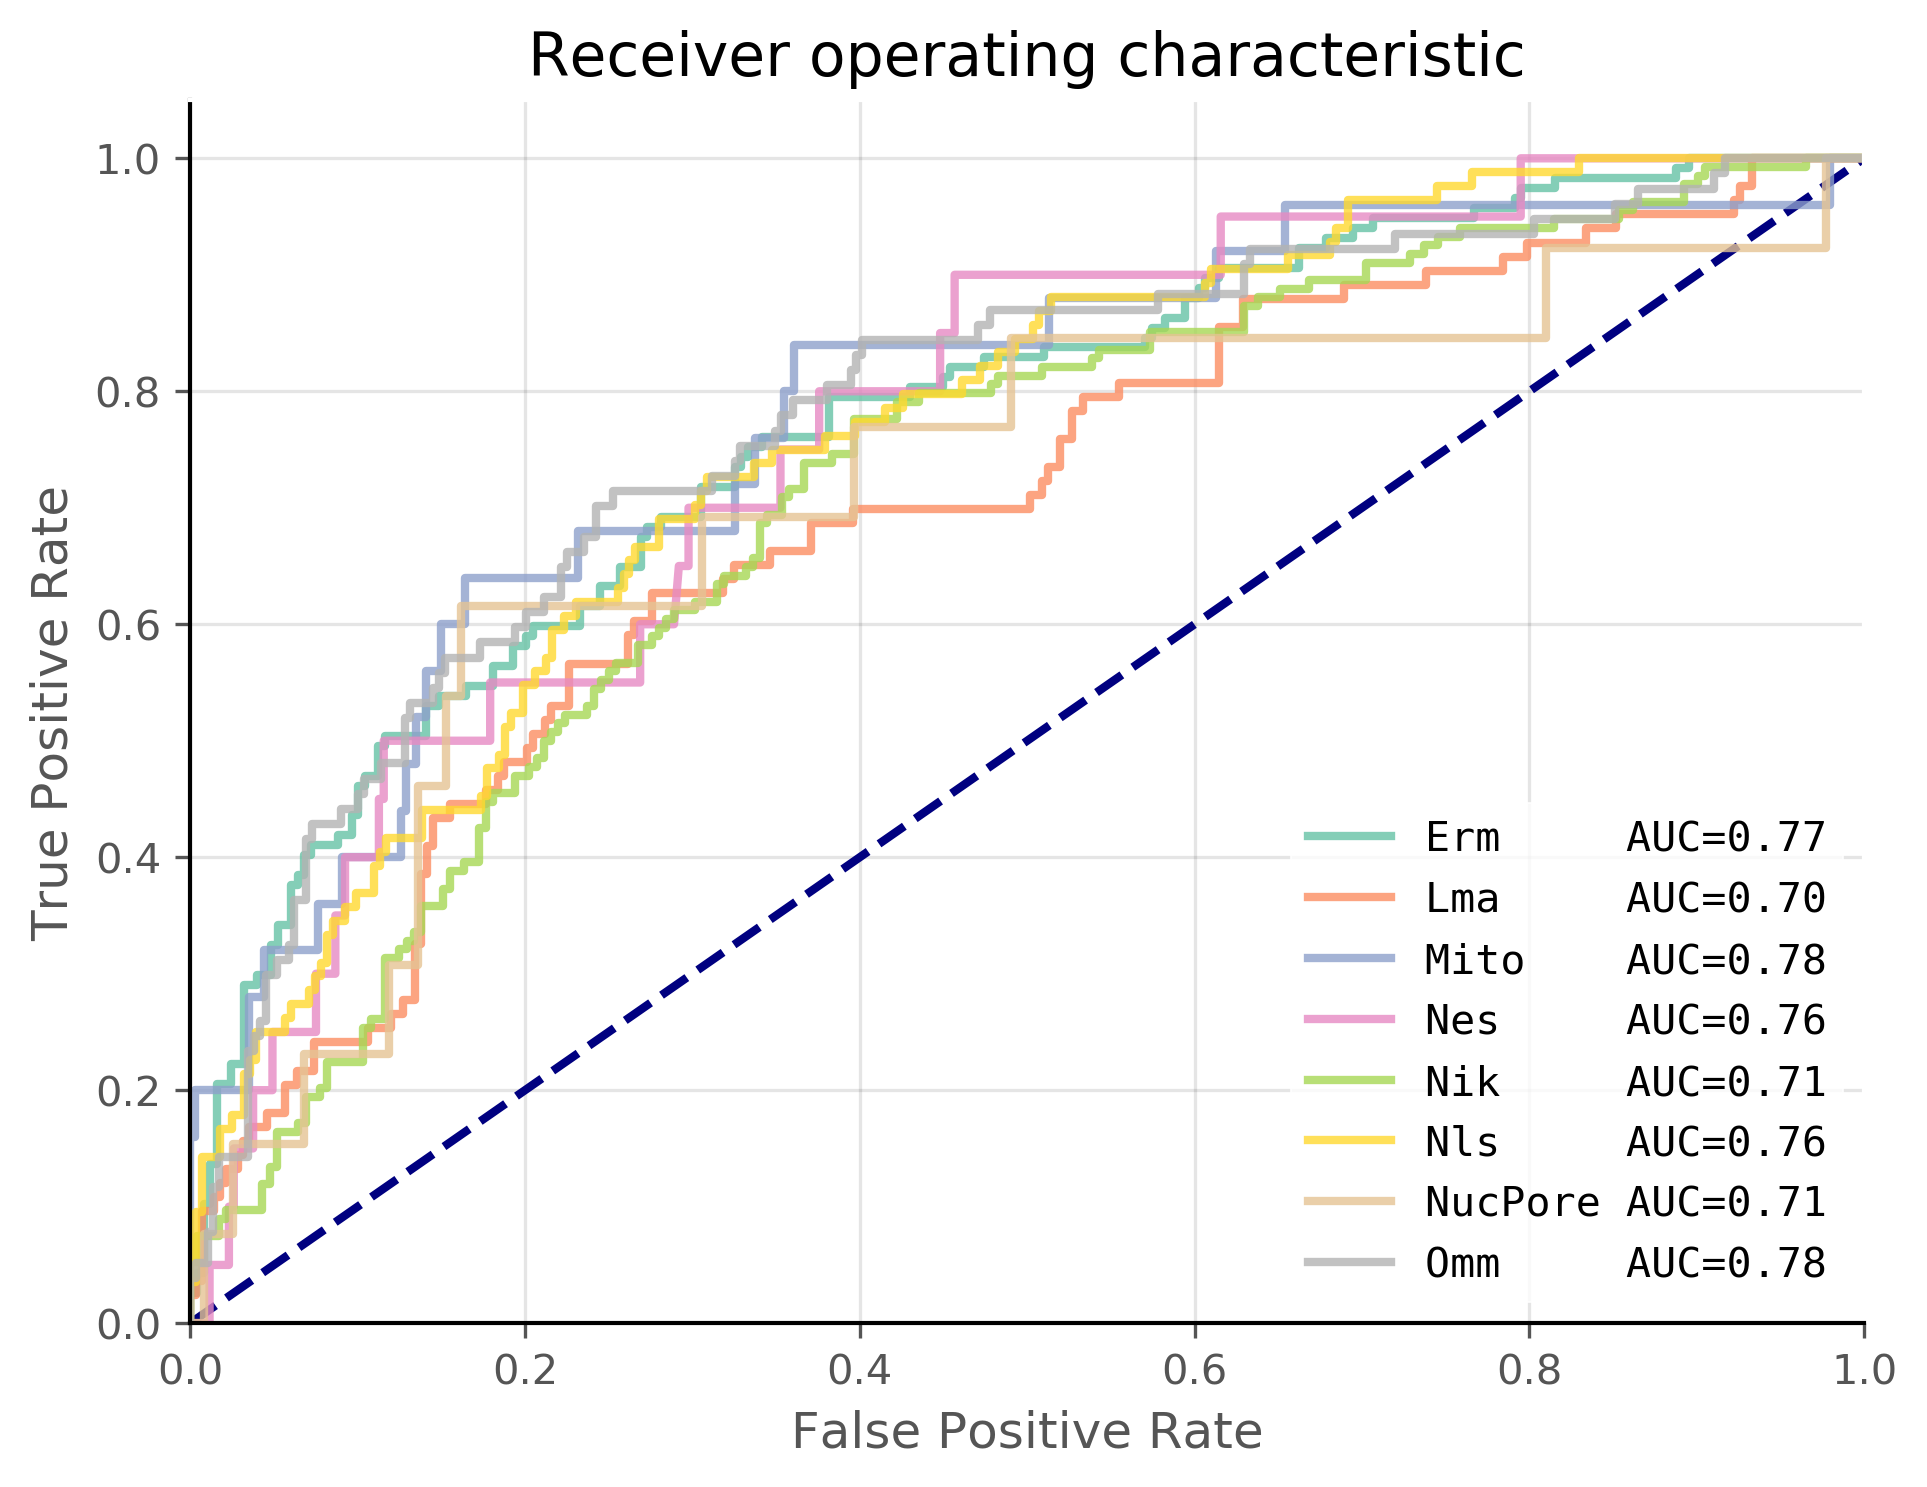

In [5]:
# Random forest classifier
rf_kwargs = {'n_estimators': 300, 'criterion': 'entropy', 'max_depth': 100, 'min_samples_leaf': 0.001, 'max_features': 'sqrt', 'class_weight': None, 'n_jobs': 48, 'random_state': 39282}

rf_model, rf_per_class_perf, rf_overall_perf = model_utils.multi_train(
    RandomForestClassifier(**rf_kwargs),
    train_data,
    valid_data,
    verbose=False
)
print("Validation AUROC: {}".format(rf_overall_perf.auroc))
print("Validation AUPRC: {}".format(rf_overall_perf.auprc))
importlib.reload(plotting_utils)
plotting_utils.plot_auroc(
    {localization: perf for localization, perf in zip(train_dataset.compartments, rf_per_class_perf)}
)

In [6]:
validation_probs = model_utils.list_preds_to_array_preds(rf_model.predict_proba(valid_data[0]))
assert validation_probs.shape == valid_data[1].shape

In [7]:
rf_per_class_test_perf = model_utils.generate_multiclass_perf(
    test_data[1],
    rf_model.predict_proba(test_data[0]),
    8,
)
test_probs = model_utils.list_preds_to_array_preds(rf_model.predict_proba(test_data[0]))
print(test_probs.shape)

(366, 8)


In [8]:
importlib.reload(model_utils)
test_perturbed_auroc_fname = os.path.join(data_loader.LOCAL_DATA_DIR, f"purturbation_kfold_{K_FOLD}_auroc_test.npy")
print(test_perturbed_auroc_fname)
if not os.path.isfile(test_perturbed_auroc_fname):
    test_perturbed_auroc_trials = []
    for seed_val in tqdm.tqdm_notebook(range(15)):  # Number of trials to run
        ft_importance = model_utils.permutation_feature_importance(rf_model, test_data[0], test_data[1], seed=seed_val, threads=32)
        test_perturbed_auroc_trials.append(ft_importance)

    test_perturbed_auroc_tensor = np.stack(test_perturbed_auroc_trials)  # Tensor of trials x features x localizations
    np.save(test_perturbed_auroc_fname, test_perturbed_auroc_tensor)
else:
    test_perturbed_auroc_tensor = np.load(test_perturbed_auroc_fname)
print(test_perturbed_auroc_tensor.shape)

/storage/wukevin/projects/rnagps/data/purturbation_kfold_5_auroc_test.npy
(15, 4032, 8)


In [9]:
perturbed_test_auroc = np.mean(test_perturbed_auroc_tensor, axis=0)
perturbed_test_auroc_sd = np.std(test_perturbed_auroc_tensor, axis=0)
assert perturbed_test_auroc_sd.shape == perturbed_test_auroc.shape == (4032, 8)
perturbed_test_auroc_labelled = pd.DataFrame(
    perturbed_test_auroc,
    columns=test_dataset.compartments,
    index=test_dataset.get_feature_labels(),
)

In [10]:
perturbed_test_auroc_diff = perturbed_test_auroc_labelled - np.array([p.auroc for p in rf_per_class_test_perf])
perturbed_test_auroc_diff

Erm       Lma      Mito       Nes       Nik       Nls  \
u5_AAA   -0.000124 -0.000532 -0.000062  0.000090 -0.000121 -0.000047   
u5_AAC   -0.000005  0.000302 -0.000193  0.000158  0.000217  0.000032   
u5_AAG   -0.000151  0.000570 -0.000961 -0.000264 -0.000008  0.000050   
u5_AAT   -0.000117 -0.000086  0.000000  0.000083  0.000117  0.000134   
u5_ACA   -0.000061 -0.000054  0.000131  0.000000 -0.000071 -0.000108   
u5_ACC   -0.000131  0.000019 -0.000555 -0.000377  0.000176  0.000131   
u5_ACG    0.000027  0.000070  0.000137  0.000400 -0.000188 -0.000143   
u5_ACT    0.000018 -0.000255 -0.000150 -0.000498  0.000199 -0.000125   
u5_AGA   -0.000203  0.000328 -0.000773 -0.000038  0.000169 -0.000023   
u5_AGC    0.000009  0.000197  0.000150 -0.000204  0.000029 -0.000090   
u5_AGG   -0.000174  0.000328 -0.000281 -0.000611 -0.000054 -0.000087   
u5_AGT   -0.000052  0.000547  0.000206 -0.000030  0.000002 -0.000003   
u5_ATA   -0.000038  0.000439  0.000000 -0.000189 -0.000174  0.000017   
u5_ATC    0.000011  0.000337 -0.000549 -0.000030  0.000042 -0.000143   
u5_ATG   -0.000172 -0.000306 -0.000056 -0.000370  0.000276 -0.000114   
u5_ATT   -0.000208 -0.000376 -0.000986  0.000279 -0.000004 -0.000009   
u5_CAA   -0.000041 -0.000191 -0.000243 -0.000045 -0.000203 -0.000064   
u5_CAC    0.000034  0.000111 -0.000006 -0.000068 -0.000190 -0.000035   
u5_CAG    0.000151  0.000713  0.000667  0.000008  0.000109 -0.000084   
u5_CAT    0.000016 -0.000124 -0.000343 -0.000483 -0.000228  0.000114   
u5_CCA    0.000169  0.000312 -0.000069 -0.000173  0.000015 -0.000087   
u5_CCC    0.000088  0.000102 -0.000112 -0.000641  0.000717 -0.000239   
u5_CCG   -0.000262 -0.001114 -0.001160  0.000679 -0.000435  0.000189   
u5_CCT   -0.000172  0.000115 -0.000137  0.001252 -0.000228 -0.000023   
u5_CGA   -0.000088 -0.000382 -0.000112  0.000136  0.000270  0.000181   
u5_CGC   -0.000456  0.000016 -0.000125 -0.000649 -0.000721 -0.000044   
u5_CGG   -0.000172 -0.001881 -0.000642  0.000294  0.000594 -0.000355   
u5_CGT   -0.000145  0.000201  0.000112  0.000196  0.000096  0.000076   
u5_CTA   -0.000237 -0.000251 -0.000069  0.000068  0.000017 -0.000044   
u5_CTC    0.000045  0.000175 -0.000274  0.000166  0.000109 -0.000102   
...            ...       ...       ...       ...       ...       ...   
u3_TTGAG -0.000522 -0.000299  0.000405 -0.000128  0.000268  0.000947   
u3_TTGAT  0.000535 -0.001770  0.000674 -0.001169  0.000546 -0.000079   
u3_TTGCA  0.000072 -0.000293  0.000119  0.000113  0.000052 -0.000119   
u3_TTGCC -0.000097 -0.000293 -0.000087  0.000204  0.000056  0.000577   
u3_TTGCG  0.000014  0.000621  0.000012  0.000415  0.000056 -0.000096   
u3_TTGCT  0.000163  0.000095  0.000050 -0.000023 -0.000036  0.000140   
u3_TTGGA -0.000181 -0.000016 -0.000437  0.000377 -0.000648 -0.000370   
u3_TTGGC -0.000079 -0.000598 -0.000418 -0.000302  0.000146 -0.000484   
u3_TTGGG -0.000063  0.000286  0.001010 -0.001101  0.000289 -0.000073   
u3_TTGGT -0.000068  0.000477  0.000094  0.000309  0.000485 -0.000236   
u3_TTGTA  0.000009  0.000996 -0.000686  0.000958  0.000299  0.000239   
u3_TTGTC -0.000174 -0.000070 -0.000256  0.000181  0.000021 -0.000137   
u3_TTGTG -0.000149 -0.000471  0.000206  0.000385 -0.000161  0.000093   
u3_TTGTT -0.000122 -0.000143 -0.000343 -0.001222  0.000046 -0.000629   
u3_TTTAA -0.000486 -0.000643 -0.000306 -0.000060  0.000056 -0.000469   
u3_TTTAC -0.000160 -0.000003  0.000044 -0.000437 -0.000245 -0.000355   
u3_TTTAG  0.000099 -0.000296 -0.000175 -0.000490  0.000203  0.000140   
u3_TTTAT -0.000065 -0.000060  0.000025  0.000897  0.000299 -0.000198   
u3_TTTCA -0.000449 -0.000614  0.001235 -0.000792 -0.000100 -0.000332   
u3_TTTCC -0.000185 -0.000169  0.000225  0.000362  0.000581 -0.000664   
u3_TTTCG -0.000093  0.000290  0.000368  0.000822  0.000123  0.000283   
u3_TTTCT -0.000452 -0.000306 -0.000667 -0.000370 -0.000036  0.000612   
u3_TTTGA -0.000041  0.000140  0.001385  0.001584 -0.000272 -0.000213   
u3_TTTGC -0.000246  0.000060 -0.000518  0.000249 -0.000

In [11]:
perturbed_test_auroc_sd = pd.DataFrame(
    np.std(test_perturbed_auroc_tensor, axis=0),
    columns=test_dataset.compartments,
    index=test_dataset.get_feature_labels(),
)
perturbed_test_auroc_sd

Erm       Lma      Mito       Nes       Nik       Nls  \
u5_AAA    0.000084  0.000195  0.000065  0.000094  0.000124  0.000063   
u5_AAC    0.000110  0.000200  0.000550  0.000222  0.000195  0.000142   
u5_AAG    0.000142  0.000357  0.000588  0.000178  0.000118  0.000162   
u5_AAT    0.000157  0.000260  0.000202  0.000152  0.000094  0.000151   
u5_ACA    0.000159  0.000097  0.000221  0.000165  0.000158  0.000084   
u5_ACC    0.000116  0.000516  0.000336  0.000448  0.000219  0.000192   
u5_ACG    0.000150  0.000315  0.000696  0.000454  0.000072  0.000171   
u5_ACT    0.000073  0.000213  0.000262  0.000291  0.000161  0.000215   
u5_AGA    0.000159  0.000441  0.000711  0.000448  0.000203  0.000180   
u5_AGC    0.000102  0.000198  0.000207  0.000207  0.000114  0.000157   
u5_AGG    0.000095  0.000266  0.000193  0.000465  0.000238  0.000374   
u5_AGT    0.000251  0.000532  0.000581  0.000742  0.000263  0.000174   
u5_ATA    0.000078  0.000222  0.000000  0.000297  0.000092  0.000042   
u5_ATC    0.000079  0.000156  0.000724  0.000113  0.000107  0.000139   
u5_ATG    0.000161  0.000163  0.000107  0.000224  0.000110  0.000142   
u5_ATT    0.000107  0.000174  0.000532  0.000381  0.000094  0.000079   
u5_CAA    0.000081  0.000442  0.000571  0.000261  0.000086  0.000115   
u5_CAC    0.000084  0.000419  0.000245  0.000391  0.000218  0.000095   
u5_CAG    0.000206  0.000512  0.000742  0.000337  0.000234  0.000178   
u5_CAT    0.000134  0.000229  0.000311  0.000310  0.000197  0.000209   
u5_CCA    0.000137  0.000436  0.000293  0.000222  0.000148  0.000310   
u5_CCC    0.000224  0.000431  0.000592  0.000389  0.000258  0.000284   
u5_CCG    0.000325  0.000885  0.000707  0.000650  0.000584  0.000562   
u5_CCT    0.000153  0.000461  0.000449  0.000975  0.000209  0.000235   
u5_CGA    0.000113  0.000217  0.000333  0.000617  0.000201  0.000171   
u5_CGC    0.000274  0.000747  0.000195  0.000552  0.000427  0.000300   
u5_CGG    0.000293  0.000648  0.000870  0.000857  0.000503  0.000391   
u5_CGT    0.000099  0.000242  0.000391  0.000326  0.000182  0.000283   
u5_CTA    0.000119  0.000198  0.000179  0.000115  0.000195  0.000064   
u5_CTC    0.000125  0.000329  0.000447  0.000116  0.000214  0.000094   
...            ...       ...       ...       ...       ...       ...   
u3_TTGAG  0.000215  0.000487  0.000878  0.000415  0.000373  0.000419   
u3_TTGAT  0.000406  0.001140  0.001190  0.000715  0.000502  0.000653   
u3_TTGCA  0.000113  0.000255  0.000238  0.000234  0.000234  0.000136   
u3_TTGCC  0.000129  0.000192  0.000155  0.000138  0.000222  0.000157   
u3_TTGCG  0.000103  0.000167  0.000132  0.000263  0.000154  0.000121   
u3_TTGCT  0.000281  0.000660  0.000331  0.000310  0.000300  0.000300   
u3_TTGGA  0.000202  0.000510  0.000648  0.001089  0.000498  0.000219   
u3_TTGGC  0.000135  0.000179  0.000177  0.000257  0.000208  0.000180   
u3_TTGGG  0.000221  0.000785  0.001180  0.000715  0.000361  0.000268   
u3_TTGGT  0.000101  0.000315  0.000242  0.000347  0.000326  0.000196   
u3_TTGTA  0.000120  0.000797  0.000728  0.000829  0.000234  0.000285   
u3_TTGTC  0.000094  0.000274  0.000528  0.000206  0.000227  0.000210   
u3_TTGTG  0.000170  0.000417  0.000978  0.000348  0.000261  0.000219   
u3_TTGTT  0.000288  0.000589  0.001129  0.000821  0.000408  0.000447   
u3_TTTAA  0.000206  0.000724  0.000669  0.000603  0.000337  0.000259   
u3_TTTAC  0.000168  0.000499  0.000400  0.000345  0.000228  0.000255   
u3_TTTAG  0.000186  0.000563  0.000596  0.000408  0.000355  0.000232   
u3_TTTAT  0.000168  0.000457  0.000299  0.000742  0.000150  0.000205   
u3_TTTCA  0.000306  0.000798  0.000912  0.000931  0.000398  0.000400   
u3_TTTCC  0.000185  0.000356  0.000355  0.000540  0.000226  0.000230   
u3_TTTCG  0.000081  0.000292  0.000261  0.000549  0.000118  0.000259   
u3_TTTCT  0.000268  0.000977  0.001027  0.000813  0.000348  0.000498   
u3_TTTGA  0.000167  0.000363  0.001049  0.000862  0.000219  0.000253   
u3_TTTGC  0.000202  0.000282  0.000503  0.000278  0.000

In [12]:
perturbed_test_auroc_diff_z = pd.DataFrame(
    interpretation.get_feature_importance_z_scores(test_perturbed_auroc_tensor, np.array([p.auroc for p in rf_per_class_test_perf])),
    columns=test_dataset.compartments,
    index=test_dataset.get_feature_labels(),
)
perturbed_test_auroc_diff_z.shape

(4032, 8)

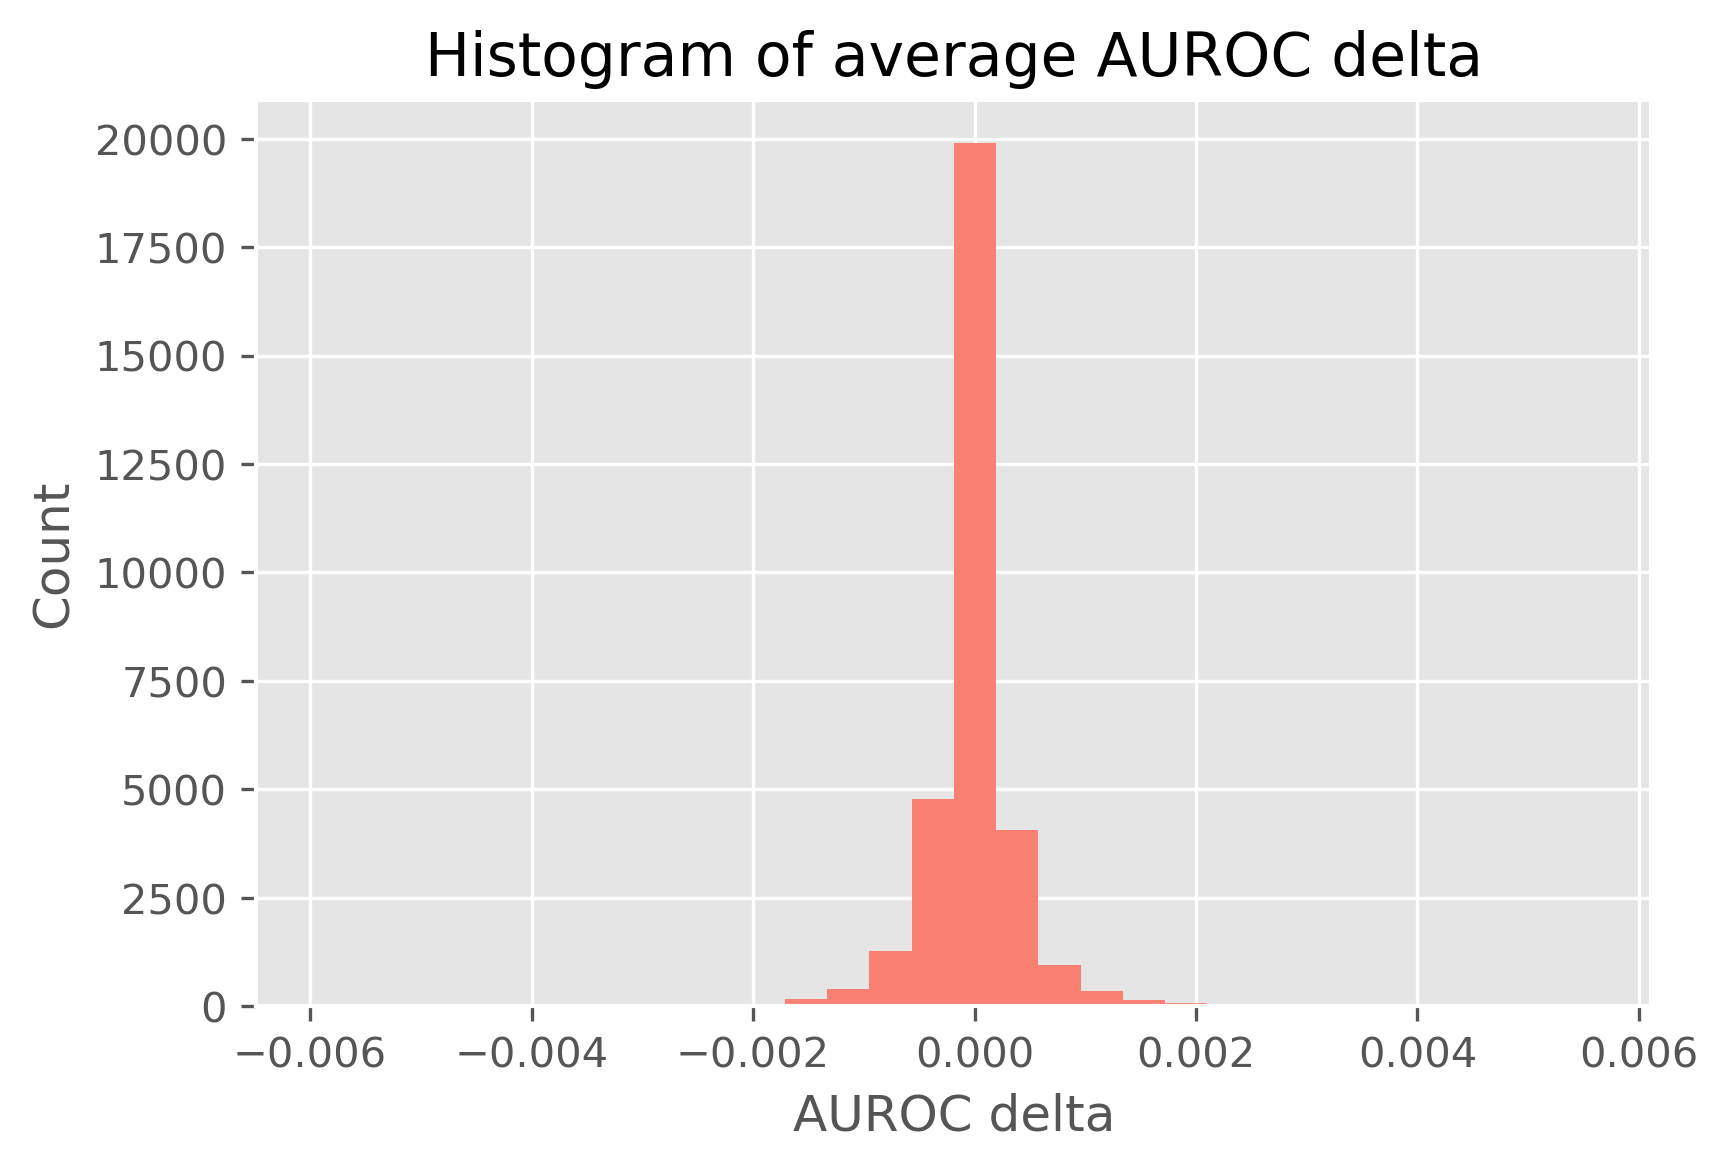

In [13]:
# Test
fig, ax = plt.subplots(dpi=300)
ax.hist(perturbed_test_auroc_diff.values.flatten(), bins=30, color='salmon')
ax.set(ylabel='Count', xlabel="AUROC delta", title="Histogram of average AUROC delta")
fig.show()

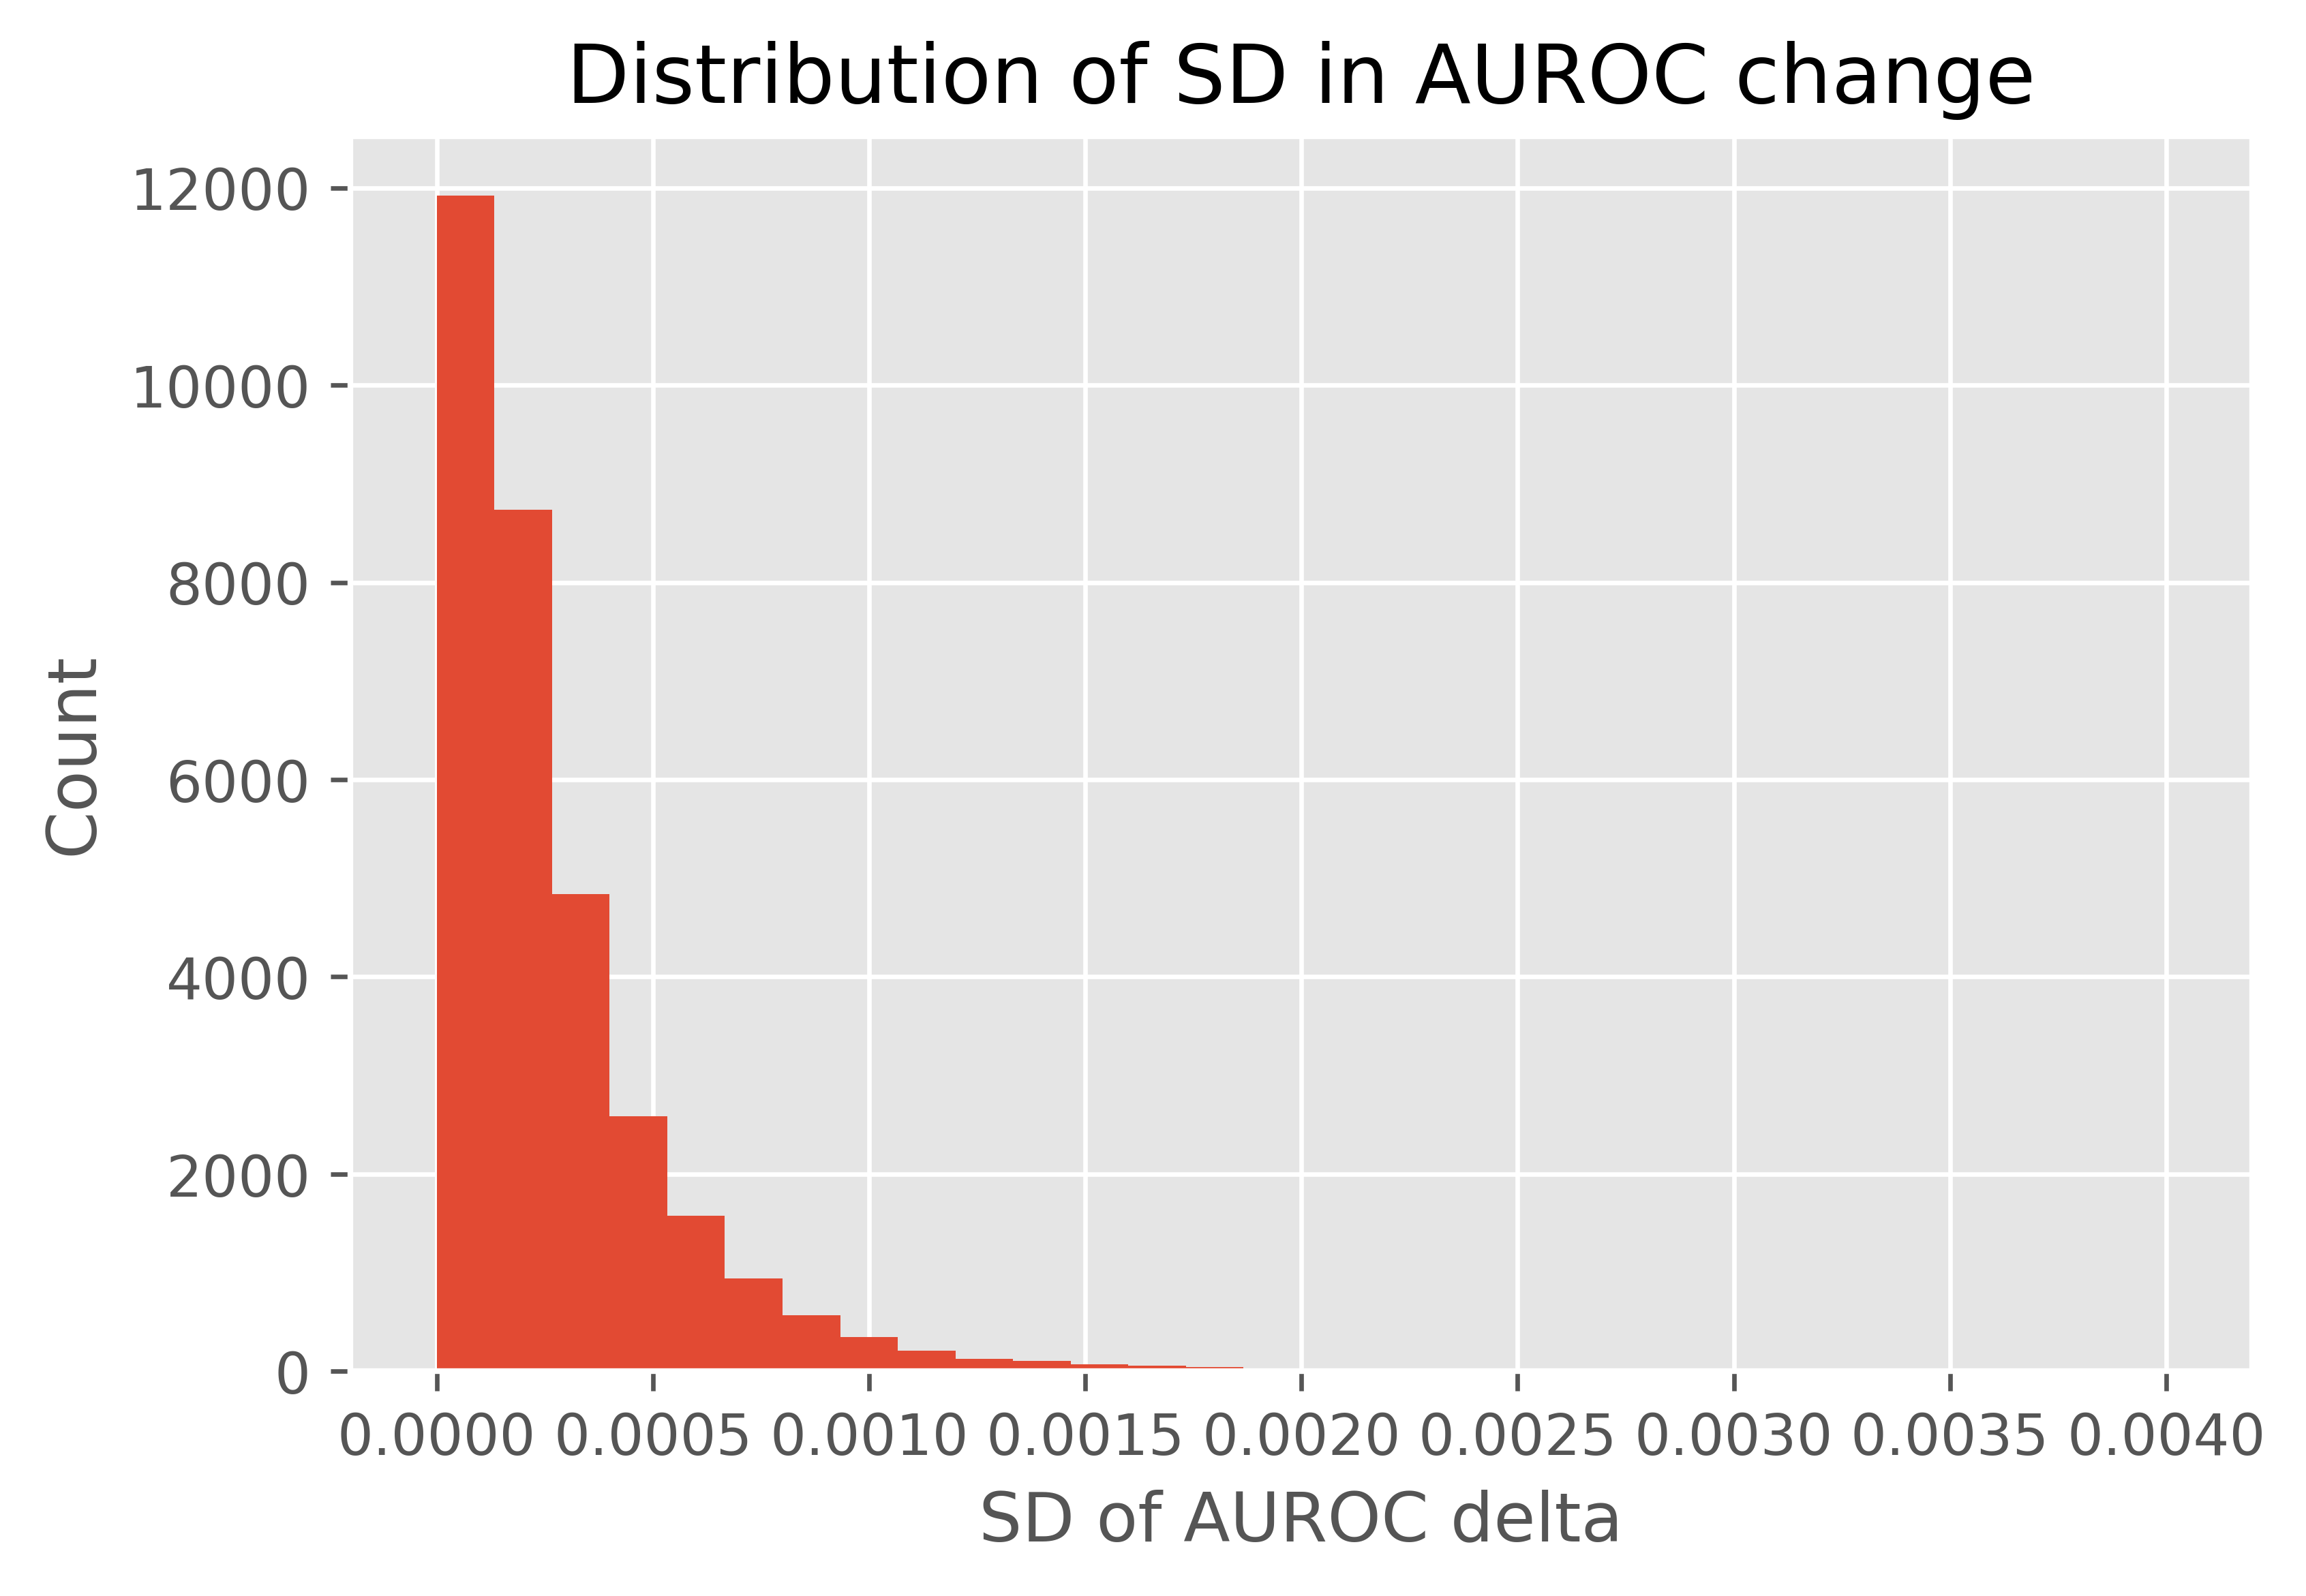

In [14]:
# Test
fig, ax = plt.subplots(dpi=600)
ax.hist(np.std(test_perturbed_auroc_tensor, axis=0).flatten(), bins=30)
ax.set(
    xlabel="SD of AUROC delta",
    ylabel="Count",
    title="Distribution of SD in AUROC change",
)
fig.show()

In [15]:
# Test
test_significant_features = pd.DataFrame(
    interpretation.get_significant_features(test_perturbed_auroc_tensor, np.array([p.auroc for p in rf_per_class_test_perf])),
    index=test_dataset.get_feature_labels(),
    columns=test_dataset.compartments,
)

INFO:root:Number of significant features per localization: [249 253 223 134 130 172 129 312]


In [16]:
# Establish cutoffs based on validation set
importlib.reload(model_utils)
youden_valid_cutoffs = {}
for i, localization in enumerate(valid_dataset.compartments):
    cutoff = model_utils.youden_threshold(
        validation_probs[:, i],
        valid_data[1][:, i],
    )
    youden_valid_cutoffs[localization] = cutoff
print(youden_valid_cutoffs)

{'Erm': 0.35180463980463994, 'Lma': 0.21918939393939396, 'Mito': 0.08393867243867247, 'Nes': 0.05509824434824434, 'Nik': 0.3411709586709588, 'Nls': 0.22306493506493516, 'NucPore': 0.0739153439153439, 'Omm': 0.24330074555074552}


In [193]:
# Assemble test kmers
importlib.reload(interpretation)
for localization in test_dataset.compartments:
    gap_size = 2
    print(f"Assembling kmers driving transcripts to {localization} with gap {gap_size}")
    test_assembled_kmer_fasta_dicts = interpretation.get_explanatory_motifs(
        test_probs[:, test_dataset.compartments.index(localization)],
        test_data[1][:, test_dataset.compartments.index(localization)],
        test_significant_features.index[test_significant_features.loc[:, localization]],
        test_dataset,
        gap_allowed=gap_size,
        youden=youden_valid_cutoffs[localization],
    )
    for prefix, fa_dict in zip(['u5', 'cds', 'u3'], test_assembled_kmer_fasta_dicts):
        fname = os.path.join(INTERMEDIATE_DATA_DIR, f"test_kmer_assembly_{gap_size}_bp_gap/localization_assembled_kmers", f"{localization}_{prefix}_assembled_kmers.fa")
        print("Writing assembled kmers to " + fname)
        fasta.write_sequence_dict_to_file(fa_dict, fname)

INFO:root:CPU


Assembling kmers driving transcripts to Erm with gap 2
Writing assembled kmers to /storage/wukevin/projects/rnagps/data/intermediate_kfold_5/test_kmer_assembly_2_bp_gap/localization_assembled_kmers/Erm_u5_assembled_kmers.fa
Writing assembled kmers to /storage/wukevin/projects/rnagps/data/intermediate_kfold_5/test_kmer_assembly_2_bp_gap/localization_assembled_kmers/Erm_cds_assembled_kmers.fa
Writing assembled kmers to /storage/wukevin/projects/rnagps/data/intermediate_kfold_5/test_kmer_assembly_2_bp_gap/localization_assembled_kmers/Erm_u3_assembled_kmers.fa
Assembling kmers driving transcripts to Lma with gap 2
Writing assembled kmers to /storage/wukevin/projects/rnagps/data/intermediate_kfold_5/test_kmer_assembly_2_bp_gap/localization_assembled_kmers/Lma_u5_assembled_kmers.fa
Writing assembled kmers to /storage/wukevin/projects/rnagps/data/intermediate_kfold_5/test_kmer_assembly_2_bp_gap/localization_assembled_kmers/Lma_cds_assembled_kmers.fa
Writing assembled kmers to /storage/wukevin

Process for taking assembled kmers and finding hits:

Run a MSA of the assembled kmers
```
python rnagps/scripts/run_msa.py --outdir ../localization_msa *.fa
```

Use MSA to find well-supported motifs
```
python ../../../../rnagps/msa.py -r 3 -l 7 ../localization_msa/*.msa
```

Run TomTom to find hits to known PWMs among above motifs
```
python ../../../../scripts/run_tomtom.py *.fa
```

In [215]:
def read_aggregated_tomtom_hits(tomtom_hits, q_cutoff=None, gene_level=True, split_by_trans_part=False):
    """
    Aggregates tomtom hits to a table of RNA localization (rows) to RBP localization (cols)
    If gene_level is True, translate IDs like RNCMPT00158 to gene names, otherwise
    leave in ID form
    """
    assert tomtom_hits, f"tomtom_hits cannot be empty"
    localization_to_genes = collections.defaultdict(list)

    rna_complete_key_to_gene = {}
    rna_complete_table = interpretation.read_rna_complete_html_table()
    for _i, row in rna_complete_table.iterrows():
        rna_complete_key_to_gene[row['ID']] = row['Gene name']

    for fname in tomtom_hits:
        localization, transcript_part, _x, _y = os.path.basename(os.path.dirname(fname)).split(".")[0].split("_")
        if split_by_trans_part:
            localization = localization + "_" + transcript_part
        tomtom_results = interpretation.read_tomtom_tsv(fname, q_cutoff=q_cutoff)
        rna_complete_ids = tomtom_results['Target_ID']  # ID of the RBP
        if gene_level:
            genes = [rna_complete_key_to_gene[rid] for rid in rna_complete_ids]
            localization_to_genes[localization].extend(genes)
        else:
            localization_to_genes[localization].extend(rna_complete_ids)
    return localization_to_genes

def localization_rbp_to_rbp_localization(localization_to_genes, unique_genes=True):
    """Given a mapping of localization to genes (RBP), convert into a table"""
    # Load in some prerequisite resource files
    human_protein_atlas = pd.read_csv(
        os.path.join(os.path.dirname(SRC_DIR), "data/human_protein_atlas/subcellular_location.tsv"),
        delimiter='\t',
        engine='c',
        low_memory=False,
    )
    # Map the genes to localizations
    localization_to_genes_localizations = {}
    for localization, genes in localization_to_genes.items():
        # These genes are genes taht are binding to transcripts at that localization
        localization_to_genes_localizations[localization] = collections.Counter()
        if unique_genes:
            genes = set(genes)
        for gene in genes:
            atlas_row = human_protein_atlas[human_protein_atlas['Gene name'] == gene]
            atlas_row = atlas_row.fillna('')
            # https://www.proteinatlas.org/about/assays+annotation
            # gene_locations = list(atlas_row['Enhanced'].values) + list(atlas_row['Supported'].values)
            gene_locations = list(atlas_row['Enhanced'].values) + list(atlas_row['Supported'].values) + list(atlas_row['Approved'].values)
            gene_locations = [x for x in itertools.chain.from_iterable([c.split(";") for c in gene_locations]) if x]
            localization_to_genes_localizations[localization].update(gene_locations)
    localization_to_binding_protein_localizations = pd.DataFrame(localization_to_genes_localizations, dtype=int).transpose()
    localization_to_binding_protein_localizations = localization_to_binding_protein_localizations.fillna(0)
    return localization_to_binding_protein_localizations

In [219]:
gap_2_tomtom_test_results = glob.glob(os.path.join(
    INTERMEDIATE_DATA_DIR,
    f'test_kmer_assembly_2_bp_gap/localization_tomtom_3_support/*_assembled_kmers/*.tsv'
))
gap_1_tomtom_test_results = glob.glob(os.path.join(
    INTERMEDIATE_DATA_DIR,
    f'test_kmer_assembly_1_bp_gap/localization_tomtom_3_support/*_assembled_kmers/*.tsv'
))
gap_0_tomtom_test_results = glob.glob(os.path.join(
    INTERMEDIATE_DATA_DIR,
    f'test_kmer_assembly_0_bp_gap/localization_tomtom_3_support/*_assembled_kmers/*.tsv'
))

In [194]:
meme_hit_test_genes = read_aggregated_tomtom_hits(
    gap_1_tomtom_test_results,
    q_cutoff=0.05,
)

for localization in test_dataset.compartments:
    print("***", localization)
    print(" ".join(meme_hit_test_genes[localization]))

*** Erm
CPEB4 U2AF2 TIA1 CPEB4 U2AF2 TIA1 CPEB2 PTBP1 HuR TIA1 HNRNPC PTBP1 HNRNPCL1 RALY U2AF2 PTBP1 PTBP1 TIA1 HNRNPC HNRNPCL1 FXR2 FMR1 SRSF1 SRSF1 PCBP2 PTBP1
*** Lma
RBM4 RBM4 PCBP2 PCBP1 PTBP1 PTBP1 RBMS1 RBMS3 RBMS3 PCBP1 HNRNPH2
*** Mito
PCBP2 ZC3H10 HNRNPK RBM4 RBM4 PPRC1 RBM8A HNRNPK PCBP2 HNRNPK PCBP2 HNRNPK HNRPLL
*** Nes
HuR HuR HuR ZC3H14 TIA1 TIA1 HuR RALY RBM41 CPEB4 HNRNPCL1 U2AF2 HNRNPC HuR CPEB2 PTBP1
*** Nik
PCBP2 U2AF2 PCBP1 PTBP1 PTBP1 TIA1 PCBP2 ZC3H10
*** Nls
STAR-PAP RBM6 PTBP1 PTBP1 HNRNPC HNRNPCL1 RALY U2AF2 TIA1 HuR TIA1 ENOX1 RBM8A PPRC1 RBM4 RBM4 PPRC1 FUS
*** NucPore

*** Omm
HNRNPH2 RBM4 RBM4 KHDRBS2 HuR HuR TIA1 TIA1 RALY CPEB4 ZC3H14 HNRNPCL1 U2AF2 HNRNPC HuR CPEB2 HuR U2AF2 TIA1 HuR RALY CPEB4 PTBP1 HNRNPCL1 HNRNPC TIA1 CPEB2 HuR PTBP1 ZC3H14 HuR RBMS1 RBMS3 HNRNPH2 RBM4 RBM4 PPRC1 RBM8A ZC3H10 HNRNPH2 RBM8A PPRC1 RBM4 RBM4 FUS HNRNPK PCBP2 FUS RBM8A PPRC1 RBM4 RBM4


In [201]:
meme_hit_2_test_genes = read_aggregated_tomtom_hits(
    gap_2_tomtom_test_results,
    q_cutoff=0.05,
)
for localization in test_dataset.compartments:
    print("***", localization)
    print(" ".join(meme_hit_2_test_genes[localization]))

*** Erm
U2AF2 TIA1 HuR RALY TIA1 PTBP1 HNRNPC CPEB4 HNRNPCL1 HNRPLL HNRNPL ENOX1 SRSF1 SRSF1 SRSF9 SRSF1 HNRNPH2 RBM5 SRSF1 SRSF1 LIN28A HuR CPEB4 CPEB2 HuR TIA1 TIA1 PTBP1 PTBP1 RALY ZC3H14 HNRNPCL1 U2AF2 HNRNPC HuR HuR HuR TIA1 TIA1 RALY CPEB4 HNRNPCL1 U2AF2 HNRNPC ZC3H14 CPEB2 U2AF2 TIA1 RALY HuR CPEB4 CPEB4 PTBP1 CPEB2 PTBP1 HuR HNRNPC HNRNPCL1 RALY TIA1 TIA1 U2AF2 HuR PTBP1 HuR TIA1 PTBP1 TIA1 ZNF638 U2AF2 RALY CPEB4 HNRNPCL1 ZC3H14 HNRNPC CPEB2 HuR SAMD4A MSI1 MSI1 RBMS1 RBMS3 RBMS3 KHDRBS2
*** Lma
SART3 PABPC1 HNRNPK ZC3H10 RBM4 RBM4 RBM8A PPRC1 RBM4 RBM4 FUS HNRNPK RBM5 PCBP1 PCBP2
*** Mito
PCBP2 FUS RBM8A PPRC1 HuR ZC3H14 HuR HuR
*** Nes
PTBP1 U2AF2 TIA1 PCBP1 PTBP1 CPEB4 RALY HuR PCBP2 U2AF2 TIA1 HuR RALY CPEB4 HNRNPCL1 HNRNPC TIA1 CPEB2 PCBP2 HuR PTBP1 FXR2 ENOX1 SRSF10 SRSF10 SRSF10 PABPN1 PABPC5 SART3 PABPC1 PABPC3 HuR HuR ZC3H14 HuR
*** Nik
RBM8A PPRC1 ZC3H10 RBM4 RBM4 FUS PTBP1 YBX1 YBX2 YBX1 ZC3H14 HuR HuR U2AF2 TIA1 HNRNPC HNRNPCL1 CPEB4 CPEB2 PTBP1 HuR HNRNPC HNRNPCL1

In [220]:
meme_hit_0_test_genes = read_aggregated_tomtom_hits(
    gap_0_tomtom_test_results,
    q_cutoff=0.05,
)
for localization in test_dataset.compartments:
    print("***", localization)
    print(" ".join(meme_hit_0_test_genes[localization]))

*** Erm
RBM5 PTBP1 ZNF638 RBMS3 RBMS3 SFPQ HNRNPC HNRNPCL1 YBX1 YBX1
*** Lma
RBM4 RBM4 RBM8A PPRC1 SAMD4A
*** Mito
U2AF2 TIA1 PTBP1 PTBP1 RALY HuR CPEB4 HNRNPCL1 HNRNPC
*** Nes

*** Nik
PCBP2 CPEB4 CPEB2 PTBP1 HuR HNRNPC HNRNPCL1 RALY TIA1 TIA1 U2AF2 RALY TIA1 HuR HuR HuR ZC3H14 TIA1 TIA1 HuR RALY RBM41 CPEB4 HNRNPCL1 U2AF2 HNRNPC HuR CPEB2 PTBP1 PTBP1 U2AF2 HuR TIA1 HuR HuR ZC3H14 TIA1 HuR RALY RBM41 CPEB4 HNRNPCL1 HNRNPC PTBP1 HuR CPEB2
*** Nls
PCBP2 RBM4 RBM4 CPEB4 HuR U2AF2 TIA1 PTBP1 CPEB2 TIA1 PTBP1 HuR RALY HNRNPC HNRNPCL1 ZC3H14 HuR HuR FUS PCBP2
*** NucPore

*** Omm
YBX1 YBX1 FMR1 FXR2 ZC3H10 ZC3H10 U2AF2 TIA1 PTBP1 RBM4 RBM4 RBM4 RBM4 PPRC1 RBM8A ZC3H10 RBM8A PPRC1 ZC3H10 RBM4 PCBP2 RBM4 FUS PCBP2


In [233]:
# Plot which genes are showing up where
meme_hit_all_test_genes = sorted(list(set(itertools.chain.from_iterable(meme_hit_test_genes.values()))))
meme_hit_all_test_genes_counts = pd.DataFrame(
    0,
    index=test_dataset.compartments,
    columns=meme_hit_all_test_genes
)
meme_hit_2_all_test_genes = sorted(list(set(itertools.chain.from_iterable(meme_hit_2_test_genes.values()))))
meme_hit_2_all_test_genes_counts = pd.DataFrame(
    0,
    index=test_dataset.compartments,
    columns=meme_hit_2_all_test_genes,
)
meme_hit_0_all_test_genes = sorted(list(set(itertools.chain.from_iterable(meme_hit_0_test_genes.values()))))
meme_hit_0_all_test_genes_counts = pd.DataFrame(
    0,
    index=test_dataset.compartments,
    columns=meme_hit_0_all_test_genes,
)

for localization in test_dataset.compartments:
    for gene in meme_hit_test_genes[localization]:
        meme_hit_all_test_genes_counts.loc[localization, gene] += 1
    for gene in meme_hit_2_test_genes[localization]:
        meme_hit_2_all_test_genes_counts.loc[localization, gene] += 1
    for gene in meme_hit_0_test_genes[localization]:
        meme_hit_0_all_test_genes_counts.loc[localization, gene] += 1

meme_hit_all_test_genes_counts.index = [data_loader.LOCALIZATION_FULL_NAME_DICT[l] for l in meme_hit_all_test_genes_counts.index]
print(meme_hit_all_test_genes_counts.sum(axis=1))
meme_hit_2_all_test_genes_counts.index = [data_loader.LOCALIZATION_FULL_NAME_DICT[l] for l in meme_hit_2_all_test_genes_counts.index]
print(meme_hit_2_all_test_genes_counts.sum(axis=1))
meme_hit_0_all_test_genes_counts.index = [data_loader.LOCALIZATION_FULL_NAME_DICT[l] for l in meme_hit_0_all_test_genes_counts.index]
print(meme_hit_0_all_test_genes_counts.sum(axis=1))

ER membrane            26
Nuclear lamina         11
Mito matrix            13
Cytosol                16
Nucleolus               8
Nucleus                18
Nuclear pore            0
Outer mito membrane    52
dtype: int64
ER membrane             84
Nuclear lamina          15
Mito matrix              8
Cytosol                 35
Nucleolus               32
Nucleus                 16
Nuclear pore             6
Outer mito membrane    109
dtype: int64
ER membrane            10
Nuclear lamina          5
Mito matrix             9
Cytosol                 0
Nucleolus              46
Nucleus                20
Nuclear pore            0
Outer mito membrane    24
dtype: int64


In [21]:
meme_hit_all_test_genes_counts.sum(axis=0)

CPEB2        4
CPEB4        5
ENOX1        1
FMR1         1
FUS          3
FXR2         1
HNRNPC       6
HNRNPCL1     6
HNRNPH2      4
HNRNPK       5
HNRPLL       1
HuR         14
KHDRBS2      1
PCBP1        3
PCBP2        8
PPRC1        6
PTBP1       14
RALY         5
RBM4        14
RBM41        1
RBM6         1
RBM8A        5
RBMS1        2
RBMS3        3
SRSF1        2
STAR-PAP     1
TIA1        13
U2AF2        8
ZC3H10       3
ZC3H14       3
dtype: int64

In [22]:
# For input to DAVID, gap = 1
# Top hit is "mRNA splicing, via spliceosome" p=3.6E-15
' '.join(meme_hit_all_test_genes_counts.columns)

'CPEB2 CPEB4 ENOX1 FMR1 FUS FXR2 HNRNPC HNRNPCL1 HNRNPH2 HNRNPK HNRPLL HuR KHDRBS2 PCBP1 PCBP2 PPRC1 PTBP1 RALY RBM4 RBM41 RBM6 RBM8A RBMS1 RBMS3 SRSF1 STAR-PAP TIA1 U2AF2 ZC3H10 ZC3H14'

In [210]:
len(meme_hit_all_test_genes_counts.columns)

30

In [206]:
# For input to david, gap = 2
# Top hit is "mRNA splicing, via spliceosome" p=3.8E-28
' '.join(meme_hit_2_all_test_genes_counts.columns)

'CPEB2 CPEB4 ENOX1 FMR1 FUS FXR1 FXR2 HNRNPC HNRNPCL1 HNRNPH2 HNRNPK HNRNPL HNRPLL HuR KHDRBS2 LIN28A MBNL1 MSI1 PABPC1 PABPC3 PABPC5 PABPN1 PCBP1 PCBP2 PPRC1 PTBP1 RALY RBFOX1 RBM4 RBM45 RBM5 RBM6 RBM8A RBMS1 RBMS3 SAMD4A SART3 SNRNP70 SRSF1 SRSF10 SRSF2 SRSF7 SRSF9 TARDBP TIA1 U2AF2 YBX1 YBX2 ZC3H10 ZC3H14 ZNF638'

In [211]:
len(meme_hit_2_all_test_genes_counts.columns)

51

In [209]:
# Intersection b/w 1 and 2
len(set(meme_hit_all_test_genes_counts.columns).intersection(set(meme_hit_2_all_test_genes_counts.columns)))

28

In [225]:
# FOr input to DAVID, gap = 0
# Top hit is "mRNA splicing, via spliceosome", p=2.7E-12
' '.join(meme_hit_0_all_test_genes_counts.columns)

'CPEB2 CPEB4 FMR1 FUS FXR2 HNRNPC HNRNPCL1 HuR PCBP2 PPRC1 PTBP1 RALY RBM4 RBM41 RBM5 RBM8A RBMS3 SAMD4A SFPQ TIA1 U2AF2 YBX1 ZC3H10 ZC3H14 ZNF638'

In [226]:
len(meme_hit_0_all_test_genes_counts.columns)

25

In [227]:
# Intersection b/w 0 and 1
len(set(meme_hit_all_test_genes_counts.columns).intersection(set(meme_hit_0_all_test_genes_counts.columns)))

20

In [228]:
# Intersection b/w 0 and 2
len(set(meme_hit_2_all_test_genes_counts.columns).intersection(set(meme_hit_0_all_test_genes_counts.columns)))

23

In [229]:
# Intersection b/w all three
len(
    set(meme_hit_2_all_test_genes_counts.columns).intersection(
        set(meme_hit_0_all_test_genes_counts.columns).intersection(
            set(meme_hit_all_test_genes_counts.columns)
        )
    )
)

19

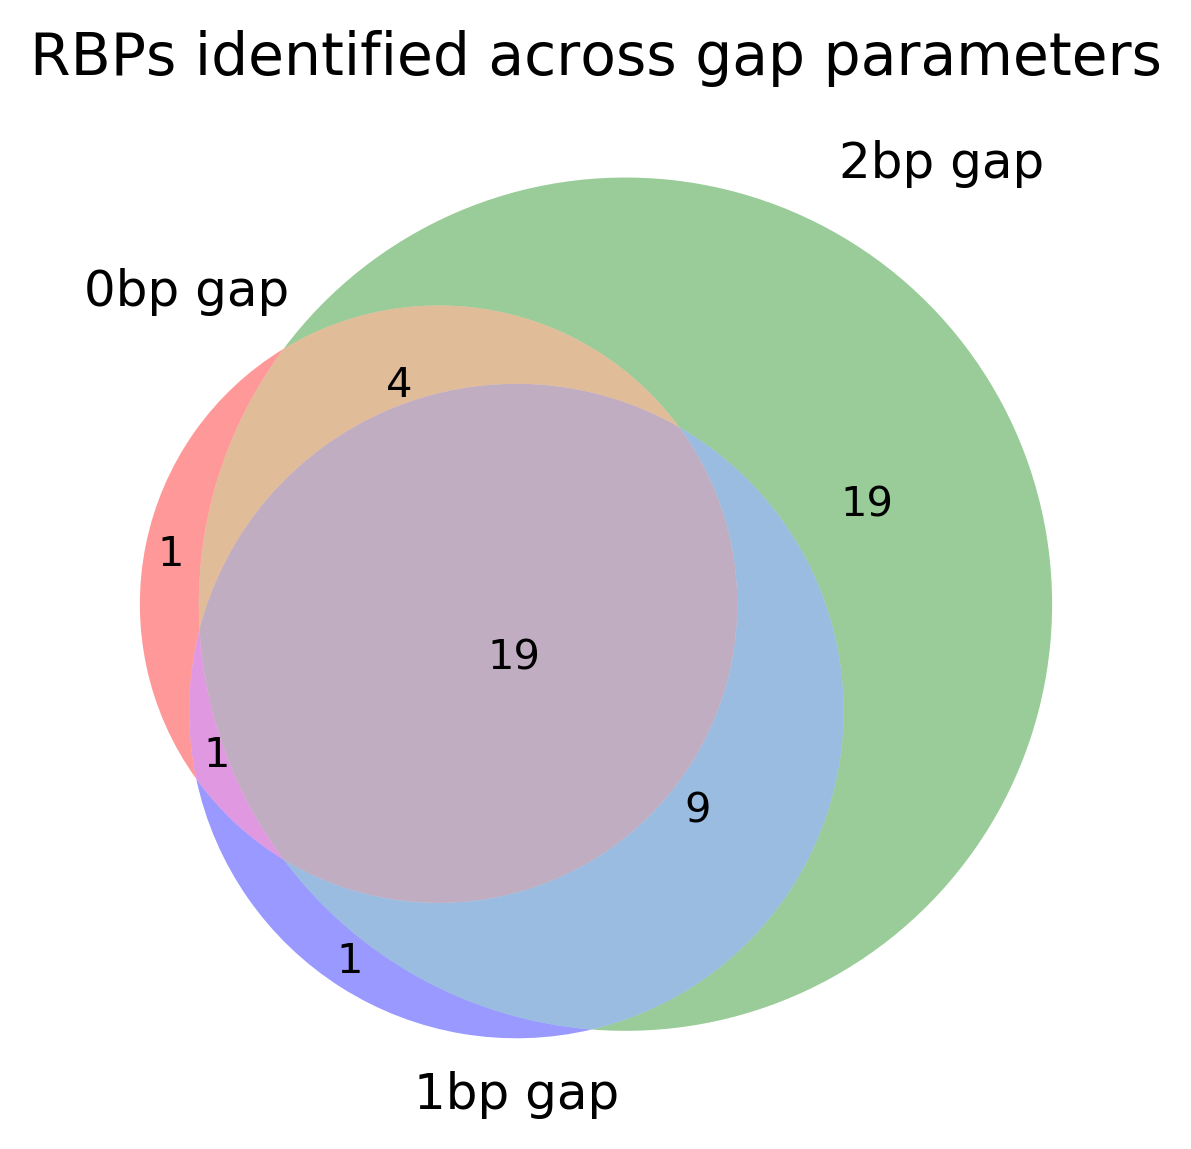

In [274]:
from matplotlib_venn import venn3, venn3_circles

fig, ax = plt.subplots(dpi=300)
venn3(
    [
        set(meme_hit_0_all_test_genes_counts.columns),
        set(meme_hit_2_all_test_genes_counts.columns),
        set(meme_hit_all_test_genes_counts.columns),
    ],
    set_labels=["0bp gap", "2bp gap", "1bp gap"],
    ax=ax,
)
ax.set(title="RBPs identified across gap parameters")
fig.savefig(os.path.join(PLOT_DIR, "rbp_gap_venn.pdf"), dpi=1200, bbox_inches='tight')
fig.show()

(8, 30)


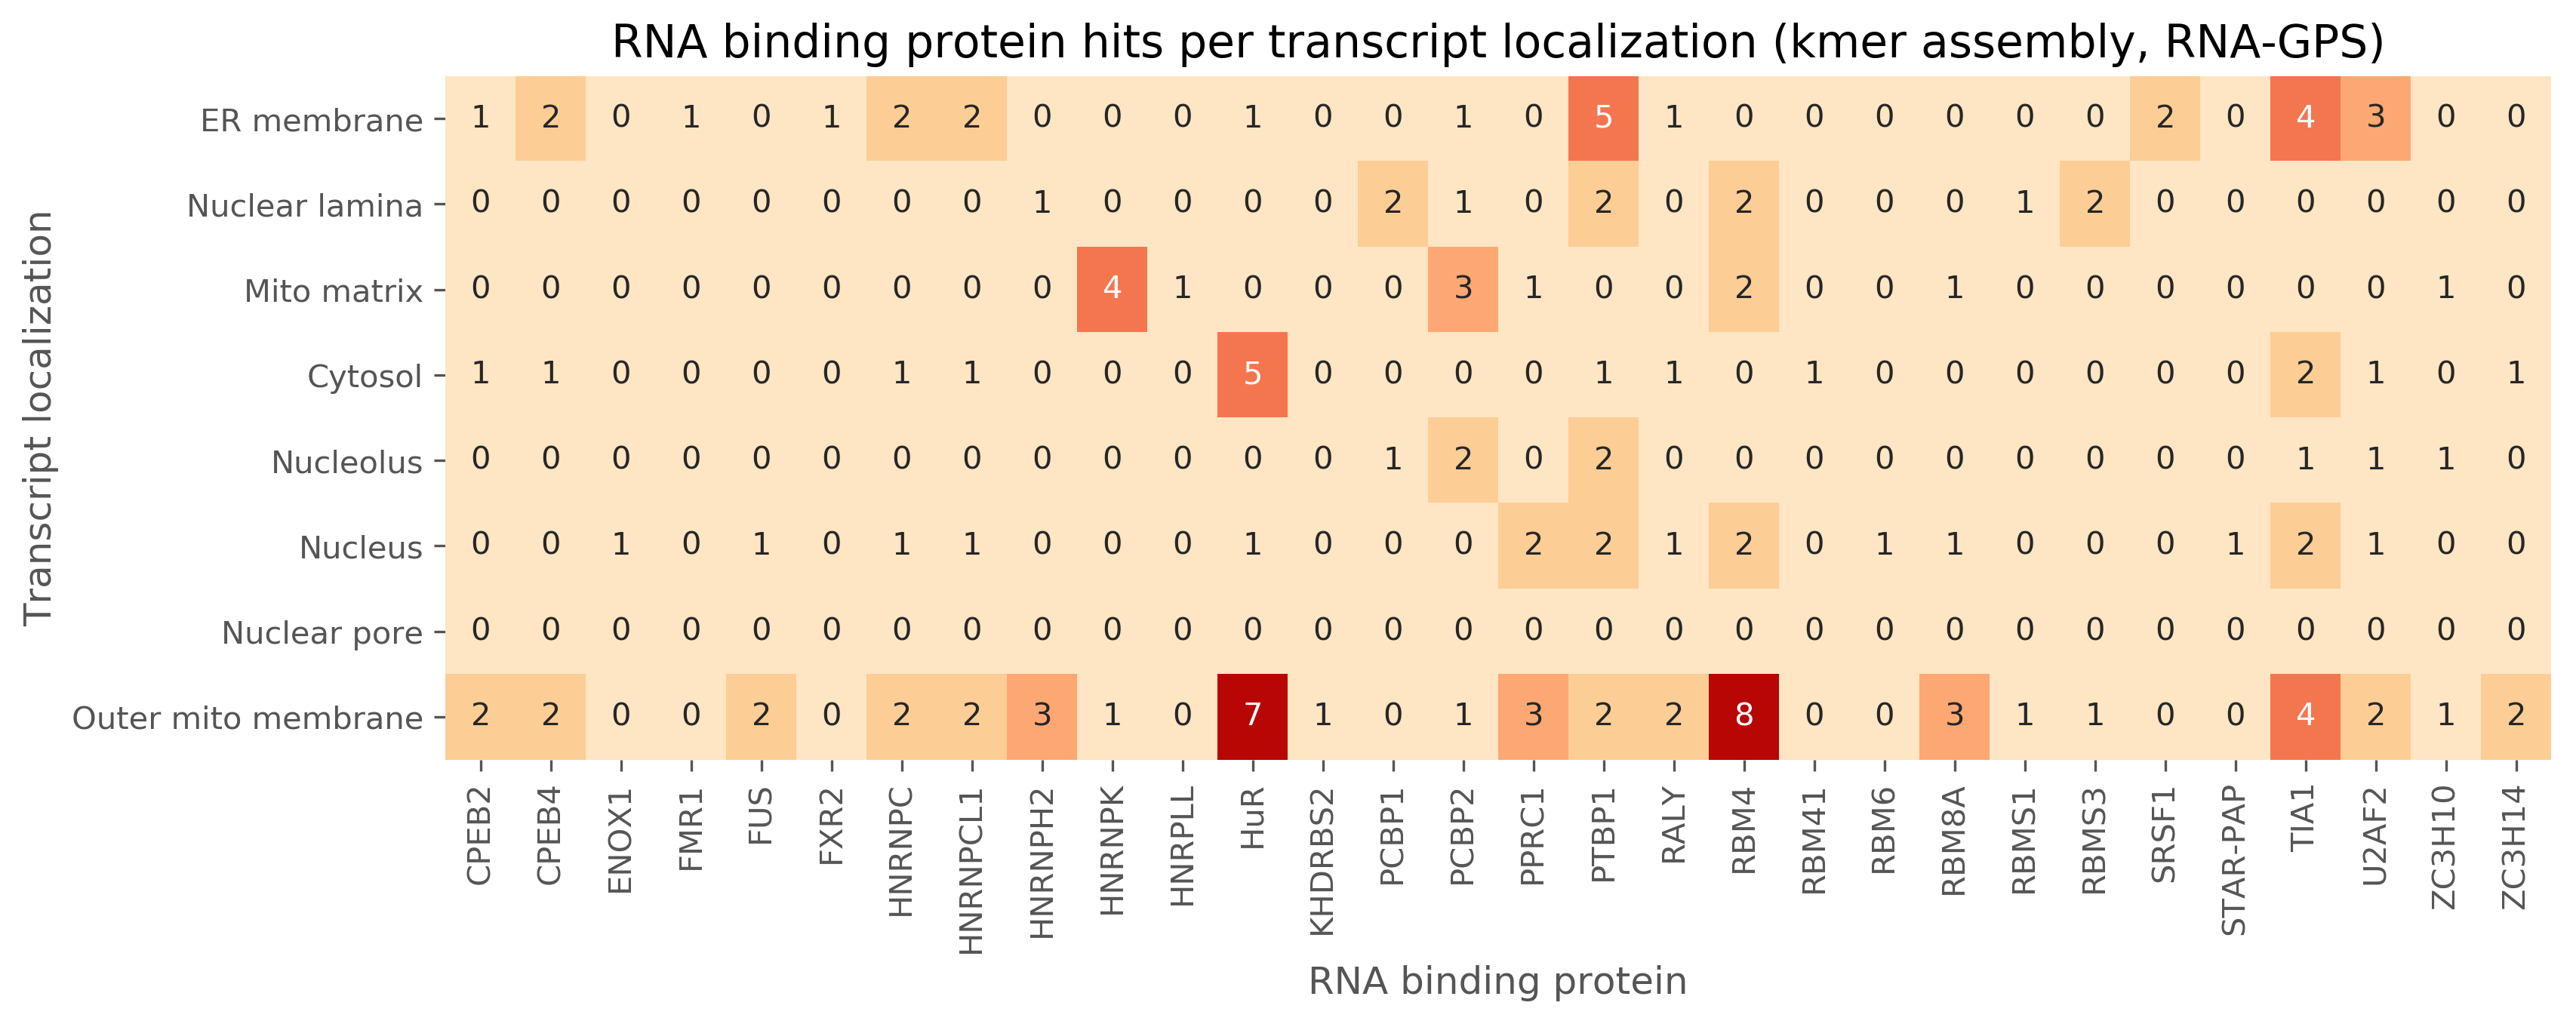

In [23]:
# TEST SET
print(meme_hit_all_test_genes_counts.shape)
fig, ax = plt.subplots(dpi=300, figsize=(12, 4))
ax = sns.heatmap(
    meme_hit_all_test_genes_counts,
    annot=True,
    cbar=False,
    ax=ax,
    cmap=sns.color_palette("OrRd"),
)
ax.set(
    title="RNA binding protein hits per transcript localization (kmer assembly, RNA-GPS)",
    ylabel="Transcript localization",
    xlabel="RNA binding protein",
)
fig.show()

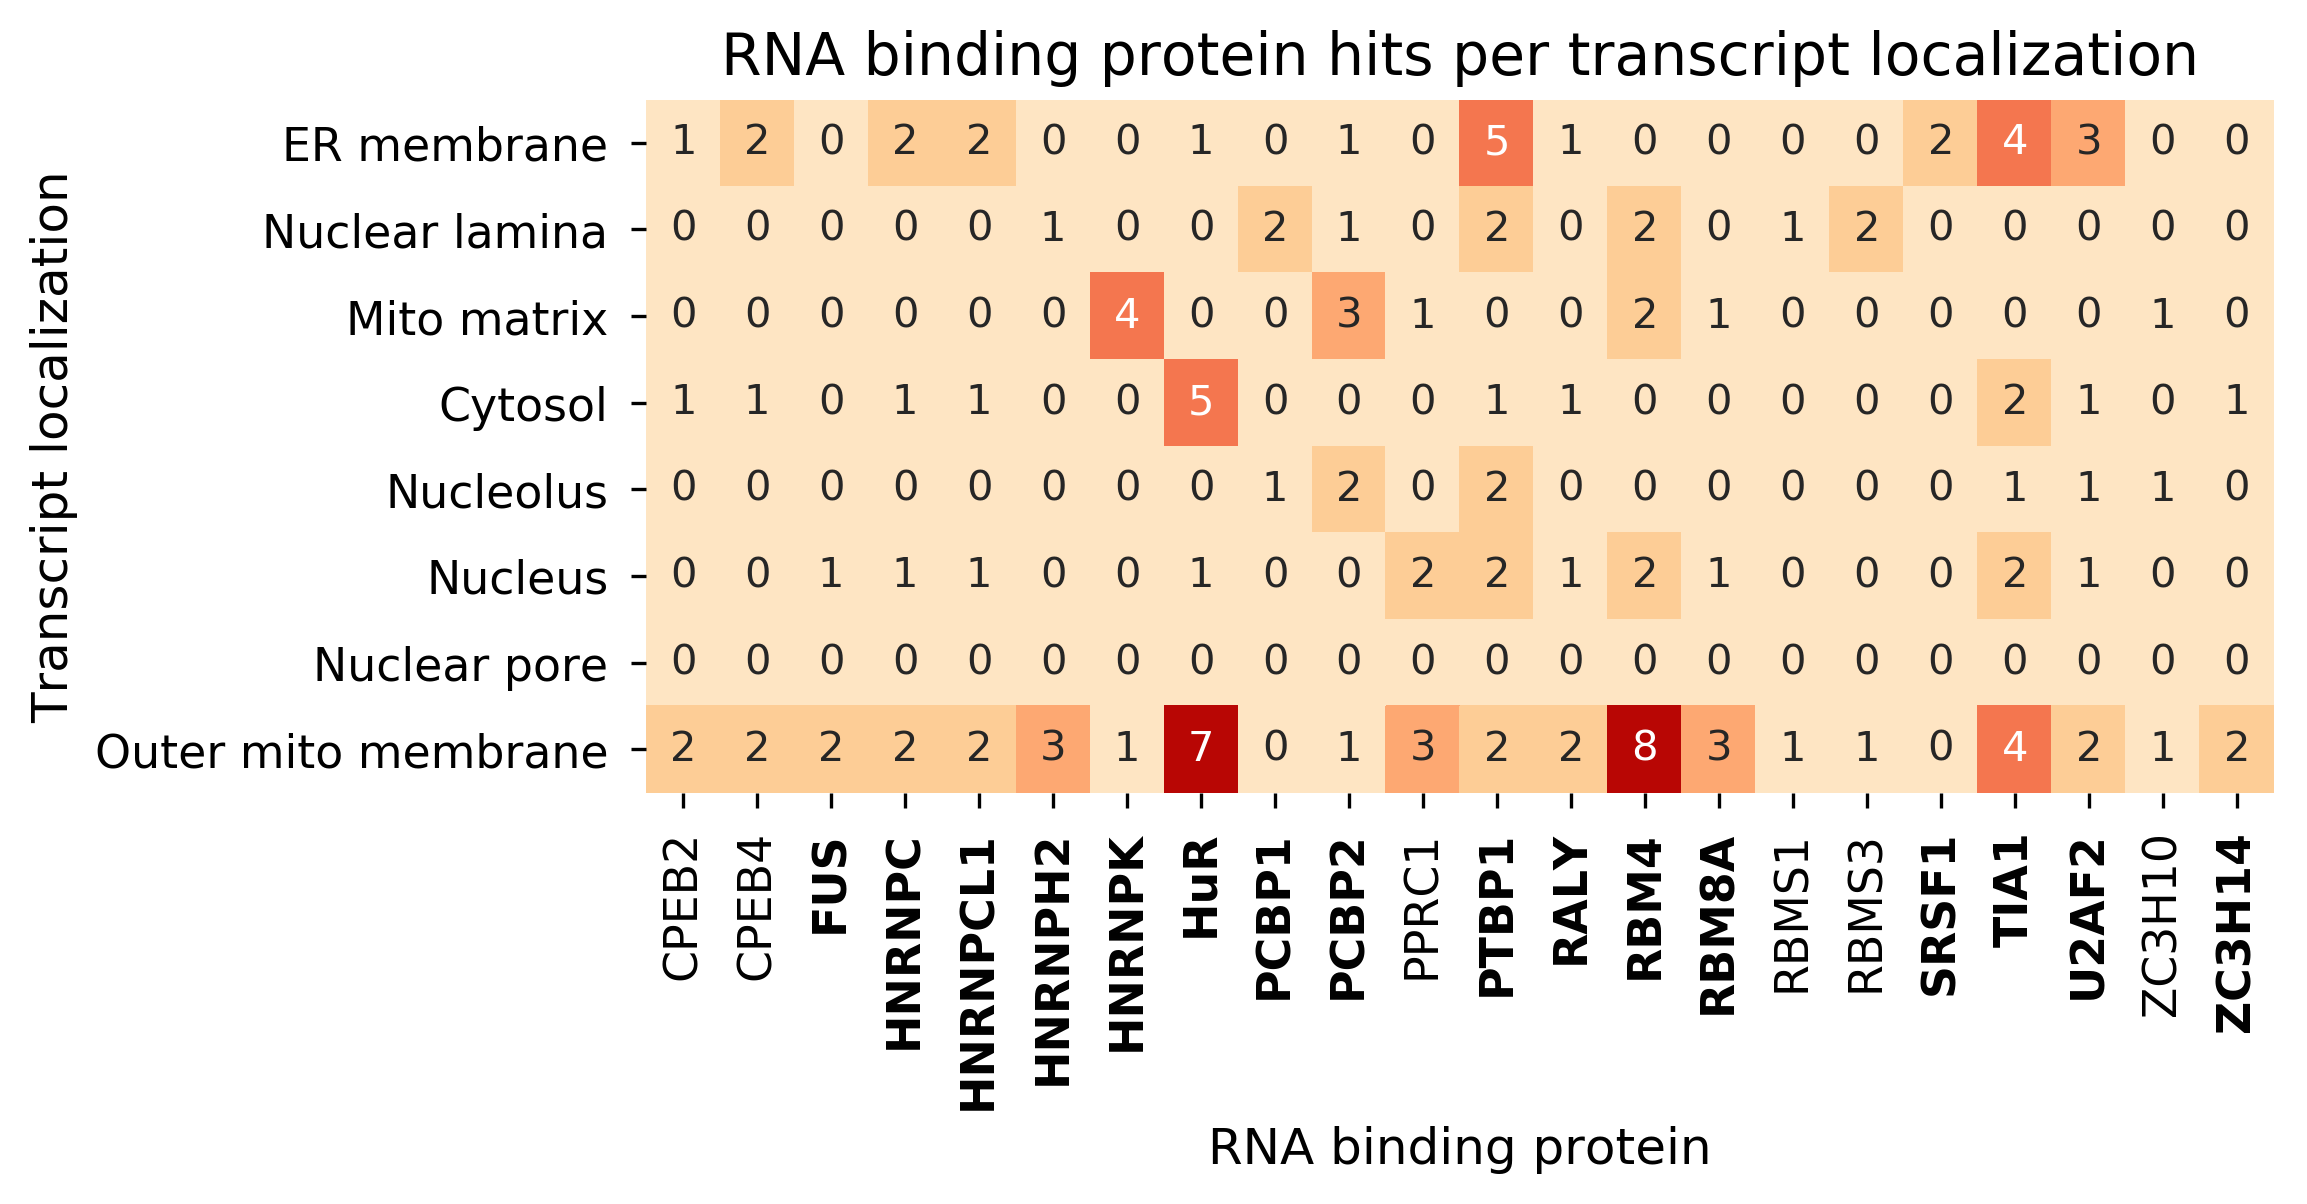

In [271]:
# TEST SET
known_splicing_rbps = [
    "HNRNPH2",
    "HuR",
    'LIN28A',
    "PCBP1",
    "PTBP1",
    "RBM4",
    "RBM5",
    "RBM8A",
    "SRSF1",
    "SRSF10",
    "SRSF9",
    "YBX1",
    "FUS",
    "HNRNPC",
    "HNRNPL",
    "HNRPLL",  # https://genomebiology.biomedcentral.com/articles/10.1186/gb-2014-15-1-r26
    "PABPC1",  # http://genesdev.cshlp.org/content/29/21/2298.full
    "PCBP2",   # https://onlinelibrary.wiley.com/doi/full/10.1002/jcp.26873
    "RALY",    # https://www.ncbi.nlm.nih.gov/pubmed/28733251
    "SART3",
    "SRSF2",   # https://www.ncbi.nlm.nih.gov/pubmed/29858584
    "TARDBP",  # https://www.genecards.org/cgi-bin/carddisp.pl?gene=TARDBP
    "TIA1",    # https://www.ncbi.nlm.nih.gov/pubmed/24566137
    "U2AF2",   # https://genome.cshlp.org/content/28/5/699.full
    "ZC3H14",  # https://mcb.asm.org/content/36/21/2697
    "HNRNPCL1",# https://www.genecards.org/cgi-bin/carddisp.pl?gene=HNRNPCL1
    "HNRNPK",
]

meme_hit_select_test_genes_counts = meme_hit_all_test_genes_counts.loc[:, np.sum(meme_hit_all_test_genes_counts, axis=0) > 1]
fig, ax = plt.subplots(dpi=300, figsize=(7, 3))
ax = sns.heatmap(
    meme_hit_select_test_genes_counts,
    annot=True,
    cbar=False,
    cmap=sns.color_palette("OrRd"),  # https://www.codecademy.com/articles/seaborn-design-ii
    ax=ax
)
ax.set(
    title="RNA binding protein hits per transcript localization",
    ylabel="Transcript localization",
    xlabel="RNA binding protein",
)
for i, txt in enumerate(list(ax.get_xticklabels())):
    rbp = txt._text
    if rbp in known_splicing_rbps:
        ax.get_xticklabels()[i].set_weight("bold")
fig.savefig(os.path.join(PLOT_DIR, "rf_kmer_assembly.pdf"), dpi=1200, bbox_inches='tight')
fig.show()

In [25]:
# In silico ablation study, TEST SET
importlib.reload(data_loader)
importlib.reload(interpretation)
random.seed(1234)

test_sequences_to_ablate = interpretation.read_motifs_from_tomtom(
    gap_1_tomtom_test_results,
    q_cutoff=0.05,
)
for compartment in test_sequences_to_ablate:
    print(compartment, len(list(itertools.chain.from_iterable(test_sequences_to_ablate[compartment].values()))))
    print(test_sequences_to_ablate[compartment])
# sequences_to_ablate = interpretation.generate_random_ablation_seqs(seed=848382)

test_ablation_orig_data = data_loader.load_kmer_dataset_ablated(test_dataset, test_sequences_to_ablate, mutate=False, random_ablation=False, ablation_strategy='N')
print(test_ablation_orig_data[0].shape)
test_ablation_mod_data = data_loader.load_kmer_dataset_ablated(test_dataset, test_sequences_to_ablate, mutate=True, random_ablation=False, ablation_strategy='N')
print(test_ablation_mod_data[0].shape)

INFO:root:CPU


Erm 5
{'cds': {'ATTTTCC', 'CTTTTTC', 'CTTCTTC', 'GGACGAG'}, 'u3': {'ACTTCCC'}, 'u5': set()}
Lma 5
{'cds': {'GGCCCGGGT'}, 'u3': {'ATATATAC', 'CTTTCCCA'}, 'u5': {'CCCTTACCCCCTGCCT', 'GGGAGGGGGCAA'}}
Mito 8
{'cds': {'CAGCGCG', 'CTTTCCCCAT'}, 'u3': {'TCCTACCCGGC', 'TTCCATCCCCTCTA', 'GCCAGCCC', 'ACACAGA', 'GTCCTACCCGG', 'TAGGGGCGCGGG'}, 'u5': set()}
Nes 1
{'cds': {'TTTCTTTA'}, 'u3': set(), 'u5': set()}
Nik 3
{'cds': {'CCTCCTC'}, 'u3': {'TCTTTCC'}, 'u5': {'GCACCGCCG'}}
Nls 7
{'cds': {'CGATACCCGCG', 'ATTTTCT', 'GAATCCAA'}, 'u3': set(), 'u5': {'TACAGCGTATCCTCACAACAGACAGT', 'AGCGCCCGCGCCCA', 'CCTGGGCGC', 'GGGCGCCGG'}}
NucPore 0
{'cds': set(), 'u3': set()}
Omm 12
{'cds': {'GGGAGGGCTA', 'AGCGCGG', 'GATAAAA'}, 'u3': {'TTTTTTTTTA', 'TATATAC', 'GGGAGGG', 'TTTTTTCT'}, 'u5': {'CCCAATCCC', 'CCCGCCC', 'CCGCCCGCG', 'CGCGCGC', 'GCCGCGCGGGGGCGGG'}}
(159, 4032)
(159, 4032)


In [26]:
test_ablation_orig_per_class_perfs = model_utils.generate_multiclass_perf(
    test_ablation_orig_data[1],
    rf_model.predict_proba(test_ablation_orig_data[0]),
    8
)
test_ablation_mod_per_class_perfs = model_utils.generate_multiclass_perf(
    test_ablation_mod_data[1],
    rf_model.predict_proba(test_ablation_mod_data[0]),
    8,
)

In [27]:
test_motif_ablated_t, test_motif_ablated_p = interpretation.compare_probs(
    rf_model.predict_proba(test_ablation_orig_data[0]),
    rf_model.predict_proba(test_ablation_mod_data[0]),
    np.where(test_ablation_orig_data[1]),
    test=scipy.stats.ttest_rel,
#     test=scipy.stats.wilcoxon,
)
test_motif_ablated_t, test_motif_ablated_p

(3.841048581397323, 0.00015029522292982138)

In [28]:
# TEST SET
importlib.reload(interpretation)
importlib.reload(data_loader)
np.random.seed(3828)
seeds = np.random.randint(0, 1000000, size=1000)

test_reference_preds = rf_model.predict_proba(test_ablation_orig_data[0])

rf_model.n_jobs = 1  # Avoid errors when parallelizing later
def get_t_val(seed, model=rf_model, dset=test_dataset, orig_data=test_ablation_orig_data, ablate_seq=test_sequences_to_ablate, ref_preds=test_reference_preds):
    test_ablation_rand_mod_data = data_loader.load_kmer_dataset_ablated(
        dset,
        ablate_seq,
        True,
        random_ablation=True,
        ablation_strategy='N',
        seed=seed,
    )
    t, p = interpretation.compare_probs(
        ref_preds,
        model.predict_proba(test_ablation_rand_mod_data[0]),
        idx=np.where(orig_data[1]),  # Compare only at positives
        test=scipy.stats.ttest_rel,
#         test=scipy.stats.wilcoxon,
    )
    return t
pool = multiprocessing.Pool(multiprocessing.cpu_count())
test_t_values = list(pool.imap(get_t_val, seeds, chunksize=10))
pool.close()
pool.join()
rf_model.n_jobs = multiprocessing.cpu_count()  # Restore parallelism

INFO:root:CPU


3.841048581397323
0.966


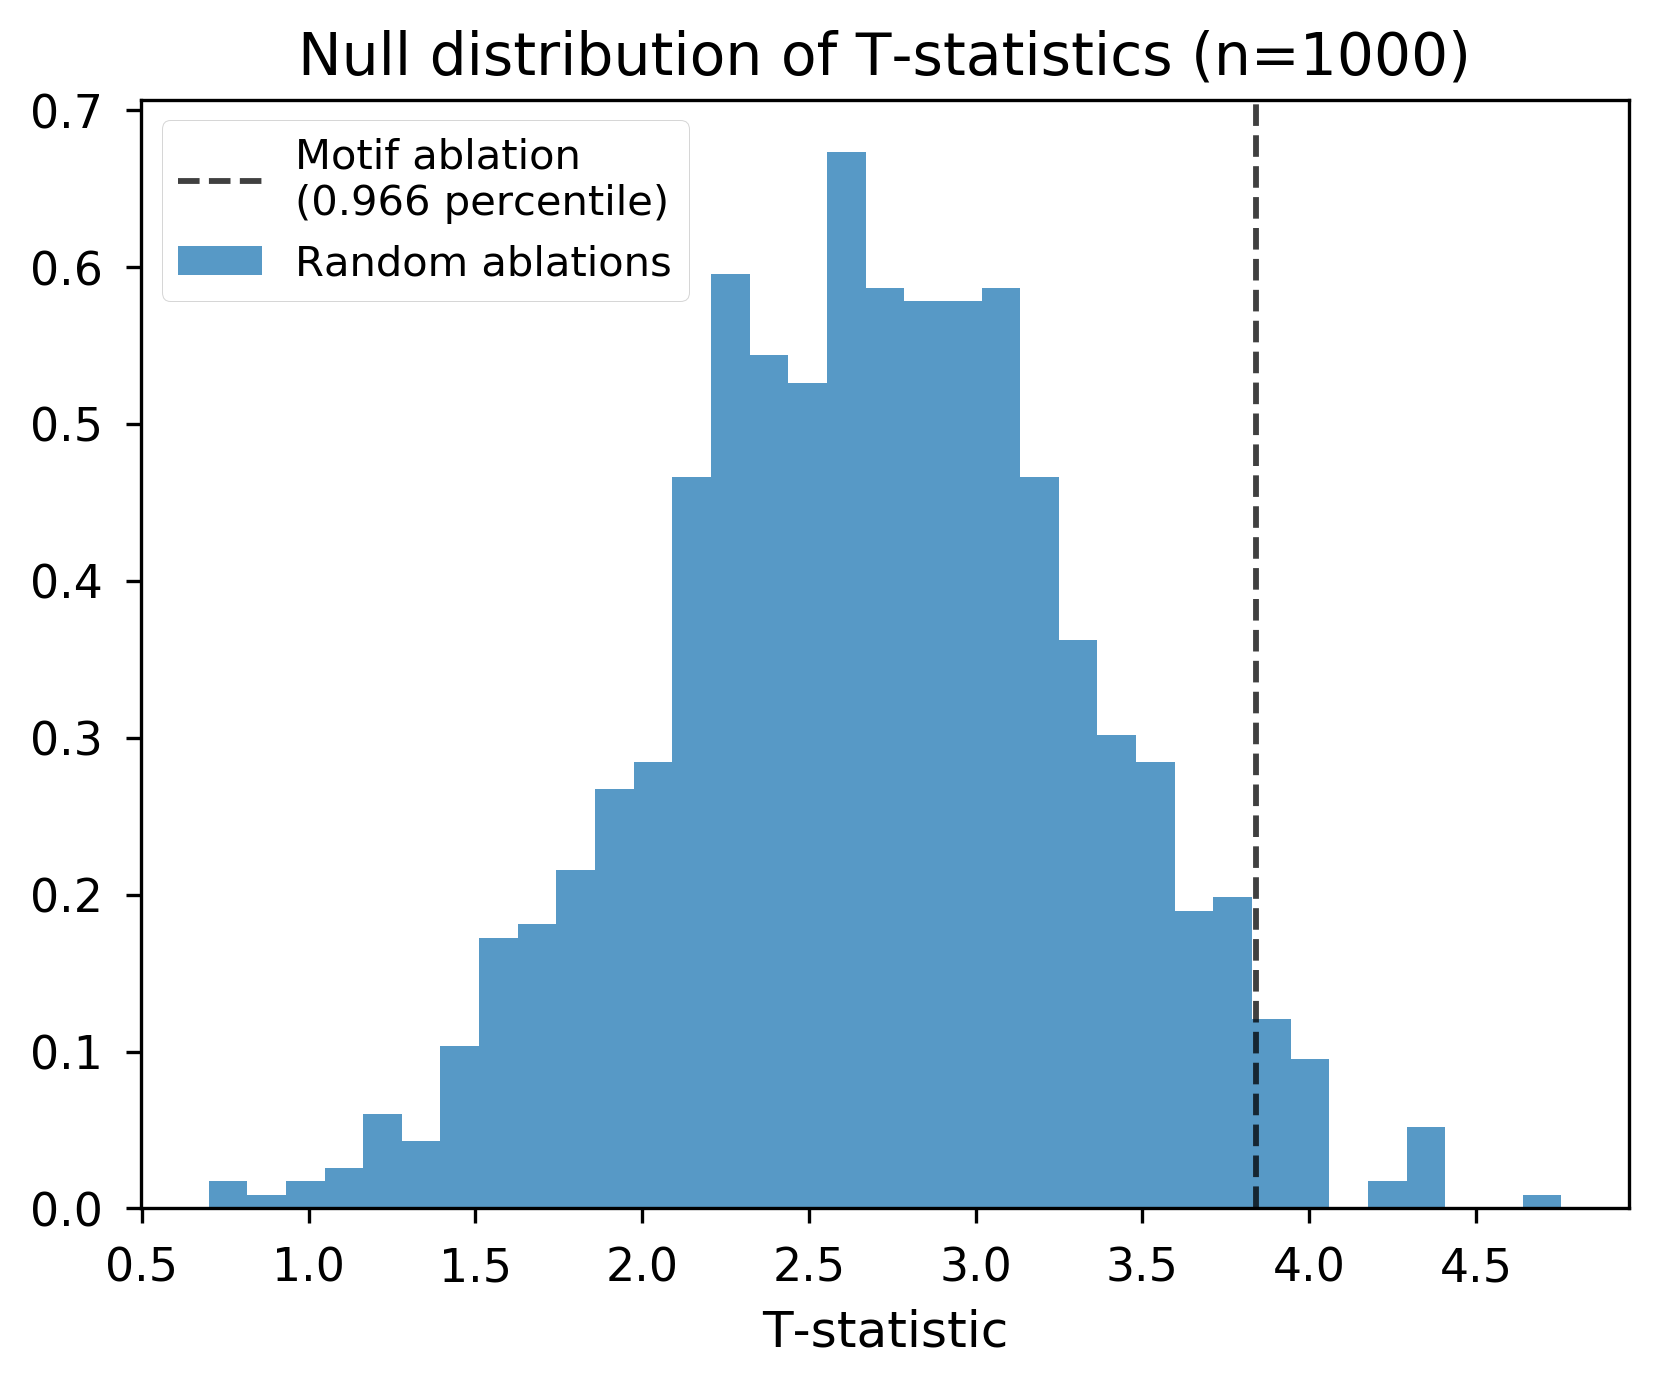

In [275]:
# TEST SET RANDOM ABLATION
fig, ax = plt.subplots(dpi=300, figsize=(8 * 0.8, 6 * 0.8))
_, t_bins, t_patches = ax.hist(test_t_values, bins=35, label="Random ablations", alpha=0.75, density=True)
# t_mean, t_sd = scipy.stats.norm.fit(t_values)
# t_pdf = scipy.stats.norm.pdf(t_bins, t_mean, t_sd)
print(test_motif_ablated_t)
percentile = 1 - np.sum(test_t_values > test_motif_ablated_t) / len(test_t_values)
print(percentile)
ax.axvline(test_motif_ablated_t, label=f"Motif ablation\n({percentile:.3f} percentile)", color='black', alpha=0.75, linestyle='--')
# ax.axvline(np.mean(t_values), label="Mean T-stat", color='salmon')
ax.set(
    xlabel="T-statistic",
#     ylabel="Count",
    title=f"Null distribution of T-statistics (n={len(test_t_values)})",
)
ax.legend(loc='upper left')
fig.savefig(os.path.join(PLOT_DIR, "rand_vs_targeted_ablation_test.pdf"), dpi=1200, bbox_inches='tight')
fig.show()

## Directly evaluate PWMs

In [30]:
import seq
import pwm
importlib.reload(seq)
importlib.reload(pwm)
importlib.reload(interpretation)

def save_dict_of_tables(dict_of_tables, tar_fname):
    """Saves the dictionary of tables to a tar file"""
    assert tar_fname.endswith(".tar")
    temp_folder = '.'.join(tar_fname.split(".")[:-1])
    assert not os.path.exists(temp_folder)
    os.makedirs(temp_folder)

    for k, v in dict_of_tables.items():
        v.to_csv(os.path.join(temp_folder, f"{k}.csv"))
    
    shutil.make_archive(tar_fname.rstrip(".tar"), 'tar', temp_folder)
    shutil.rmtree(temp_folder)

    return os.path.abspath(tar_fname)

def read_dict_of_tables(tar_fname):
    """Read a dictionary of dfs from a tar file"""
    temp_folder = '.'.join(tar_fname.split(".")[:-1])
    assert not os.path.exists(temp_folder)
    os.makedirs(temp_folder)
    
    shutil.unpack_archive(tar_fname, temp_folder)
    retval = {}
    for df_fname in glob.glob(os.path.join(temp_folder, "*.csv")):
        k = os.path.basename(df_fname).split(".")[0]
        v = pd.read_csv(df_fname, index_col=0, engine='c', low_memory=False)
        retval[k] = v
    shutil.rmtree(temp_folder)
    return retval

INFO:root:CPU


In [31]:
pwm_test_importance_tarball = os.path.join(INTERMEDIATE_DATA_DIR, "pwm_test_importance_N.tar")
print(pwm_test_importance_tarball)

/storage/wukevin/projects/rnagps/data/intermediate_kfold_5/pwm_test_importance_N.tar


In [32]:
if os.path.isfile(pwm_test_importance_tarball):
    pwm_test_importance = read_dict_of_tables(pwm_test_importance_tarball)
else:  # Calculate the PWM importance and save it
    pwm_test_importance = interpretation.evaluate_pwm_importance(
        rf_model,
        test_dataset,
        pwm.load_meme_ppm()
    )
    save_dict_of_tables(pwm_test_importance, pwm_test_importance_tarball)
    pwm_test_importance_reloaded = read_dict_of_tables(pwm_test_importance_tarball)
    for k in pwm_test_importance_reloaded.keys():
        assert np.allclose(pwm_test_importance_reloaded[k].values, pwm_test_importance[k].values, equal_nan=True)

In [33]:
for localization in test_dataset.compartments:
    print(localization, np.sum(~np.isnan(pwm_test_importance[localization].values)))

Erm 25501
Lma 12417
Mito 5948
Nes 5637
Nik 25549
Nls 13872
NucPore 2908
Omm 16295


In [242]:
pwm_08_test_importance_tarball = os.path.join(INTERMEDIATE_DATA_DIR, "pwm_test_08_importance_N.tar")
pwm_08_test_importance_tarball

'/storage/wukevin/projects/rnagps/data/intermediate_kfold_5/pwm_test_08_importance_N.tar'

In [243]:
if os.path.isfile(pwm_08_test_importance_tarball):
    pwm_08_test_importance = read_dict_of_tables(pwm_08_test_importance_tarball)
else:  # Calculate the PWM importance and save it
    pwm_08_test_importance = interpretation.evaluate_pwm_importance(
        rf_model,
        test_dataset,
        pwm.load_meme_ppm(),
        prop=0.8,
    )
    save_dict_of_tables(pwm_08_test_importance, pwm_08_test_importance_tarball)
    pwm_08_test_importance_reloaded = read_dict_of_tables(pwm_08_test_importance_tarball)
    for k in pwm_08_test_importance_reloaded.keys():
        assert np.allclose(pwm_08_test_importance_reloaded[k].values, pwm_08_test_importance[k].values, equal_nan=True)

In [34]:
pwm_importance_neg_counts = []
pwm_importance_average_impact = []
pwm_importance_sd_impact = []

for localization in test_dataset.compartments:
    # Select features with at least 2 nonzero hits, then find the average
    this_local_pwm_importance = pwm_test_importance[localization]
    # Negative impact and not NaN
    this_local_ft_neg = np.logical_and(~np.isnan(this_local_pwm_importance.values), this_local_pwm_importance.values < 0)
    this_local_ft_neg_count = np.sum(this_local_ft_neg, axis=0)
    pwm_importance_neg_counts.append(this_local_ft_neg_count)
    pwm_importance_average_impact.append(np.nanmean(this_local_pwm_importance, axis=0))
    pwm_importance_sd_impact.append(np.nanstd(this_local_pwm_importance, axis=0))

pwm_importance_average_impact = pd.DataFrame(
    pwm_importance_average_impact,
    index=valid_dataset.compartments,
    columns=pwm_test_importance['Erm'].columns,  # Just an example
)
pwm_importance_sd_impact = pd.DataFrame(
    pwm_importance_sd_impact,
    index=valid_dataset.compartments,
    columns=pwm_test_importance['Erm'].columns,  # Just an example
)
pwm_importance_neg_counts = pd.DataFrame(
    pwm_importance_neg_counts,
    index=valid_dataset.compartments,
    columns=pwm_test_importance['Erm'].columns,  # Just an example
)
pwm_importance_average_impact

/storage/wukevin/miniconda3/envs/rnafinder/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less
  # Remove the CWD from sys.path while we load stuff.
/storage/wukevin/miniconda3/envs/rnafinder/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]
/storage/wukevin/miniconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


u5_RNCMPT00001 A1CF  u5_RNCMPT00002 ANKHD1  u5_RNCMPT00004 BRUNOL4  \
Erm                 0.000453              -0.000008                0.000461   
Lma                -0.000239              -0.001150               -0.001744   
Mito               -0.000379              -0.001098                0.000167   
Nes                -0.000515              -0.001263                0.000171   
Nik                 0.001013               0.001759               -0.000699   
Nls                -0.000477              -0.001160                0.000016   
NucPore            -0.001806               0.003975               -0.000300   
Omm                 0.000520              -0.000317                0.000425   

         u5_RNCMPT00166 BRUNOL5  u5_RNCMPT00187 BRUNOL6  u5_RNCMPT00156 CNOT4  \
Erm                    0.000424               -0.000036             -0.000112   
Lma                   -0.001743               -0.001411              0.000293   
Mito                  -0.000847               -0.000013             -0.000917   
Nes                    0.000226               -0.000324             -0.000392   
Nik                   -0.000041               -0.000097             -0.000222   
Nls                    0.000217               -0.000113              0.000427   
NucPore               -0.000300                0.000458              0.000154   
Omm                    0.000996                0.000578             -0.000336   

         u5_RNCMPT00012 CPEB2  u5_RNCMPT00158 CPEB4  u5_RNCMPT00013 DAZAP1  \
Erm                 -0.001048              0.000340               0.000382   
Lma                  0.000368             -0.001240              -0.001824   
Mito                -0.002087             -0.003565              -0.001847   
Nes                 -0.001292             -0.001217              -0.001248   
Nik                 -0.001891             -0.001452              -0.000920   
Nls                 -0.000586             -0.002523              -0.001262   
NucPore              0.001133              0.001788               0.000411   
Omm                 -0.000749             -0.000782              -0.000618   

         u5_RNCMPT00149 ENOX1  ...  u3_RNCMPT00077 TIA1  u3_RNCMPT00075 TUT1  \
Erm                 -0.000946  ...            -0.006501            -0.007724   
Lma                 -0.000428  ...            -0.005574            -0.009327   
Mito                 0.000391  ...            -0.001918             0.000651   
Nes                  0.001753  ...            -0.003822            -0.000952   
Nik                 -0.000761  ...            -0.002243            -0.003287   
Nls                 -0.001008  ...            -0.001839            -0.001752   
NucPore             -0.000083  ...            -0.002177             0.001325   
Omm                 -0.000503  ...            -0.003920            -0.001888   

         u3_RNCMPT00079 U2AF2  u3_RNCMPT00116 YBX1  u3_RNCMPT00083 YBX1  \
Erm                 -0.004964            -0.003641            -0.002991   
Lma                 -0.004736            -0.004035            -0.002781   
Mito                -0.002533            -0.003337            -0.004253   
Nes                 -0.004967            -0.000182            -0.002166   
Nik                 -0.000225            -0.001052            -0.001858   
Nls                 -0.001432            -0.003749            -0.002094   
NucPore             -0.001304            -0.003711            -0.002733   
Omm                 -0.003843            -0.002804            -0.002876   

         u3_RNCMPT00084 YBX2  u3_RNCMPT00085 ZC3H10  u3_RNCMPT00086 ZC3H14  \
Erm                -0.003425              -0.001653              -0.011931   
Lma                -0.004908              -0.002805              -0.010552   
Mito               -0.001416              -0.000247              -0.003069   
Nes                -0.002919              -0.004705              -0.004429   
Nik                -0.002098              -0.001160              -0.002397   

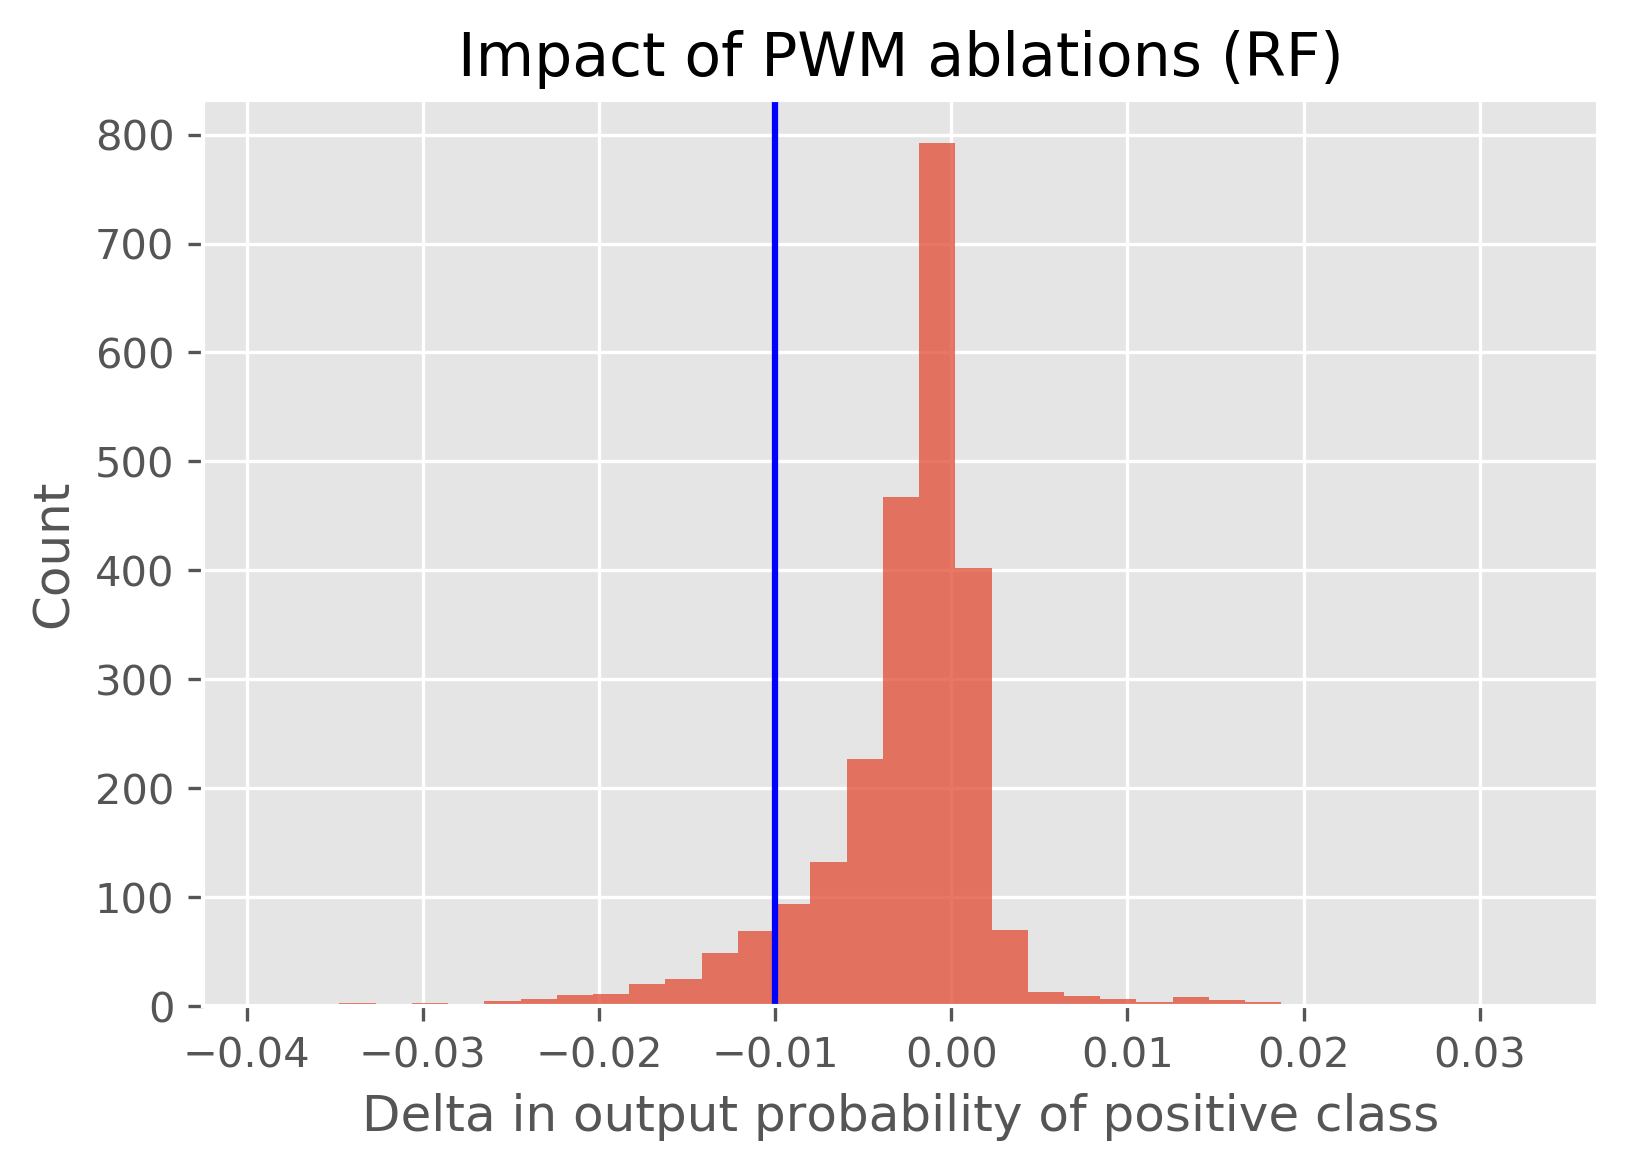

In [35]:
fig, ax = plt.subplots(dpi=300)
ax.hist(pwm_importance_average_impact.values[~np.isnan(pwm_importance_average_impact.values)], bins=35, alpha=0.75)
ax.set(
    xlabel="Delta in output probability of positive class",
    ylabel="Count",
    title="Impact of PWM ablations (RF)",
)
ax.grid(True)
ax.axvline(-0.01, color='blue')
fig.show()

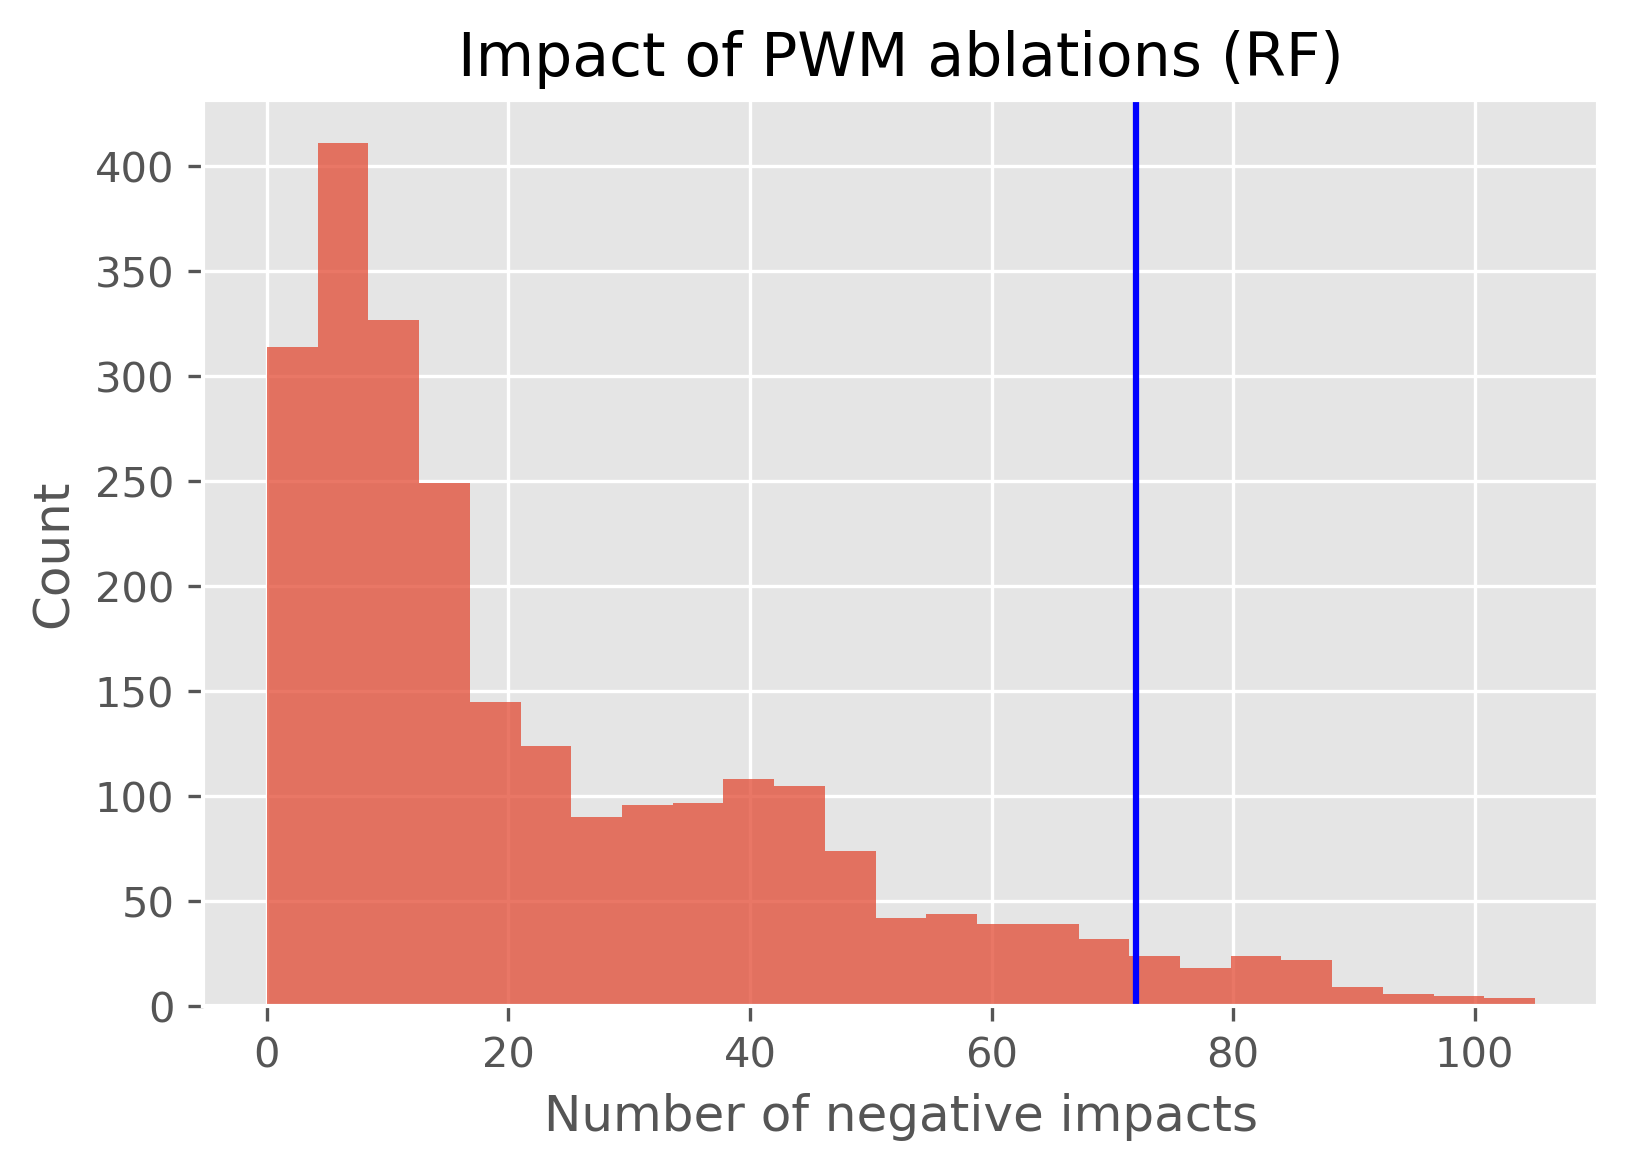

In [36]:
fig, ax = plt.subplots(dpi=300)
ax.hist(pwm_importance_neg_counts.values[~np.isnan(pwm_importance_neg_counts.values)], bins=25, alpha=0.75)
ax.set(
    xlabel="Number of negative impacts",
    ylabel="Count",
    title="Impact of PWM ablations (RF)",
)
ax.grid(True)
ax.axvline(72, color='blue')
fig.show()

In [37]:
for local_idx, ft_idx in zip(*np.where(pwm_importance_neg_counts.values >= 50)):
    localization = pwm_importance_average_impact.index[local_idx]
    trans_part, pwm_name = pwm_importance_average_impact.columns[ft_idx].split("_")
    _name, gene_name = pwm_name.split()
    print(localization, trans_part, pwm_name)

Erm cds RNCMPT00004 BRUNOL4
Erm cds RNCMPT00166 BRUNOL5
Erm cds RNCMPT00187 BRUNOL6
Erm cds RNCMPT00012 CPEB2
Erm cds RNCMPT00158 CPEB4
Erm cds RNCMPT00150 ESRP2
Erm cds RNCMPT00025 HNRNPC
Erm cds RNCMPT00167 HNRNPCL1
Erm cds RNCMPT00160 HNRNPH2
Erm cds RNCMPT00026 HNRNPK
Erm cds RNCMPT00091 HNRNPL
Erm cds RNCMPT00112 HuR
Erm cds RNCMPT00117 HuR
Erm cds RNCMPT00136 HuR
Erm cds RNCMPT00032 HuR
Erm cds RNCMPT00274 HuR
Erm cds RNCMPT00172 IGF2BP3
Erm cds RNCMPT00037 MATR3
Erm cds RNCMPT00038 MBNL1
Erm cds RNCMPT00186 PCBP1
Erm cds RNCMPT00044 PCBP2
Erm cds RNCMPT00045 PPRC1
Erm cds RNCMPT00268 PTBP1
Erm cds RNCMPT00269 PTBP1
Erm cds RNCMPT00047 QKI
Erm cds RNCMPT00159 RALY
Erm cds RNCMPT00184 RBM24
Erm cds RNCMPT00113 RBM4
Erm cds RNCMPT00053 RBM41
Erm cds RNCMPT00151 RBM42
Erm cds RNCMPT00054 RBM46
Erm cds RNCMPT00170 RBM6
Erm cds RNCMPT00056 RBM8A
Erm cds RNCMPT00152 RBMS1
Erm cds RNCMPT00173 RBMS3
Erm cds RNCMPT00057 RBMS3
Erm cds RNCMPT00063 SAMD4A
Erm cds RNCMPT00177 SFPQ
Erm cds RNC

In [38]:
pwm_importance_desired_indices = np.logical_and(
    np.logical_and(pwm_importance_average_impact.values <= -0.01, pwm_importance_neg_counts.values >= 5),
#     np.logical_and(~np.isnan(pwm_importance_average_impact.values), pwm_importance_sd_impact.values <= 0.005)
    ~np.isnan(pwm_importance_average_impact.values)
)
pwm_importance_desired_indices = np.logical_or(
    pwm_importance_desired_indices,
    pwm_importance_neg_counts.values >= 72
)
np.sum(pwm_importance_desired_indices)

/storage/wukevin/miniconda3/envs/rnafinder/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less_equal
  


245

In [146]:
pwm_importance_rbps = {l: list() for l in valid_dataset.compartments}  # Genes
pwm_importance_rbps_ids = {l: list() for l in valid_dataset.compartments}  # Ids
pwm_importance_rbps_ids_by_trans_part = collections.defaultdict(list)
pwm_importance_hit_locations = pd.DataFrame(
    0,
    index=valid_dataset.compartments,
    columns=['u5', 'cds', 'u3'],
)
for local_idx, ft_idx in zip(*np.where(pwm_importance_desired_indices)):
    localization = pwm_importance_average_impact.index[local_idx]
    trans_part, pwm_name = pwm_importance_average_impact.columns[ft_idx].split("_")
    id_name, gene_name = pwm_name.split()
    pwm_importance_rbps[localization].append(gene_name)  # Allows multiple hits of the same gene name
    pwm_importance_rbps_ids[localization].append(id_name)
    pwm_importance_rbps_ids_by_trans_part[localization + "_" + trans_part].append(id_name)
    pwm_importance_hit_locations.loc[localization, trans_part] += 1

all_genes = sorted(list(set(itertools.chain.from_iterable(pwm_importance_rbps.values()))))
all_genes_counts = pd.DataFrame(
    0,
    index=valid_dataset.compartments,
    columns=all_genes,
)
for localization, genes in pwm_importance_rbps.items():
    for gene in genes:
        all_genes_counts.loc[localization, gene] += 1

importlib.reload(data_loader)
all_genes_counts.index = [data_loader.LOCALIZATION_FULL_NAME_DICT[l] for l in all_genes_counts.index]
all_genes_counts.head(8)

BRUNOL4  BRUNOL5  BRUNOL6  CNOT4  CPEB2  CPEB4  DAZAP1  \
ER membrane                2        2        2      0      1      1       1   
Nuclear lamina             1        0        1      0      0      0       1   
Mito matrix                0        0        0      0      0      0       0   
Cytosol                    0        0        0      0      0      0       0   
Nucleolus                  0        0        0      1      0      0       0   
Nucleus                    0        0        1      0      0      0       0   
Nuclear pore               0        0        0      0      0      0       0   
Outer mito membrane        1        1        1      0      1      0       0   

                     ENOX1  ESRP2  FMR1  ...  SRSF2  SRSF9  TARDBP  TIA1  \
ER membrane              1      2     0  ...      1      2       1     3   
Nuclear lamina           2      1     1  ...      2      4       0     0   
Mito matrix              0      0     0  ...      0      1       0     0   
Cytosol                  0      0     0  ...      1      3       0     0   
Nucleolus                1      0     1  ...      1      2       0     0   
Nucleus                  0      1     0  ...      1      3       0     0   
Nuclear pore             0      0     0  ...      0      0       0     0   
Outer mito membrane      0      1     0  ...      0      0       0     0   

                     TUT1  U2AF2  YBX2  ZC3H10  ZC3H14  ZNF638  
ER membrane             1      2     0       0       2       2  
Nuclear lamina          0      0     0       1       1       0  
Mito matrix             0      0     0       0       0       0  
Cytosol                 0      0     0       1       0       0  
Nucleolus               0      0     1       0       0       0  
Nucleus                 0      0     0       1       0       0  
Nuclear pore            0      0     0       0       0       0  
Outer mito membrane     0      0     0       0       1       1  

[8 rows x 55 columns]

In [40]:
all_genes_counts.sum(axis=0)

BRUNOL4       4
BRUNOL5       3
BRUNOL6       5
CNOT4         1
CPEB2         2
CPEB4         1
DAZAP1        2
ENOX1         4
ESRP2         5
FMR1          2
FXR2          1
HNRNPA1L2     2
HNRNPA2B1     1
HNRNPH2       2
HNRNPL        4
HuR          16
IGF2BP2       4
IGF2BP3       4
KHDRBS1       3
KHDRBS2       3
LIN28A       12
MATR3         3
MBNL1         2
MSI1          3
PABPC1        4
PABPC3        2
PABPC4        4
PABPC5        4
PABPN1        5
PCBP1         1
PCBP2         5
PTBP1         8
RALY          1
RBM3          3
RBM45         2
RBM46         3
RBM5         12
RBM6          1
RBMS3         2
SAMD4A        1
SART3         4
SFPQ          5
SNRNP70       1
SRSF1        28
SRSF10       21
SRSF2         6
SRSF9        15
TARDBP        1
TIA1          3
TUT1          1
U2AF2         2
YBX2          1
ZC3H10        3
ZC3H14        4
ZNF638        3
dtype: int64

In [41]:
# For DAVID
' '.join(all_genes_counts.columns)

'BRUNOL4 BRUNOL5 BRUNOL6 CNOT4 CPEB2 CPEB4 DAZAP1 ENOX1 ESRP2 FMR1 FXR2 HNRNPA1L2 HNRNPA2B1 HNRNPH2 HNRNPL HuR IGF2BP2 IGF2BP3 KHDRBS1 KHDRBS2 LIN28A MATR3 MBNL1 MSI1 PABPC1 PABPC3 PABPC4 PABPC5 PABPN1 PCBP1 PCBP2 PTBP1 RALY RBM3 RBM45 RBM46 RBM5 RBM6 RBMS3 SAMD4A SART3 SFPQ SNRNP70 SRSF1 SRSF10 SRSF2 SRSF9 TARDBP TIA1 TUT1 U2AF2 YBX2 ZC3H10 ZC3H14 ZNF638'

(8, 55)


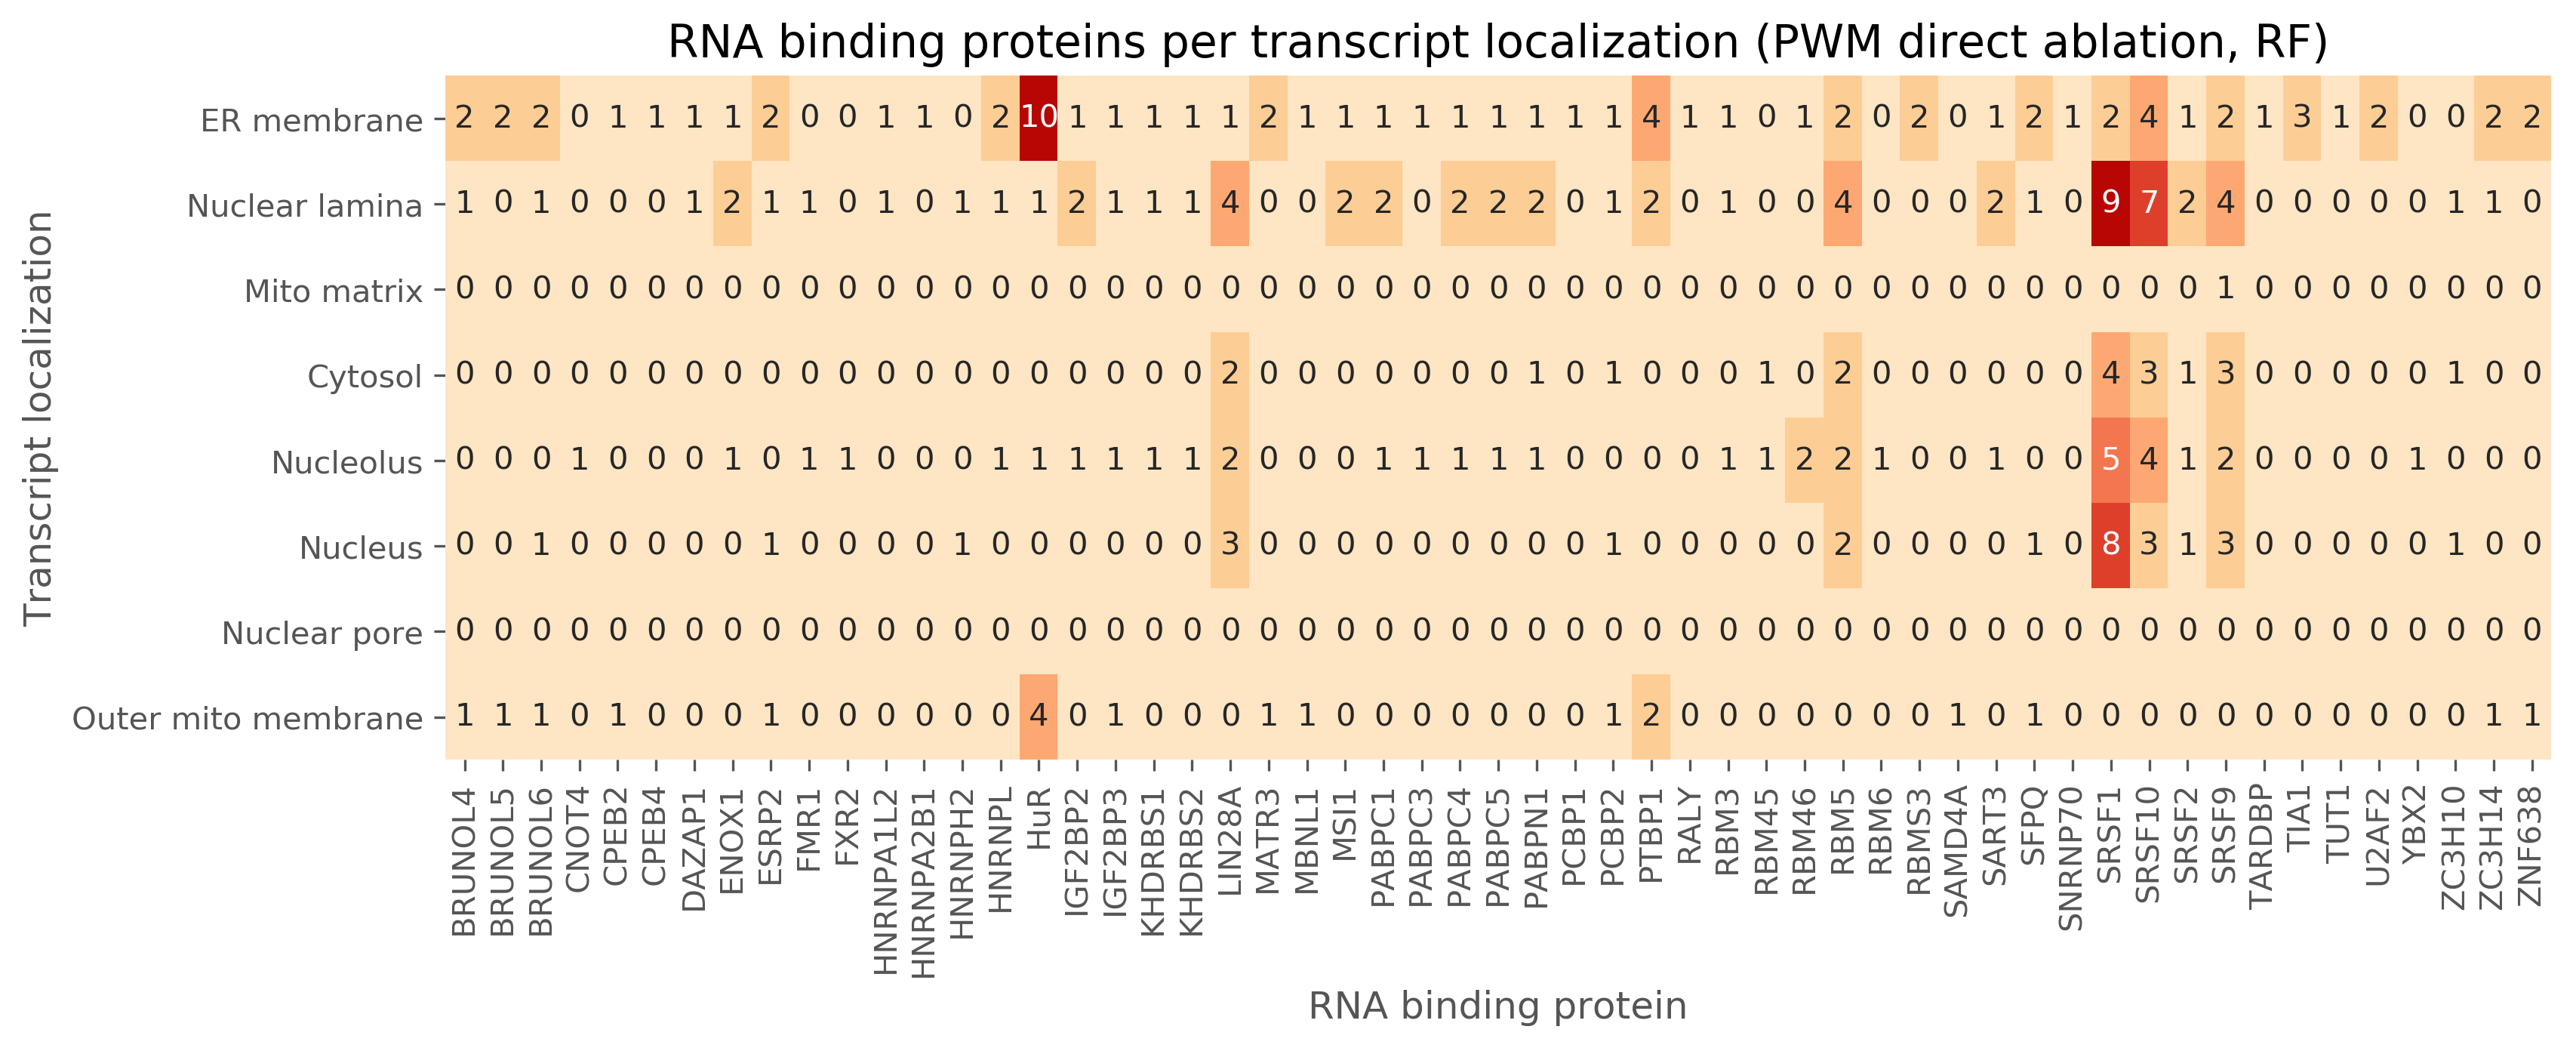

In [42]:
print(all_genes_counts.shape)
fig, ax = plt.subplots(dpi=300, figsize=(12, 4))
ax = sns.heatmap(all_genes_counts, annot=True, cbar=False, ax=ax, cmap=sns.color_palette("OrRd"))
ax.set(
    title="RNA binding proteins per transcript localization (PWM direct ablation, RF)",
    ylabel="Transcript localization",
    xlabel="RNA binding protein",
)
fig.show()

PWM direct ablation, RF
(8, 43)


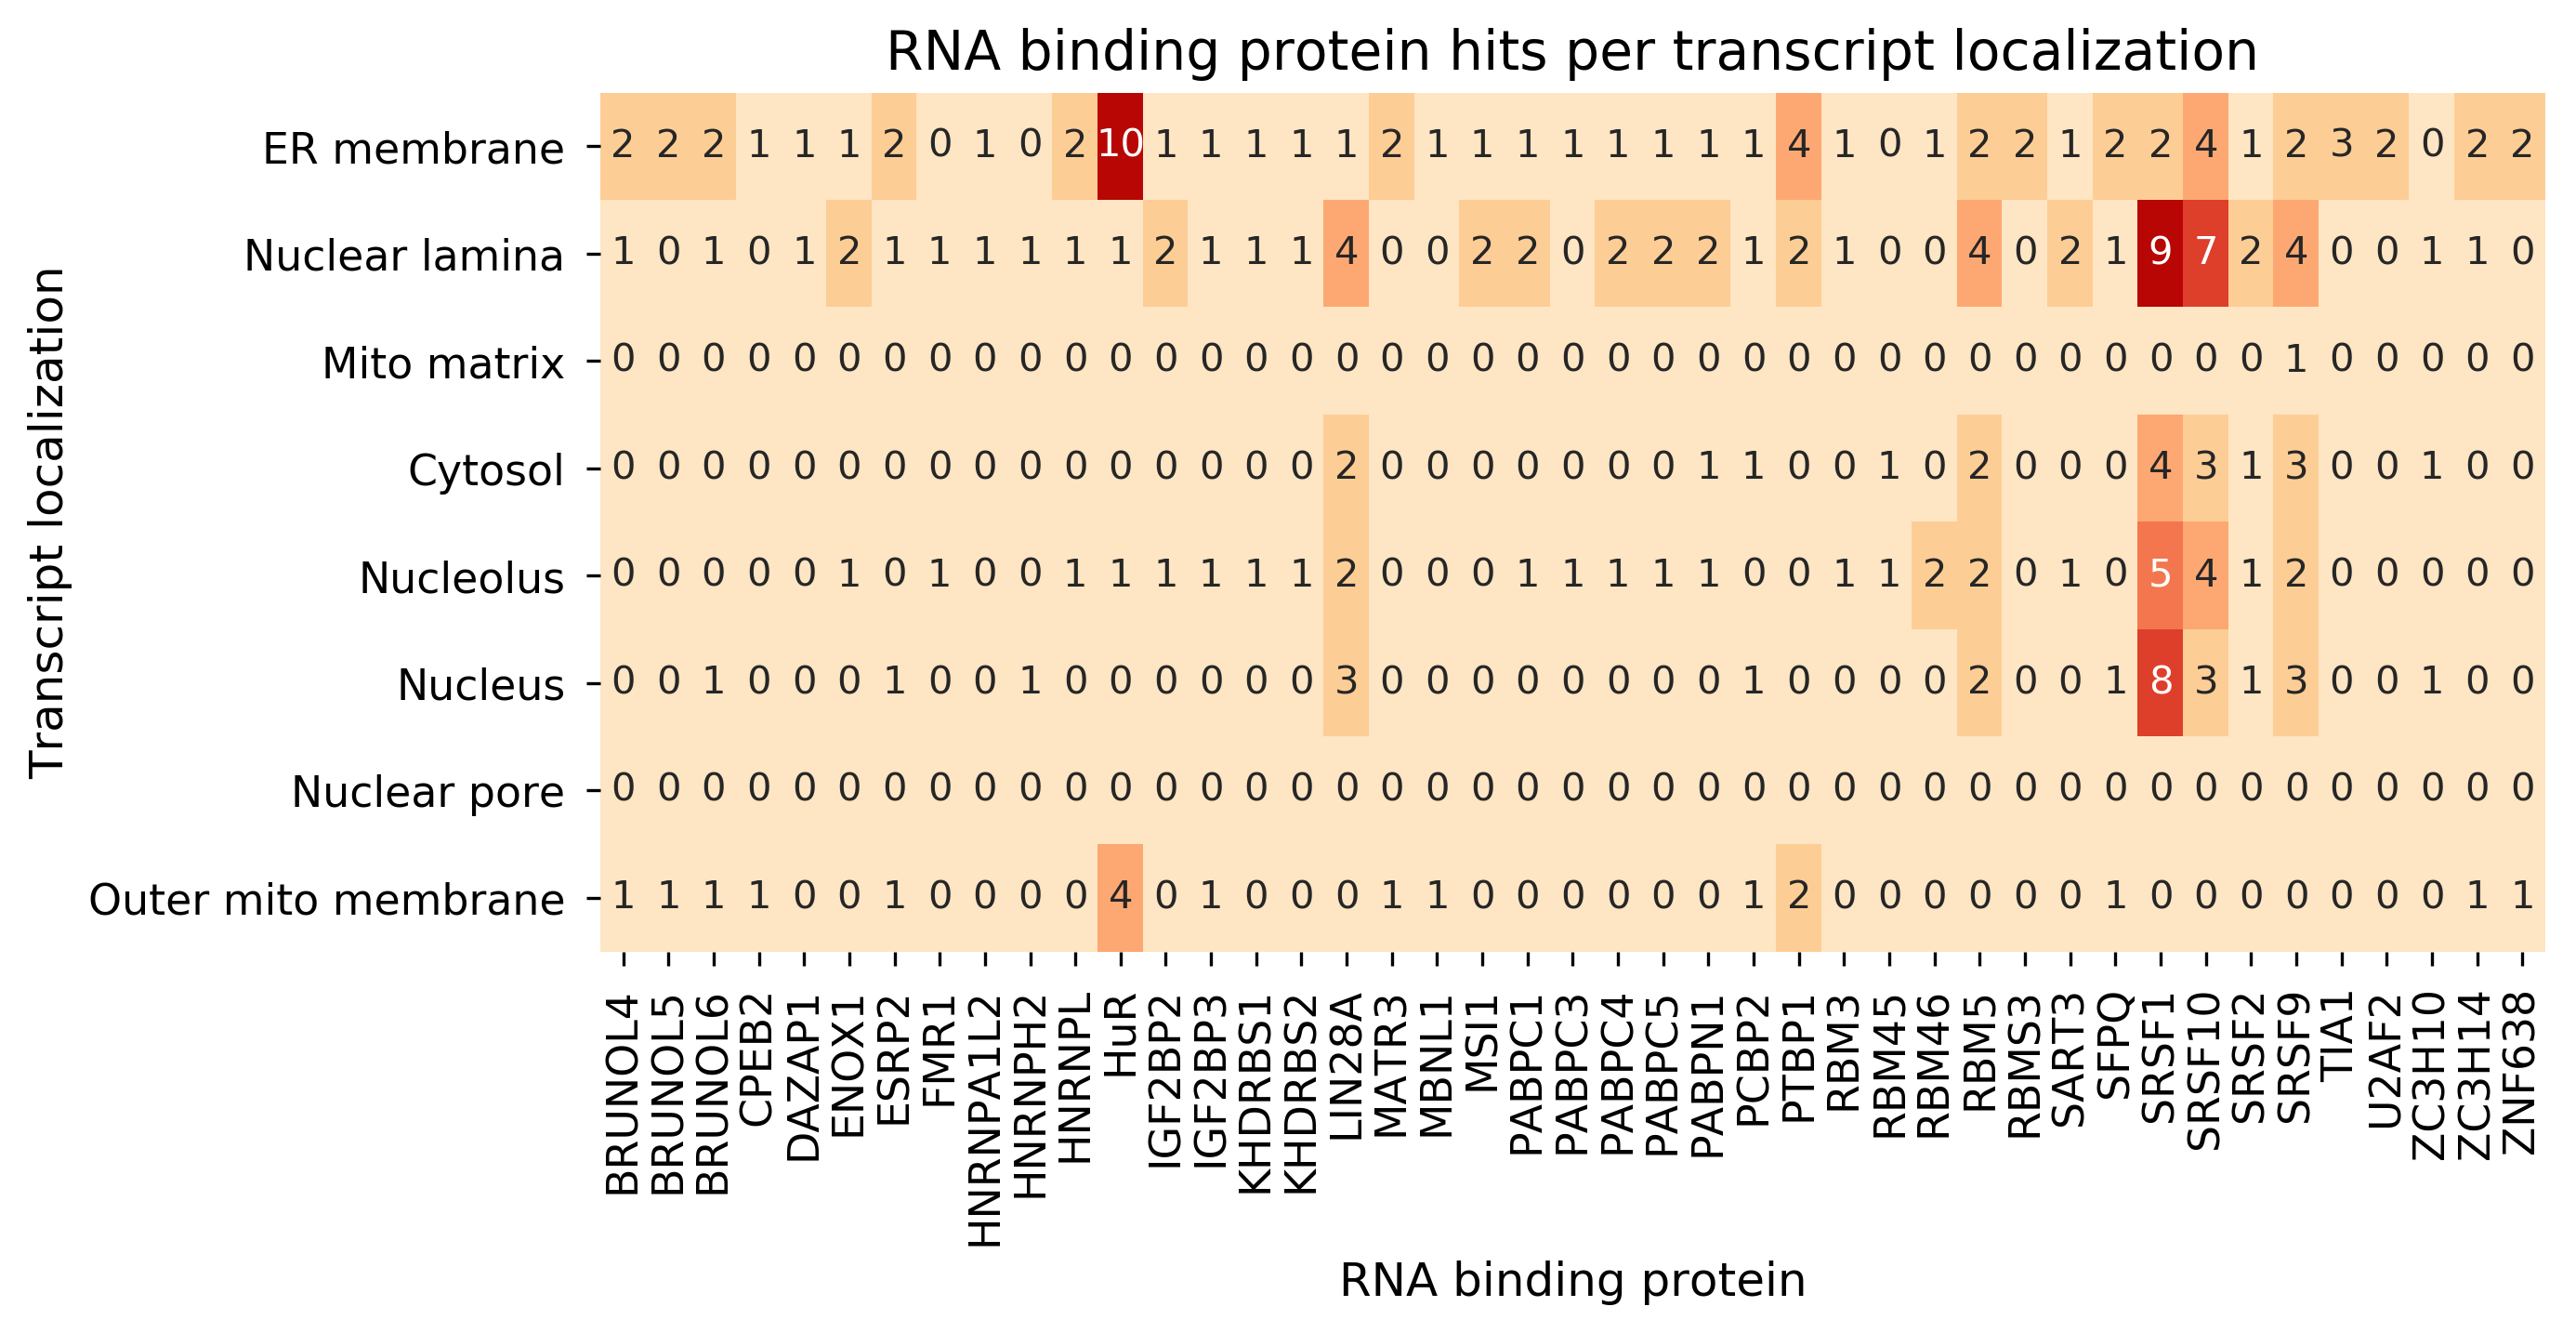

In [272]:
print("PWM direct ablation, RF")
select_genes_counts = all_genes_counts.loc[:, np.sum(all_genes_counts, axis=0) > 1]
print(select_genes_counts.shape)
fig, ax = plt.subplots(dpi=300, figsize=(9, 4))
ax = sns.heatmap(select_genes_counts, annot=True, cbar=False, ax=ax, cmap=sns.color_palette("OrRd"),)
ax.set(
    title="RNA binding protein hits per transcript localization",
    ylabel="Transcript localization",
    xlabel="RNA binding protein",
)
fig.savefig(os.path.join(PLOT_DIR, "rf_pwm_ablation.pdf"), dpi=1200, bbox_inches='tight')
fig.show()

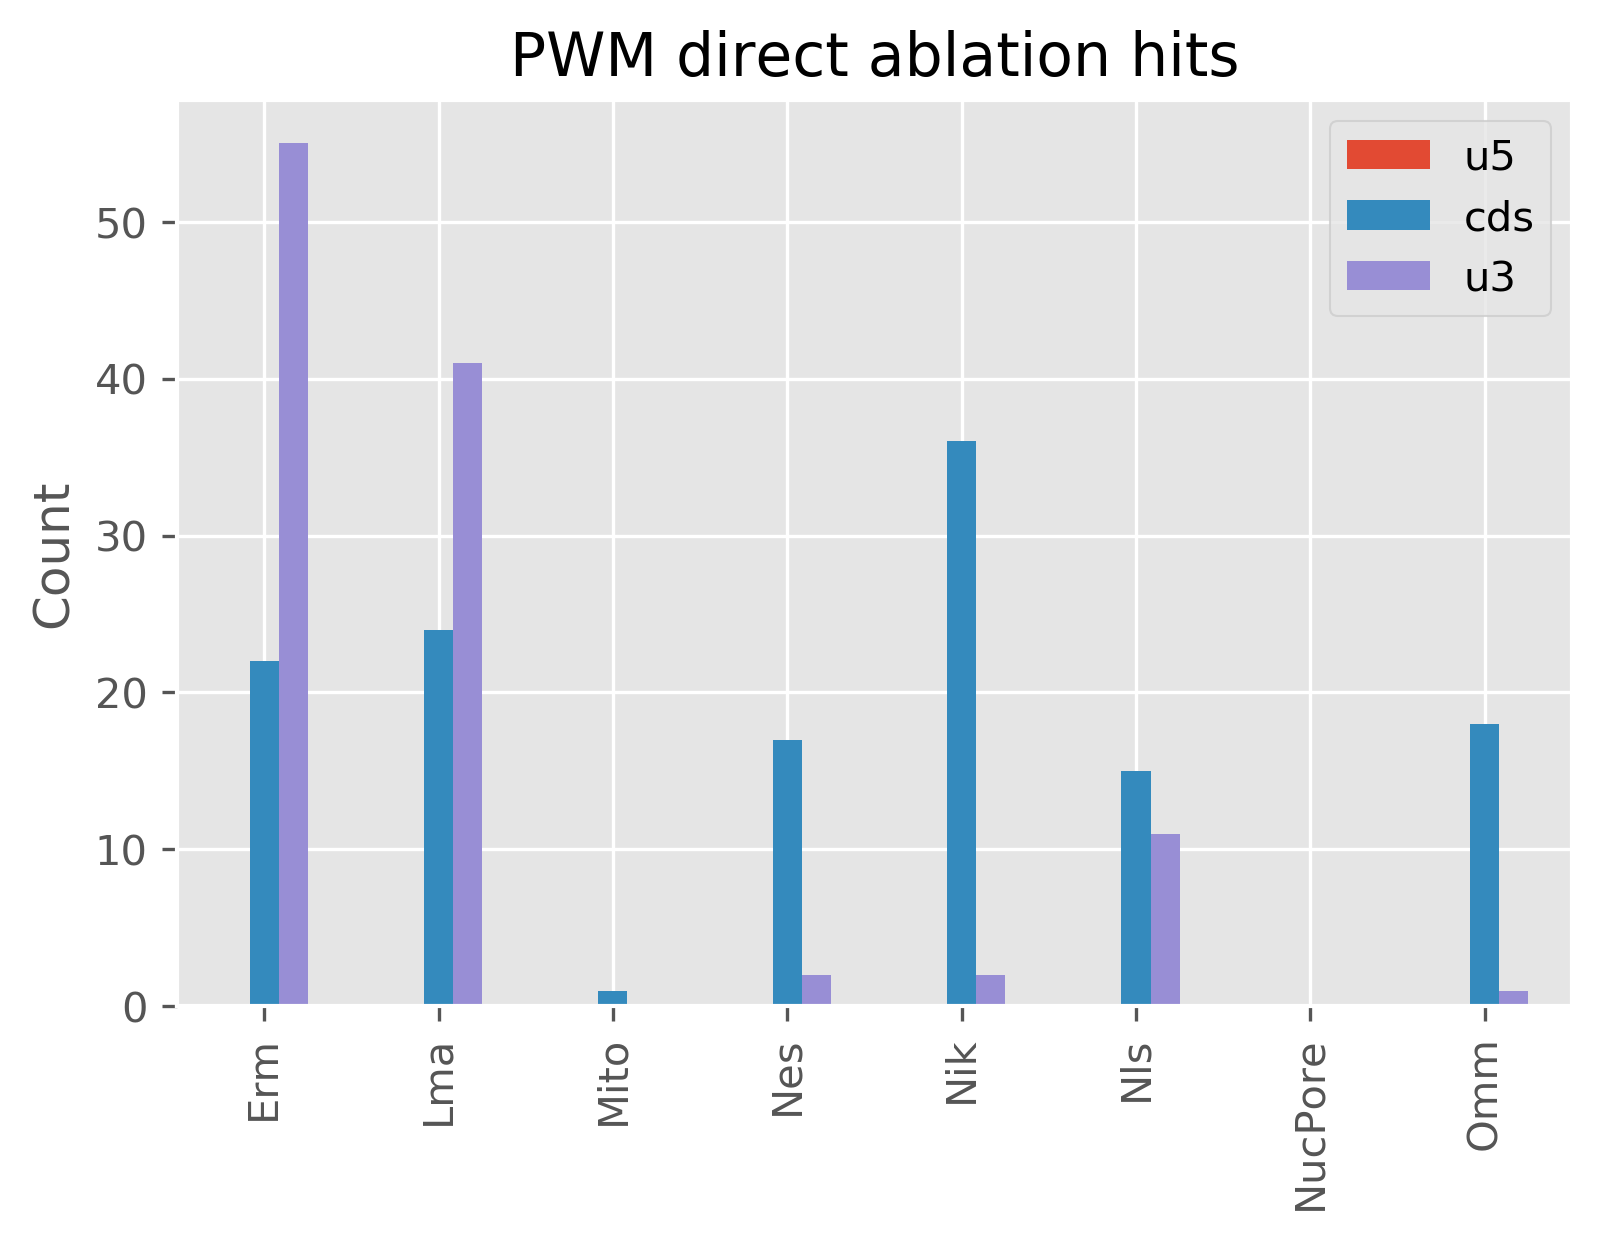

In [44]:
fig, ax = plt.subplots(dpi=300)
pwm_importance_hit_locations.plot.bar(ax=ax)
ax.set(
    ylabel="Count",
    title="PWM direct ablation hits"
)
fig.show()

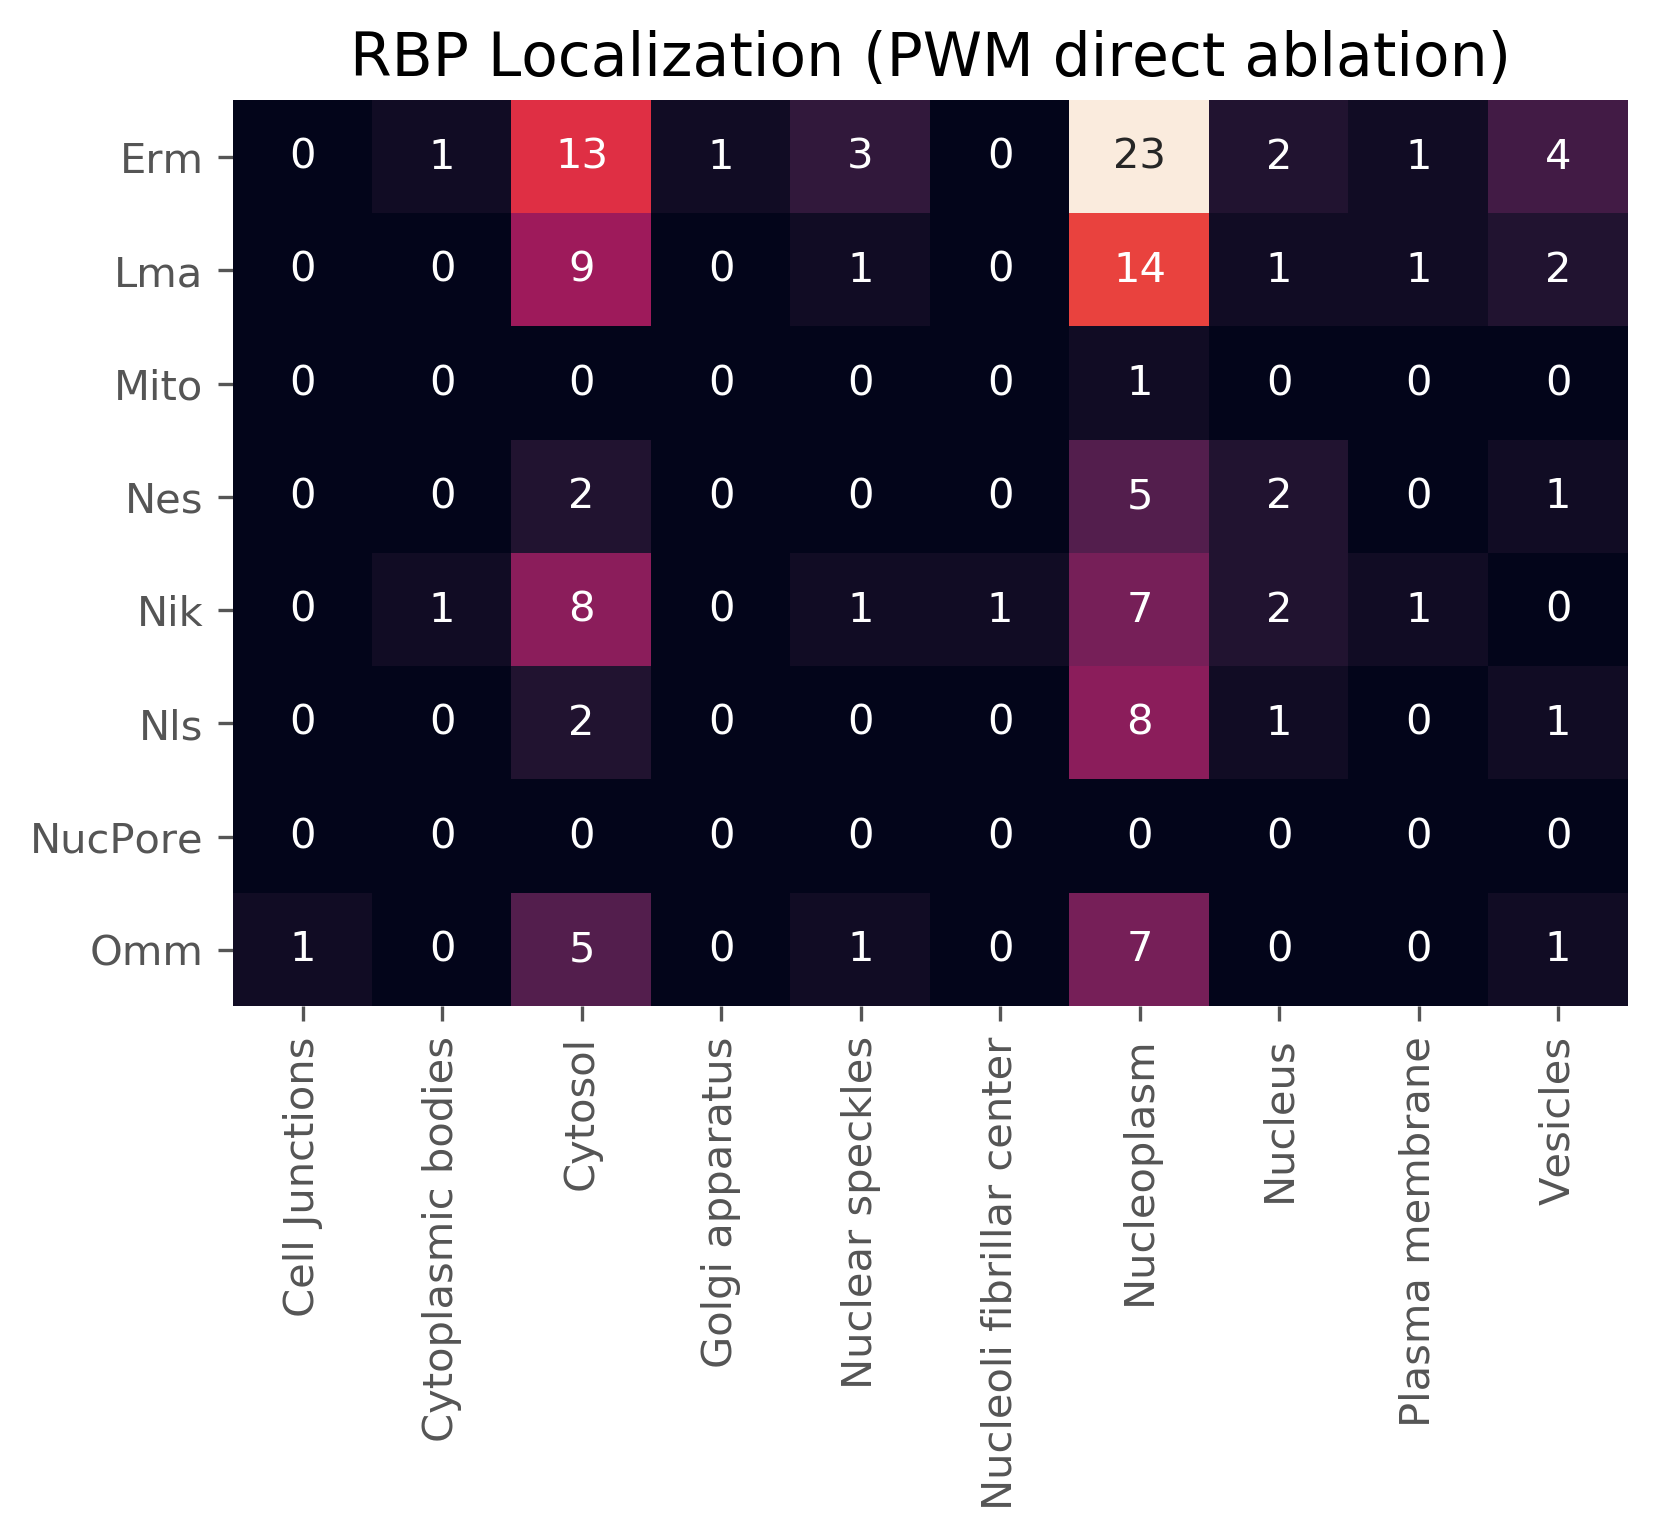

In [46]:
pwm_importance_rbp_localizations = localization_rbp_to_rbp_localization(pwm_importance_rbps, unique_genes=True)
fig, ax = plt.subplots(dpi=300)
ax = sns.heatmap(pwm_importance_rbp_localizations, annot=True, cbar=False, ax=ax)
ax.set(
    title="RBP Localization (PWM direct ablation)",
)
fig.show()

In [251]:
## Importance for reduced threshold 0.8
importlib.reload(interpretation)
all_0pt8_genes_counts = interpretation.pwm_importance_to_significant_hits(
    pwm_08_test_importance
)
all_0pt8_genes_counts

INFO:root:CPU
/storage/wukevin/projects/rnagps/rnagps/interpretation.py:286: RuntimeWarning: invalid value encountered in less
  this_local_ft_neg_count = np.sum(this_local_ft_neg, axis=0)
/storage/wukevin/projects/rnagps/rnagps/interpretation.py:291: RuntimeWarning: Mean of empty slice
  
/storage/wukevin/projects/rnagps/rnagps/interpretation.py:312: RuntimeWarning: invalid value encountered in less_equal
  ),


BRUNOL4  BRUNOL5  BRUNOL6  CNOT4  CPEB2  CPEB4  DAZAP1  \
ER membrane                2        2        2      0      2      2       1   
Nuclear lamina             1        0        1      0      0      0       1   
Mito matrix                0        0        0      0      0      0       0   
Cytosol                    0        0        0      0      0      0       0   
Nucleolus                  0        0        0      1      0      0       0   
Nucleus                    0        0        1      0      0      0       0   
Nuclear pore               0        0        0      0      0      0       0   
Outer mito membrane        1        1        1      0      1      0       0   

                     ENOX1  ESRP2  FMR1  ...  SRSF9  TARDBP  TIA1  TUT1  \
ER membrane              1      2     1  ...      2       1     4     2   
Nuclear lamina           2      1     1  ...      4       0     0     1   
Mito matrix              0      0     0  ...      1       0     0     0   
Cytosol                  1      1     0  ...      3       0     0     0   
Nucleolus                1      0     1  ...      2       0     0     0   
Nucleus                  1      1     0  ...      3       0     0     0   
Nuclear pore             0      0     0  ...      0       0     0     0   
Outer mito membrane      0      1     0  ...      1       0     2     0   

                     U2AF2  YBX2  ZC3H10  ZC3H14  ZCRB1  ZNF638  
ER membrane              1     0       0       2      1       2  
Nuclear lamina           0     0       1       1      0       0  
Mito matrix              0     0       0       0      0       0  
Cytosol                  0     0       1       0      0       0  
Nucleolus                0     1       0       0      0       0  
Nucleus                  0     0       1       0      0       0  
Nuclear pore             0     0       0       0      0       0  
Outer mito membrane      0     0       0       1      0       1  

[8 rows x 63 columns]

In [252]:
# For DAVID
# mRNA splicing, via spliceosome p=2.4E-24 benjamini=5.1E-22
' '.join(all_0pt8_genes_counts.columns)

'BRUNOL4 BRUNOL5 BRUNOL6 CNOT4 CPEB2 CPEB4 DAZAP1 ENOX1 ESRP2 FMR1 FXR1 FXR2 G3BP2 HNRNPA1 HNRNPA1L2 HNRNPA2B1 HNRNPH2 HNRNPK HNRNPL HNRPLL HuR IGF2BP2 IGF2BP3 KHDRBS1 KHDRBS2 LIN28A MATR3 MBNL1 MSI1 PABPC1 PABPC3 PABPC4 PABPC5 PABPN1 PCBP1 PCBP2 PPRC1 PTBP1 RALY RBM3 RBM41 RBM45 RBM46 RBM5 RBMS1 RBMS3 SAMD4A SART3 SFPQ SNRNP70 SRSF1 SRSF10 SRSF2 SRSF9 TARDBP TIA1 TUT1 U2AF2 YBX2 ZC3H10 ZC3H14 ZCRB1 ZNF638'

In [258]:
len(all_0pt8_genes_counts.columns)

63

In [255]:
len(set(all_0pt8_genes_counts.columns).intersection(all_genes_counts))

54

In [259]:
set(all_genes_counts) - set(all_0pt8_genes_counts)

{'RBM6'}

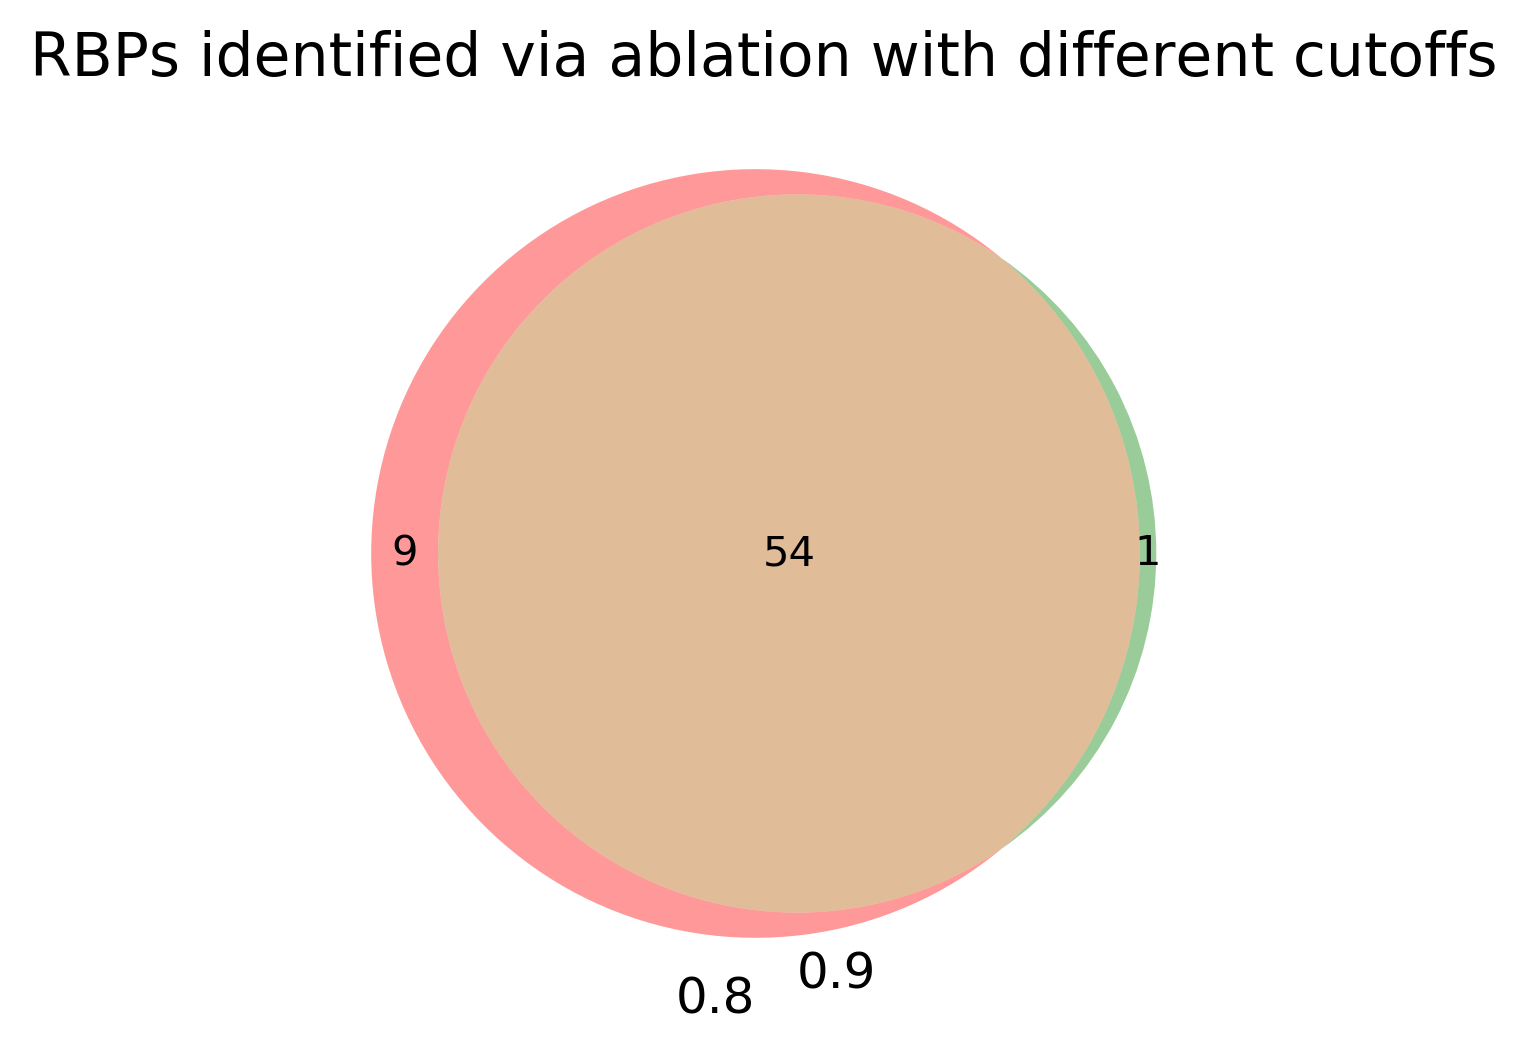

In [257]:
from matplotlib_venn import venn2, venn2_circles

fig, ax = plt.subplots(dpi=300)
venn2(
    [
        set(all_0pt8_genes_counts.columns),
        set(all_genes_counts.columns),
    ],
    set_labels=["0.8", "0.9"],
    ax=ax,
)
ax.set(title="RBPs identified via ablation with different cutoffs")
fig.show()

In [47]:
## GRU importance
print(os.path.join(INTERMEDIATE_DATA_DIR, 'gru_pwm_importance_N.tar'))
gru_pwm_importance = read_dict_of_tables(os.path.join(INTERMEDIATE_DATA_DIR, 'gru_pwm_importance_N.tar'))

/storage/wukevin/projects/rnagps/data/intermediate_kfold_5/gru_pwm_importance_N.tar


In [48]:
gru_pwm_importance_neg_counts = []
gru_pwm_importance_average_impact = []
gru_pwm_importance_sd_impact = []

for localization in valid_dataset.compartments:
    # Select features with at least 2 nonzero hits, then find the average
    this_local_pwm_importance = gru_pwm_importance[localization]
    # Negative impact and not NaN
    this_local_ft_neg = np.logical_and(~np.isnan(this_local_pwm_importance.values), this_local_pwm_importance.values < 0)
    this_local_ft_neg_count = np.sum(this_local_ft_neg, axis=0)
    gru_pwm_importance_neg_counts.append(this_local_ft_neg_count)
    gru_pwm_importance_average_impact.append(np.nanmean(this_local_pwm_importance, axis=0))
    gru_pwm_importance_sd_impact.append(np.nanstd(this_local_pwm_importance, axis=0))

gru_pwm_importance_average_impact = pd.DataFrame(
    gru_pwm_importance_average_impact,
    index=valid_dataset.compartments,
    columns=gru_pwm_importance['Erm'].columns,  # Just an example
)
gru_pwm_importance_sd_impact = pd.DataFrame(
    gru_pwm_importance_sd_impact,
    index=valid_dataset.compartments,
    columns=gru_pwm_importance['Erm'].columns,  # Just an example
)
gru_pwm_importance_neg_counts = pd.DataFrame(
    gru_pwm_importance_neg_counts,
    index=valid_dataset.compartments,
    columns=gru_pwm_importance['Erm'].columns,  # Just an example
)
gru_pwm_importance_average_impact

/storage/wukevin/miniconda3/envs/rnafinder/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':
/storage/wukevin/miniconda3/envs/rnafinder/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':
/storage/wukevin/miniconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


u5_RNCMPT00001 A1CF  u5_RNCMPT00002 ANKHD1  u5_RNCMPT00004 BRUNOL4  \
Erm                -0.000004              -0.000038               -0.000028   
Lma                -0.001197              -0.003127               -0.002874   
Mito                0.000673               0.002701                0.003225   
Nes                -0.000006               0.000006                0.000011   
Nik                -0.002323              -0.001946               -0.003699   
Nls                -0.002326              -0.009861               -0.008246   
NucPore            -0.000240              -0.000045               -0.000369   
Omm                 0.000005              -0.000026               -0.000004   

         u5_RNCMPT00166 BRUNOL5  u5_RNCMPT00187 BRUNOL6  u5_RNCMPT00156 CNOT4  \
Erm                   -0.000037               -0.000044             -0.000079   
Lma                   -0.002574               -0.001545              0.003665   
Mito                   0.001364                0.001018              0.000211   
Nes                   -0.000005                0.000101             -0.000067   
Nik                   -0.002902               -0.003358             -0.000785   
Nls                   -0.006785               -0.005276              0.003166   
NucPore               -0.000369               -0.000353              0.000155   
Omm                   -0.000002               -0.000032             -0.000138   

         u5_RNCMPT00012 CPEB2  u5_RNCMPT00158 CPEB4  u5_RNCMPT00013 DAZAP1  \
Erm                  0.000071             -0.000009              -0.000007   
Lma                 -0.000842             -0.001290               0.000125   
Mito                 0.003172              0.006122               0.002226   
Nes                  0.000022              0.000028              -0.000001   
Nik                 -0.005388             -0.003772              -0.003665   
Nls                 -0.003492             -0.006713              -0.004152   
NucPore              0.000032             -0.000088               0.000433   
Omm                 -0.000050              0.000009              -0.000033   

         u5_RNCMPT00149 ENOX1  ...  u3_RNCMPT00077 TIA1  u3_RNCMPT00075 TUT1  \
Erm                 -0.000042  ...             0.000893             0.000386   
Lma                  0.000069  ...            -0.000258            -0.008334   
Mito                 0.000852  ...             0.018830             0.016216   
Nes                 -0.000045  ...             0.000260             0.000309   
Nik                 -0.002402  ...            -0.034671            -0.034770   
Nls                 -0.004060  ...            -0.066026            -0.035270   
NucPore             -0.001277  ...            -0.002741             0.009559   
Omm                 -0.000020  ...            -0.000312            -0.000141   

         u3_RNCMPT00079 U2AF2  u3_RNCMPT00116 YBX1  u3_RNCMPT00083 YBX1  \
Erm                  0.000636             0.000314             0.000305   
Lma                 -0.000845            -0.003784            -0.003555   
Mito                 0.019481             0.006801             0.006926   
Nes                  0.000426             0.000198             0.000167   
Nik                 -0.028937            -0.017876            -0.015415   
Nls                 -0.041622            -0.018133            -0.015479   
NucPore             -0.003962             0.001696             0.002188   
Omm                 -0.000161             0.000732             0.000746   

         u3_RNCMPT00084 YBX2  u3_RNCMPT00085 ZC3H10  u3_RNCMPT00086 ZC3H14  \
Erm                 0.000274               0.000247               0.001097   
Lma                -0.005715              -0.005761              -0.002183   
Mito                0.012051               0.008900               0.027057   
Nes                 0.000311               0.000031               0.000416   
Nik                -0.024676              -0.022785              -0.037060   

0.046965346888949475


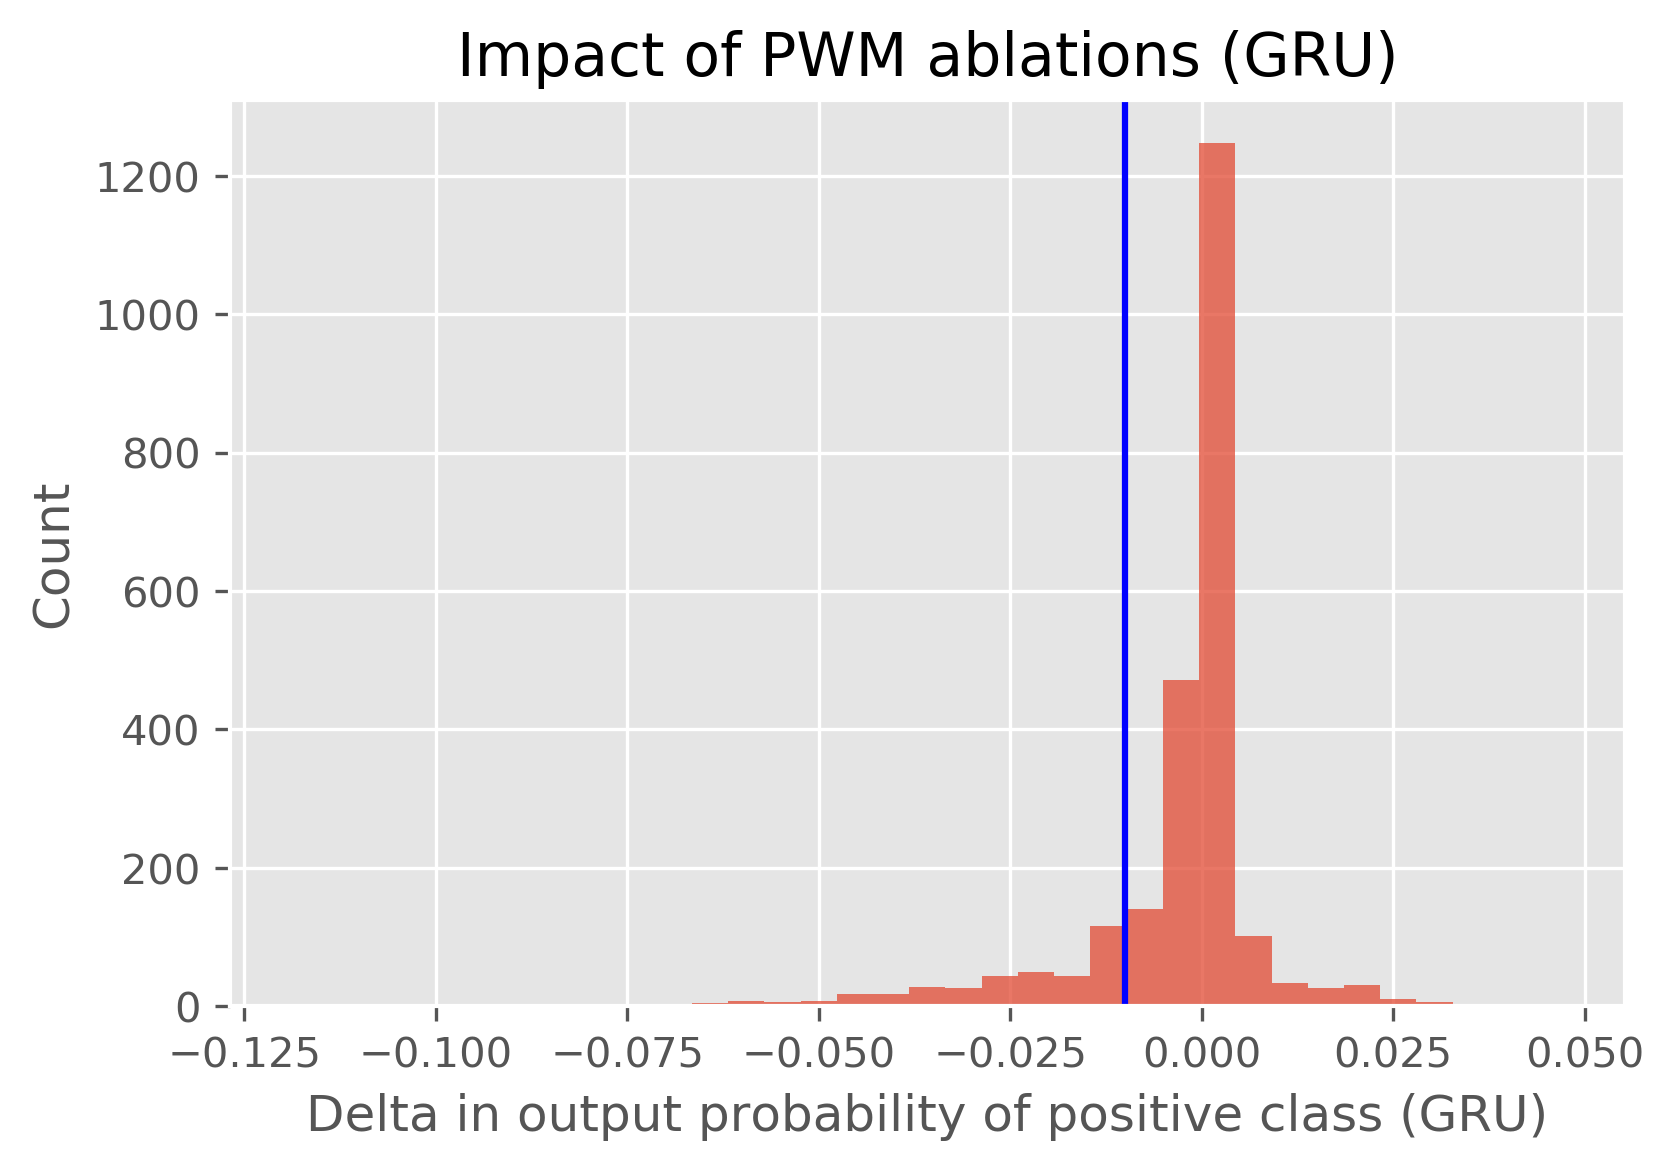

In [49]:
print(np.nanmax(gru_pwm_importance_average_impact.values))
fig, ax = plt.subplots(dpi=300)
ax.hist(gru_pwm_importance_average_impact.values[~np.isnan(gru_pwm_importance_average_impact.values)], bins=35, alpha=0.75)
ax.set(
    xlabel="Delta in output probability of positive class (GRU)",
    ylabel="Count",
    title="Impact of PWM ablations (GRU)",
)
ax.axvline(-0.01, color='blue')
fig.show()

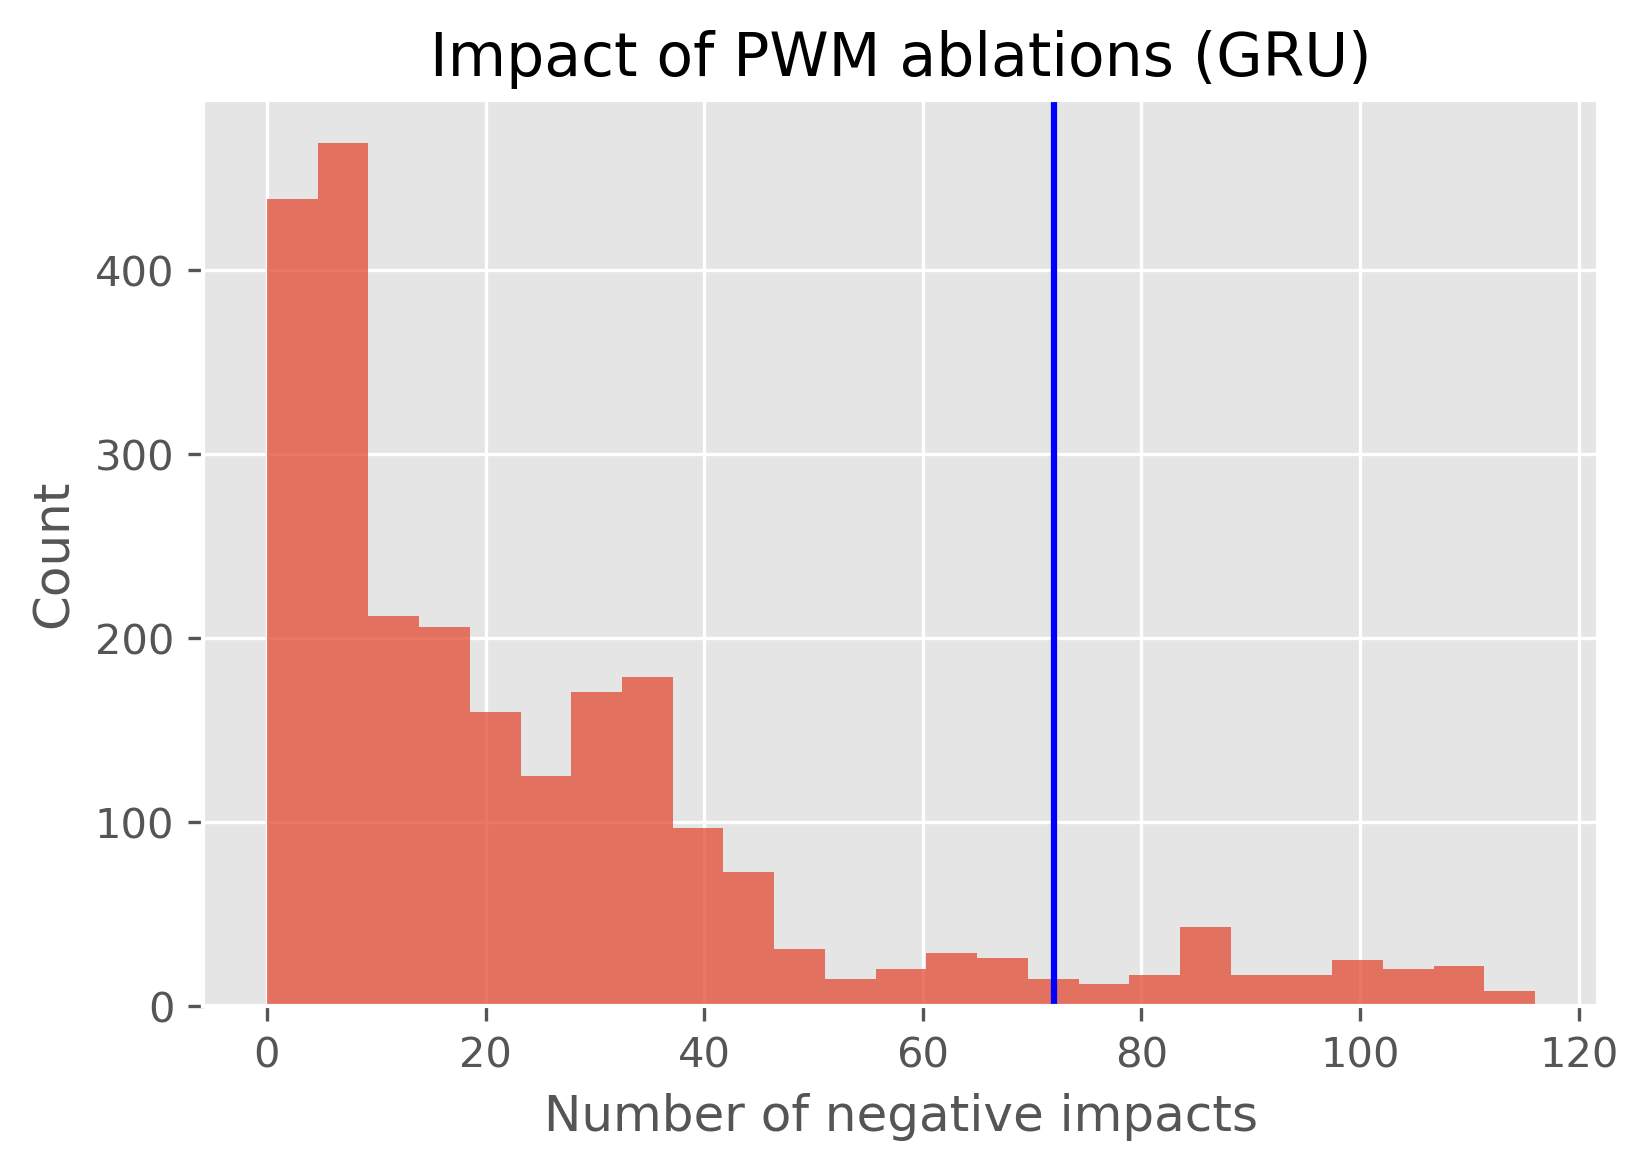

In [50]:
fig, ax = plt.subplots(dpi=300)
ax.hist(gru_pwm_importance_neg_counts.values[~np.isnan(gru_pwm_importance_neg_counts.values)], bins=25, alpha=0.75)
ax.set(
    xlabel="Number of negative impacts",
    ylabel="Count",
    title="Impact of PWM ablations (GRU)",
)
ax.axvline(72, color='blue')
fig.show()

In [51]:
gru_pwm_importance_desired_indices = np.logical_and(
    np.logical_and(gru_pwm_importance_average_impact.values <= -0.01, gru_pwm_importance_neg_counts.values >= 5),
    ~np.isnan(gru_pwm_importance_average_impact.values)
)
gru_pwm_importance_desired_indices = np.logical_or(
    gru_pwm_importance_desired_indices,
    gru_pwm_importance_neg_counts.values >= 72
)
np.sum(gru_pwm_importance_desired_indices)

/storage/wukevin/miniconda3/envs/rnafinder/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less_equal
  


377

In [52]:
gru_pwm_importance_rbps = {l: list() for l in valid_dataset.compartments}
gru_pwm_importance_hit_locations = pd.DataFrame(
    0,
    index=valid_dataset.compartments,
    columns=['u5', 'cds', 'u3'],
)
for local_idx, ft_idx in zip(*np.where(gru_pwm_importance_desired_indices)):
    localization = gru_pwm_importance_average_impact.index[local_idx]
    trans_part, pwm_name = gru_pwm_importance_average_impact.columns[ft_idx].split("_")
    _name, gene_name = pwm_name.split()
#     pwm_importance_rbps[localization].add(gene_name)  # Don't duplicate gene names
    gru_pwm_importance_rbps[localization].append(gene_name)  # Allows multiple hits of the same gene name
    gru_pwm_importance_hit_locations.loc[localization, trans_part] += 1
#     print(localization, trans_part, pwm_name)

gru_all_genes = sorted(list(set(itertools.chain.from_iterable(gru_pwm_importance_rbps.values()))))
gru_all_genes_counts = pd.DataFrame(
    0,
    index=valid_dataset.compartments,
    columns=gru_all_genes,
)
for localization, genes in gru_pwm_importance_rbps.items():
    for gene in genes:
        gru_all_genes_counts.loc[localization, gene] += 1
#     print("***", localization)
#     print('\n'.join(set(genes)))
gru_all_genes_counts.index = [data_loader.LOCALIZATION_FULL_NAME_DICT[l] for l in gru_all_genes_counts.index]
gru_all_genes_counts

A1CF  ANKHD1  BRUNOL4  BRUNOL5  BRUNOL6  CNOT4  CPEB2  \
ER membrane             0       0        0        0        0      0      0   
Nuclear lamina          0       0        0        0        0      0      0   
Mito matrix             0       0        0        0        0      0      0   
Cytosol                 0       0        0        0        0      0      0   
Nucleolus               1       1        2        2        2      2      2   
Nucleus                 1       0        2        2        2      2      2   
Nuclear pore            0       0        1        0        0      0      0   
Outer mito membrane     0       0        0        0        0      0      0   

                     CPEB4  DAZAP1  ENOX1  ...  TARDBP  TIA1  TUT1  U2AF2  \
ER membrane              0       0      0  ...       0     0     0      0   
Nuclear lamina           0       0      0  ...       0     0     0      0   
Mito matrix              0       0      0  ...       0     0     0      0   
Cytosol                  0       0      0  ...       0     0     0      0   
Nucleolus                2       1      2  ...       2     4     2      2   
Nucleus                  2       1      2  ...       2     4     2      1   
Nuclear pore             0       1      0  ...       0     0     0      0   
Outer mito membrane      0       0      0  ...       0     0     0      0   

                     YBX1  YBX2  ZC3H10  ZC3H14  ZCRB1  ZNF638  
ER membrane             0     0       0       0      0       0  
Nuclear lamina          0     0       0       0      0       0  
Mito matrix             0     0       0       0      0       0  
Cytosol                 0     0       0       0      0       0  
Nucleolus               4     2       2       2      2       2  
Nucleus                 4     2       2       2      2       2  
Nuclear pore            0     0       0       0      0       0  
Outer mito membrane     0     0       0       0      0       0  

[8 rows x 80 columns]

In [53]:
' '.join(gru_all_genes_counts.columns)

'A1CF ANKHD1 BRUNOL4 BRUNOL5 BRUNOL6 CNOT4 CPEB2 CPEB4 DAZAP1 ENOX1 ESRP2 FMR1 FUS FXR1 FXR2 G3BP2 HNRNPA1 HNRNPA1L2 HNRNPA2B1 HNRNPC HNRNPCL1 HNRNPH2 HNRNPK HNRNPL HNRPLL HuR IGF2BP2 IGF2BP3 KHDRBS1 KHDRBS2 KHDRBS3 LIN28A MATR3 MBNL1 MSI1 PABPC1 PABPC3 PABPC4 PABPC5 PABPN1 PCBP1 PCBP2 PPRC1 PTBP1 QKI RALY RBFOX1 RBM24 RBM28 RBM3 RBM4 RBM41 RBM42 RBM45 RBM46 RBM5 RBM6 RBM8A RBMS1 RBMS3 SAMD4A SART3 SFPQ SNRNP70 SNRPA SRSF1 SRSF10 SRSF2 SRSF7 SRSF9 TARDBP TIA1 TUT1 U2AF2 YBX1 YBX2 ZC3H10 ZC3H14 ZCRB1 ZNF638'

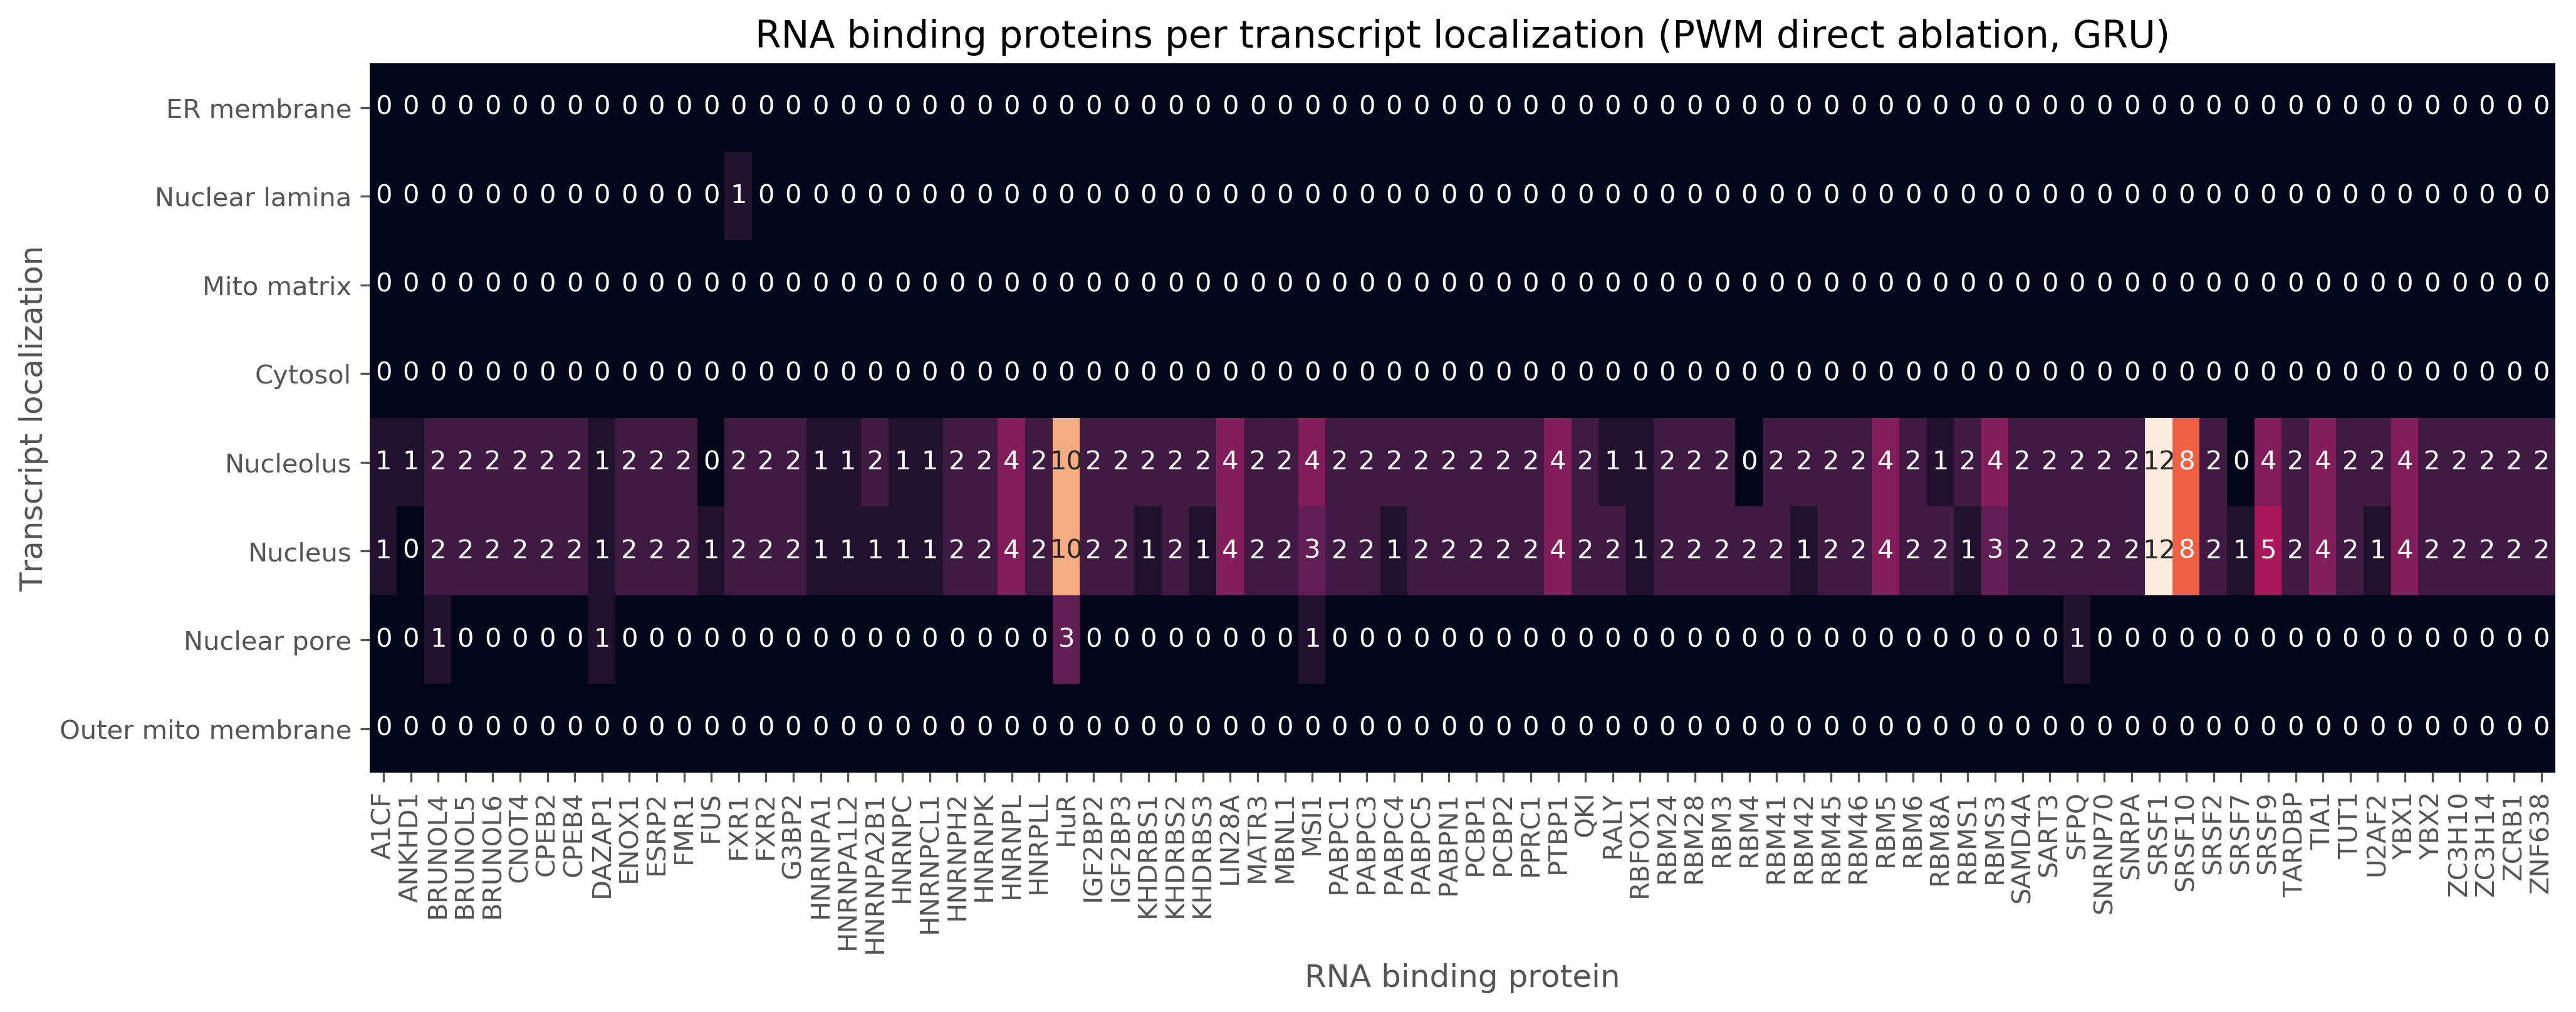

In [54]:
fig, ax = plt.subplots(dpi=300, figsize=(15, 5))
ax = sns.heatmap(gru_all_genes_counts, annot=True, cbar=False, ax=ax)
ax.set(
    title="RNA binding proteins per transcript localization (PWM direct ablation, GRU)",
    ylabel="Transcript localization",
    xlabel="RNA binding protein",
)
fig.show()

PWM direct ablation, GRU


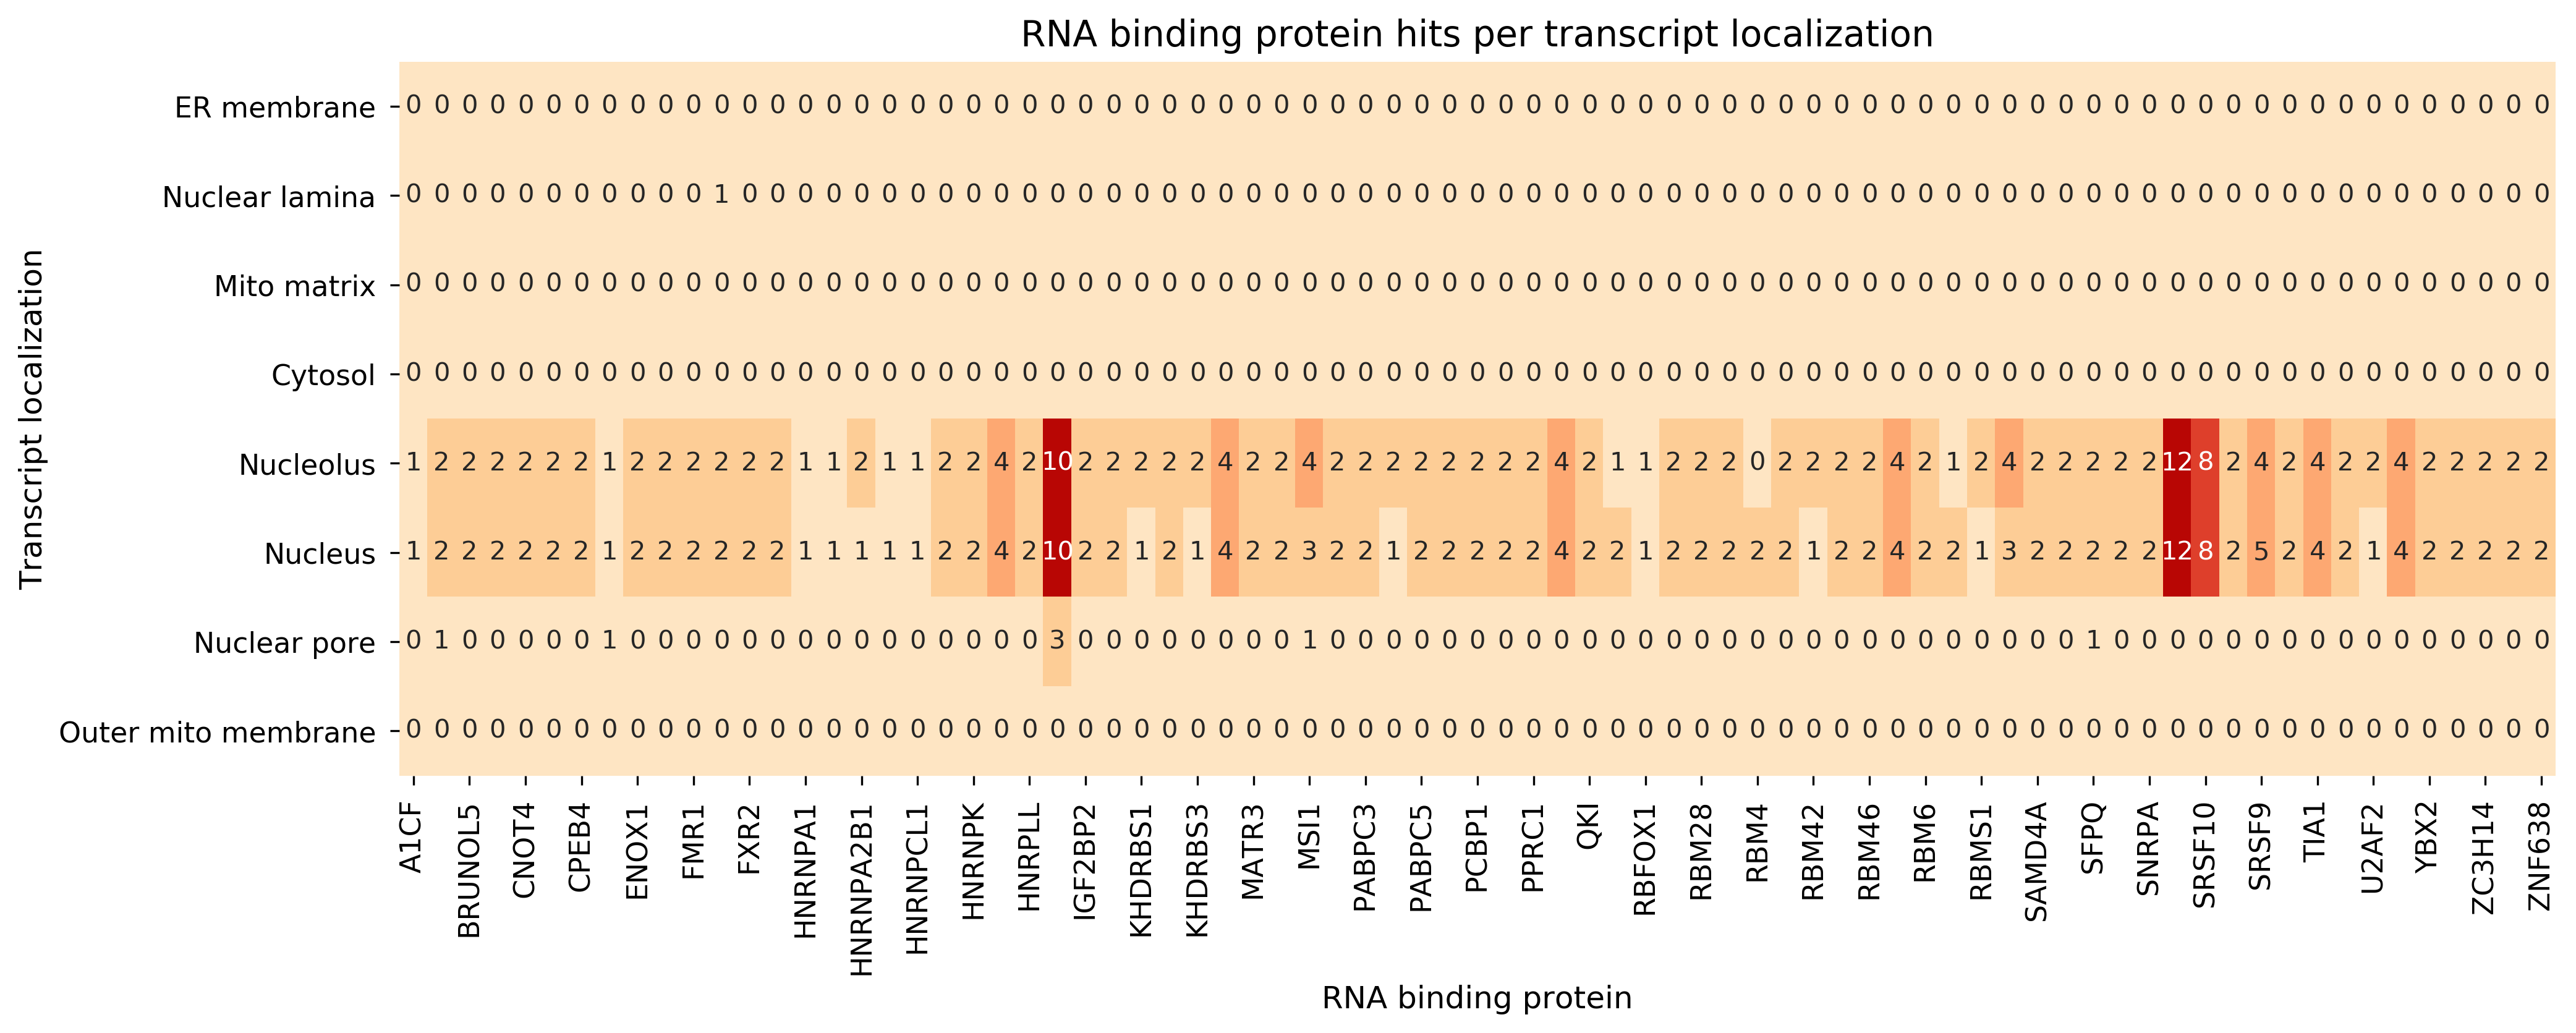

In [273]:
print("PWM direct ablation, GRU")
gru_hit_select_genes_counts = gru_all_genes_counts.loc[:, np.sum(gru_all_genes_counts, axis=0) > 1]
fig, ax = plt.subplots(dpi=300, figsize=(15, 5))
ax = sns.heatmap(gru_hit_select_genes_counts, annot=True, cbar=False, ax=ax, cmap=sns.color_palette("OrRd"),)
ax.set(
    title="RNA binding protein hits per transcript localization",
    ylabel="Transcript localization",
    xlabel="RNA binding protein",
)
fig.savefig(os.path.join(PLOT_DIR, "gru_pwm_ablation.pdf"), dpi=1200, bbox_inches='tight')
fig.show()

## Overlap

Look at genes that overlap between the interpretation methods, associate back to transcripts, and see if those transcripts have differential localization. 

For example, if SRSF1 is consistently present, take transcripts with and without SRSF1 binding, and compare localization.

In [58]:
select_genes_counts

BRUNOL4  BRUNOL5  BRUNOL6  CPEB2  DAZAP1  ENOX1  ESRP2  \
ER membrane                2        2        2      1       1      1      2   
Nuclear lamina             1        0        1      0       1      2      1   
Mito matrix                0        0        0      0       0      0      0   
Cytosol                    0        0        0      0       0      0      0   
Nucleolus                  0        0        0      0       0      1      0   
Nucleus                    0        0        1      0       0      0      1   
Nuclear pore               0        0        0      0       0      0      0   
Outer mito membrane        1        1        1      1       0      0      1   

                     FMR1  HNRNPA1L2  HNRNPH2  ...  SFPQ  SRSF1  SRSF10  \
ER membrane             0          1        0  ...     2      2       4   
Nuclear lamina          1          1        1  ...     1      9       7   
Mito matrix             0          0        0  ...     0      0       0   
Cytosol                 0          0        0  ...     0      4       3   
Nucleolus               1          0        0  ...     0      5       4   
Nucleus                 0          0        1  ...     1      8       3   
Nuclear pore            0          0        0  ...     0      0       0   
Outer mito membrane     0          0        0  ...     1      0       0   

                     SRSF2  SRSF9  TIA1  U2AF2  ZC3H10  ZC3H14  ZNF638  
ER membrane              1      2     3      2       0       2       2  
Nuclear lamina           2      4     0      0       1       1       0  
Mito matrix              0      1     0      0       0       0       0  
Cytosol                  1      3     0      0       1       0       0  
Nucleolus                1      2     0      0       0       0       0  
Nucleus                  1      3     0      0       1       0       0  
Nuclear pore             0      0     0      0       0       0       0  
Outer mito membrane      0      0     0      0       0       1       1  

[8 rows x 43 columns]

In [57]:
meme_hit_select_test_genes_counts

CPEB2  CPEB4  FUS  HNRNPC  HNRNPCL1  HNRNPH2  HNRNPK  \
ER membrane              1      2    0       2         2        0       0   
Nuclear lamina           0      0    0       0         0        1       0   
Mito matrix              0      0    0       0         0        0       4   
Cytosol                  1      1    0       1         1        0       0   
Nucleolus                0      0    0       0         0        0       0   
Nucleus                  0      0    1       1         1        0       0   
Nuclear pore             0      0    0       0         0        0       0   
Outer mito membrane      2      2    2       2         2        3       1   

                     HuR  PCBP1  PCBP2  ...  RALY  RBM4  RBM8A  RBMS1  RBMS3  \
ER membrane            1      0      1  ...     1     0      0      0      0   
Nuclear lamina         0      2      1  ...     0     2      0      1      2   
Mito matrix            0      0      3  ...     0     2      1      0      0   
Cytosol                5      0      0  ...     1     0      0      0      0   
Nucleolus              0      1      2  ...     0     0      0      0      0   
Nucleus                1      0      0  ...     1     2      1      0      0   
Nuclear pore           0      0      0  ...     0     0      0      0      0   
Outer mito membrane    7      0      1  ...     2     8      3      1      1   

                     SRSF1  TIA1  U2AF2  ZC3H10  ZC3H14  
ER membrane              2     4      3       0       0  
Nuclear lamina           0     0      0       0       0  
Mito matrix              0     0      0       1       0  
Cytosol                  0     2      1       0       1  
Nucleolus                0     1      1       1       0  
Nucleus                  0     2      1       0       0  
Nuclear pore             0     0      0       0       0  
Outer mito membrane      0     4      2       1       2  

[8 rows x 22 columns]

In [93]:
# Intersection of genes - this is much less specific than intersection of motifs
common_rbps = sorted(list(set(select_genes_counts.columns).intersection(set(meme_hit_select_test_genes_counts.columns))))
', '.join(common_rbps)

'CPEB2, HNRNPH2, HuR, PCBP2, PTBP1, RBMS3, SRSF1, TIA1, U2AF2, ZC3H10, ZC3H14'

In [95]:
pwm_importance_rbps_ids['Erm'][:5]

['RNCMPT00004', 'RNCMPT00166', 'RNCMPT00187', 'RNCMPT00012', 'RNCMPT00150']

In [94]:
meme_hit_test_ids = read_aggregated_tomtom_hits(
    gap_1_tomtom_test_results,
    q_cutoff=0.05,
    gene_level=False,
)
meme_hit_test_ids['Erm'][:5]

['RNCMPT00158', 'RNCMPT00079', 'RNCMPT00165', 'RNCMPT00158', 'RNCMPT00079']

In [151]:
rbp_table = interpretation.read_rna_complete_html_table()
rbp_table.head()

Gene name           ID       Species    IUPAC  Logo
0       A1CF  RNCMPT00001  Homo_sapiens  WUAAUUR   NaN
2     RBFOX1  RNCMPT00168  Homo_sapiens  WGCAUGM   NaN
4     ANKHD1  RNCMPT00002  Homo_sapiens  AGACGWW   NaN
12   BRUNOL4  RNCMPT00004  Homo_sapiens  KGUGUKK   NaN
13   BRUNOL5  RNCMPT00166  Homo_sapiens  UGUGUKK   NaN

In [150]:
rbp_dict = interpretation.read_meme_pwms(fname=os.path.join(data_loader.LOCAL_DATA_DIR, "meme", "Ray2013_rbp_Homo_sapiens.dna_encoded.meme"), incl_gene=False)
rbp_dict['RNCMPT00268']  # Selected randomly to sanity check

A         C         G         T
0  0.242168  0.538758  0.062005  0.157070
1  0.038639  0.218876  0.038639  0.703846
2  0.015301  0.015301  0.015301  0.954098
3  0.015301  0.015301  0.015301  0.954098
4  0.015301  0.109172  0.015301  0.860226
5  0.015301  0.675671  0.015301  0.293727
6  0.062081  0.158058  0.062081  0.717779

In [149]:
# Intersection of PWM motifs
def get_intersected_hits(assembly_dict, ablation_dict, verbose=True):
    """Given two dictionaries mapping <localization : rbp_ids> return intersection"""
    intersected_hits = {}
    for localization in assembly_dict.keys():
        assembly_hits = set(assembly_dict[localization])
        ablation_hits = set(ablation_dict[localization])
        inter = assembly_hits.intersection(ablation_hits)
        if verbose:
            print(localization, len(inter))
            print(inter)
            print([rbp_table[rbp_table['ID'] == rid]['Gene name'].item() for rid in inter])
        intersected_hits[localization] = list(inter)
    return intersected_hits

intersected_hits = get_intersected_hits(meme_hit_test_ids, pwm_importance_rbps_ids)

Erm 11
{'RNCMPT00159', 'RNCMPT00079', 'RNCMPT00165', 'RNCMPT00268', 'RNCMPT00158', 'RNCMPT00269', 'RNCMPT00044', 'RNCMPT00077', 'RNCMPT00274', 'RNCMPT00012', 'RNCMPT00163'}
['RALY', 'U2AF2', 'TIA1', 'PTBP1', 'CPEB4', 'PTBP1', 'PCBP2', 'TIA1', 'HuR', 'CPEB2', 'SRSF1']
Lma 4
{'RNCMPT00268', 'RNCMPT00044', 'RNCMPT00160', 'RNCMPT00269'}
['PTBP1', 'PCBP2', 'HNRNPH2', 'PTBP1']
Mito 0
set()
[]
Nes 0
set()
[]
Nik 0
set()
[]
Nls 0
set()
[]
NucPore 0
set()
[]
Omm 8
{'RNCMPT00117', 'RNCMPT00268', 'RNCMPT00269', 'RNCMPT00044', 'RNCMPT00086', 'RNCMPT00274', 'RNCMPT00012', 'RNCMPT00112'}
['HuR', 'PTBP1', 'PTBP1', 'PCBP2', 'ZC3H14', 'HuR', 'CPEB2', 'HuR']


In [136]:
all_sequences = [''.join(full_dataset.get_ith_trans_parts(i)) for i in range(len(full_dataset))]

In [137]:
def get_idx_of_match(ppm, sequences, prop=0.9):
    """Return the index of sequences that have a match to pwm"""
    retval = []
    for i, seq in enumerate(sequences):
        if pwm.find_ppm_hits(seq, ppm, prop=prop, debug=True):
            retval.append(i)
    return retval

# <localization : <rbp_id : match_idx> >
intersect_hits_to_idx = {}
for localization, rbp_ids in intersected_hits.items():
    intersect_hits_to_idx[localization] = {}
    for rbp_id in rbp_ids:
        intersect_hits_to_idx[localization][rbp_id] = get_idx_of_match(
            ppm=rbp_dict[rbp_id],
            sequences=all_sequences,
        )

In [138]:
for localization, rbp_dict in intersect_hits_to_idx.items():
    print(localization)
    all_localization_indices = set(range(len(full_dataset)))  # Common to all RBPs
    for rbp_id, idx in rbp_dict.items():
        gene = rbp_table[rbp_table['ID'] == rbp_id]['Gene name'].item()
        print(rbp_id, gene, len(idx), len(idx) / len(full_dataset))
        all_localization_indices = all_localization_indices.intersection(set(idx))
    if rbp_dict:
        print(len(all_localization_indices))

Erm
RNCMPT00159 RALY 3318 0.9065573770491804
RNCMPT00079 U2AF2 3407 0.9308743169398908
RNCMPT00165 TIA1 3441 0.9401639344262295
RNCMPT00268 PTBP1 3586 0.9797814207650273
RNCMPT00158 CPEB4 3373 0.9215846994535519
RNCMPT00269 PTBP1 3592 0.9814207650273225
RNCMPT00044 PCBP2 3612 0.9868852459016394
RNCMPT00077 TIA1 3470 0.9480874316939891
RNCMPT00274 HuR 3456 0.9442622950819672
RNCMPT00012 CPEB2 3478 0.9502732240437158
RNCMPT00163 SRSF1 3616 0.9879781420765027
3207
Lma
RNCMPT00268 PTBP1 3586 0.9797814207650273
RNCMPT00044 PCBP2 3612 0.9868852459016394
RNCMPT00160 HNRNPH2 3577 0.9773224043715847
RNCMPT00269 PTBP1 3592 0.9814207650273225
3518
Mito
Nes
Nik
Nls
NucPore
Omm
RNCMPT00117 HuR 3530 0.9644808743169399
RNCMPT00268 PTBP1 3586 0.9797814207650273
RNCMPT00269 PTBP1 3592 0.9814207650273225
RNCMPT00044 PCBP2 3612 0.9868852459016394
RNCMPT00086 ZC3H14 3530 0.9644808743169399
RNCMPT00274 HuR 3456 0.9442622950819672
RNCMPT00012 CPEB2 3478 0.9502732240437158
RNCMPT00112 HuR 3511 0.959289617486

Do the same as above, but also split by segment of transcript

In [145]:
meme_hit_test_ids_by_trans_part = read_aggregated_tomtom_hits(
    gap_1_tomtom_test_results,
    q_cutoff=0.05,
    gene_level=False,
    split_by_trans_part=True,
)
meme_hit_test_ids_by_trans_part['Erm_cds'][:5]

['RNCMPT00158', 'RNCMPT00079', 'RNCMPT00165', 'RNCMPT00158', 'RNCMPT00079']

In [147]:
pwm_importance_rbps_ids_by_trans_part['Erm_cds'][:5]

['RNCMPT00004', 'RNCMPT00166', 'RNCMPT00187', 'RNCMPT00012', 'RNCMPT00150']

In [154]:
intersected_hits_by_trans_part = get_intersected_hits(
    meme_hit_test_ids_by_trans_part,
    pwm_importance_rbps_ids_by_trans_part,
)

Erm_cds 7
{'RNCMPT00079', 'RNCMPT00268', 'RNCMPT00165', 'RNCMPT00269', 'RNCMPT00077', 'RNCMPT00274', 'RNCMPT00012'}
['U2AF2', 'PTBP1', 'TIA1', 'PTBP1', 'TIA1', 'HuR', 'CPEB2']
Erm_u3 1
{'RNCMPT00269'}
['PTBP1']
Erm_u5 0
set()
[]
Lma_cds 0
set()
[]
Lma_u3 3
{'RNCMPT00044', 'RNCMPT00268', 'RNCMPT00269'}
['PCBP2', 'PTBP1', 'PTBP1']
Lma_u5 0
set()
[]
Mito_cds 0
set()
[]
Mito_u3 0
set()
[]
Mito_u5 0
set()
[]
Nes_cds 0
set()
[]
Nes_u3 0
set()
[]
Nes_u5 0
set()
[]
Nik_cds 0
set()
[]
Nik_u3 0
set()
[]
Nik_u5 0
set()
[]
Nls_cds 0
set()
[]
Nls_u3 0
set()
[]
Nls_u5 0
set()
[]
NucPore_cds 0
set()
[]
NucPore_u3 0
set()
[]
Omm_cds 0
set()
[]
Omm_u3 0
set()
[]
Omm_u5 0
set()
[]


In [155]:
all_sequences_by_trans_part = [full_dataset.get_ith_trans_parts(i) for i in range(len(full_dataset))]

In [156]:
# For each localization, calculate which sequences it is present in
# <localization : <rbp_id : match_idx> >
intersect_hits_to_idx_by_trans_part = {}
for localization, rbp_ids in intersected_hits_by_trans_part.items():
    l, trans_part = localization.split("_")
    trans_part_idx = ['u5', 'cds', 'u3'].index(trans_part)
    intersect_hits_to_idx_by_trans_part[localization] = {}
    for rbp_id in rbp_ids:
        # Keys here are still localization_transpart
        intersect_hits_to_idx_by_trans_part[localization][rbp_id] = get_idx_of_match(
            ppm=rbp_dict[rbp_id],
            sequences=[s[trans_part_idx] for s in all_sequences_by_trans_part],
        )

In [157]:
# Report some metadata on how often each of these RBPs occurs
for localization, rbp_dict in intersect_hits_to_idx_by_trans_part.items():
    print(localization)
    all_localization_indices = set(range(len(full_dataset)))  # Common to all RBPs
    for rbp_id, idx in rbp_dict.items():
        gene = rbp_table[rbp_table['ID'] == rbp_id]['Gene name'].item()
        print(rbp_id, gene, len(idx), len(idx) / len(full_dataset))
        all_localization_indices = all_localization_indices.intersection(set(idx))
    if rbp_dict:
        print(len(all_localization_indices))

Erm_cds
RNCMPT00079 U2AF2 2374 0.6486338797814207
RNCMPT00268 PTBP1 2831 0.7734972677595628
RNCMPT00165 TIA1 2458 0.6715846994535519
RNCMPT00269 PTBP1 2869 0.783879781420765
RNCMPT00077 TIA1 2559 0.6991803278688524
RNCMPT00274 HuR 2510 0.6857923497267759
RNCMPT00012 CPEB2 2626 0.7174863387978142
2085
Erm_u3
RNCMPT00269 PTBP1 3352 0.9158469945355191
3352
Erm_u5
Lma_cds
Lma_u3
RNCMPT00044 PCBP2 3315 0.9057377049180327
RNCMPT00268 PTBP1 3319 0.9068306010928961
RNCMPT00269 PTBP1 3352 0.9158469945355191
3178
Lma_u5
Mito_cds
Mito_u3
Mito_u5
Nes_cds
Nes_u3
Nes_u5
Nik_cds
Nik_u3
Nik_u5
Nls_cds
Nls_u3
Nls_u5
NucPore_cds
NucPore_u3
Omm_cds
Omm_u3
Omm_u5


Test if the sequences have any bearing on differential localization

In [160]:
full_data[1].shape

(3660, 8)

In [187]:
def eval_rbp_correlation_localization(hits, total_len=len(full_dataset), verbose=True):
    """
    Given a dictionary of <localization_transpart : <rbp_id : obs_idx_of_rbp_hits>>
    Evaluate whether or not a sequence contains a hit has any bearing on its localization
    Returns a dict of <(localization, transpart, rbp_id) : pval>
    """
    retval = {}
    for localization, rbp_dict in intersect_hits_to_idx_by_trans_part.items():
        l, trans_part = localization.split("_")
        l_idx = full_dataset.compartments.index(l)
        if rbp_dict and verbose:
            print(localization)
        for rbp_id, idx in rbp_dict.items():
            idx_inverse = [i for i in range(total_len) if i not in idx]
            categories_hits, hits_counts = np.unique(full_data[1][idx, l_idx], return_counts=True)
            categories_no_hits, no_hits_counts = np.unique(full_data[1][idx_inverse, l_idx], return_counts=True)
            assert np.all(categories_hits == categories_no_hits)
            cont_table = np.vstack([hits_counts, no_hits_counts])
            # Chi square comparing localization patterns of sequences with and without hits
            stat, pval, _dof, _expected = scipy.stats.chi2_contingency(observed=cont_table)
            # stat, pval = scipy.stats.fisher_exact(cont_table)
            # Top row is hits, bottom row is no hits
            # First col is no localization, second col is localization
            # print(cont_table)
            # print(_expected)
            gene = rbp_table[rbp_table['ID'] == rbp_id]['Gene name'].item()
            if verbose: print(rbp_id, gene, stat, pval)
            retval[(l, trans_part, rbp_id)] = pval
    return retval

intersect_hits_by_trans_part_corr = eval_rbp_correlation_localization(intersect_hits_to_idx_by_trans_part)

Erm_cds
RNCMPT00079 U2AF2 152.47505341647457 4.988850151837534e-35
RNCMPT00268 PTBP1 176.11476703196223 3.4180193075367467e-40
RNCMPT00165 TIA1 159.30475867036432 1.6052851888747054e-36
RNCMPT00269 PTBP1 192.15124870456106 1.078384066411659e-43
RNCMPT00077 TIA1 181.68243201193806 2.0801103834515585e-41
RNCMPT00274 HuR 186.2391767780259 2.105133930908961e-42
RNCMPT00012 CPEB2 177.17824458182048 2.002397913703288e-40
Erm_u3
RNCMPT00269 PTBP1 50.71766454590211 1.0665531160879966e-12
Lma_u3
RNCMPT00044 PCBP2 15.017075234543643 0.00010654279512121801
RNCMPT00268 PTBP1 23.96622973296147 9.80403309945159e-07
RNCMPT00269 PTBP1 26.385975857724134 2.795629359217508e-07


In [189]:
print(intersect_hits_by_trans_part_corr)

{('Erm', 'cds', 'RNCMPT00079'): 4.988850151837534e-35, ('Erm', 'cds', 'RNCMPT00268'): 3.4180193075367467e-40, ('Erm', 'cds', 'RNCMPT00165'): 1.6052851888747054e-36, ('Erm', 'cds', 'RNCMPT00269'): 1.078384066411659e-43, ('Erm', 'cds', 'RNCMPT00077'): 2.0801103834515585e-41, ('Erm', 'cds', 'RNCMPT00274'): 2.105133930908961e-42, ('Erm', 'cds', 'RNCMPT00012'): 2.002397913703288e-40, ('Erm', 'u3', 'RNCMPT00269'): 1.0665531160879966e-12, ('Lma', 'u3', 'RNCMPT00044'): 0.00010654279512121801, ('Lma', 'u3', 'RNCMPT00268'): 9.80403309945159e-07, ('Lma', 'u3', 'RNCMPT00269'): 2.795629359217508e-07}


### FDR correction

In [282]:
from statsmodels.stats.multitest import fdrcorrection

_rejected, pvalues_bh = fdrcorrection(
    list(intersect_hits_by_trans_part_corr.values()),
    alpha=0.05,
    method='indep',
    is_sorted=False,
)
for k, padj in zip(intersect_hits_by_trans_part_corr, pvalues_bh):
    print(k, padj)

('Erm', 'cds', 'RNCMPT00079') 7.839621667173268e-35
('Erm', 'cds', 'RNCMPT00268') 7.519642476580842e-40
('Erm', 'cds', 'RNCMPT00165') 2.9430228462702935e-36
('Erm', 'cds', 'RNCMPT00269') 1.1862224730528248e-42
('Erm', 'cds', 'RNCMPT00077') 7.627071405989048e-41
('Erm', 'cds', 'RNCMPT00274') 1.1578236619999286e-41
('Erm', 'cds', 'RNCMPT00012') 5.506594262684041e-40
('Erm', 'u3', 'RNCMPT00269') 1.4665105346209953e-12
('Lma', 'u3', 'RNCMPT00044') 0.00010654279512121801
('Lma', 'u3', 'RNCMPT00268') 1.0784436409396749e-06
('Lma', 'u3', 'RNCMPT00269') 3.4168803279325095e-07
